In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import mdtraj as md
import math
from utils import write_traj, save_traj
from cgae import *
import numpy as np
from cgae import *

In [23]:
# hyperparameters 
par = {}
par["n_atom"] = 32
par["N_cg"] = 3
par["lr"]  = 1e-4
par["batch_size"] = 20  
par["Tstart"] = 4.0      # starting temperature 
par["max_epoch"] = 800
par["n_mol"] = 1         # number of molecules, 
par["epoch_regularize"] = 400    # first epoch to include instataneous force regularization
par["rho"] = 0.005       # relative weight for force regularization
par["decay_ratio"] = 0.4 # the decay rate for the temperature annealing 
device = 'cpu'

In [24]:
# load data 
otp = md.load("data/otp.pdb")
otp_top = otp.top.to_dataframe()[0]
otp_element = otp_top['element'].values.tolist()
traj = np.load('data/otp_xyz.npy')
force = np.load('data/otp_force.npy')

In [25]:
# prepare data 
traj = traj[-3000:] * 10
force = force[-3000:] * 0.0239

N_cg = par["N_cg"]
n_atom = par["n_atom"]
n_mol = par["n_mol"]
batch_size = par["batch_size"]
n_batch = int(traj.shape[0] // batch_size)
n_sample = n_batch * batch_size
xyz = traj[:n_sample].reshape(-1, batch_size, n_mol, n_atom, 3)
force = force[:n_sample].reshape(-1, batch_size, n_atom, 3)
device = "cpu"

In [26]:
Encoder = encoder(in_dim=par["n_atom"], out_dim=par["N_cg"], hard=False, device=device).to(device)
Decoder = decoder(in_dim=par["N_cg"], out_dim=par["n_atom"]).to(device)

# Initialize Temperature Scheduler for Gumbel softmax 
t0 = par["Tstart"]
tmin = 0.2
temp = np.linspace(0, par["max_epoch"], par["max_epoch"] )

decay_epoch = int(par["max_epoch"] * par["decay_ratio"])
t_sched = t0 * np.exp(-temp/decay_epoch ) +  tmin
t_sched = torch.Tensor(t_sched).to(device)


# Initialize Optimizer 
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(list(Encoder.parameters()) + list(Decoder.parameters()), lr=par["lr"]) 

loss_log = []
loss_ae_log = []
loss_fm_log = []

epoch 0 reconstruction  6.637 instantaneous forces 848.237  tau  4.200


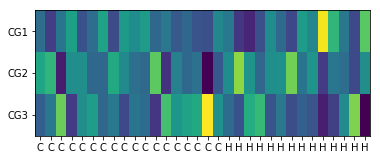

epoch 1 reconstruction  6.404 instantaneous forces 791.584  tau  4.188


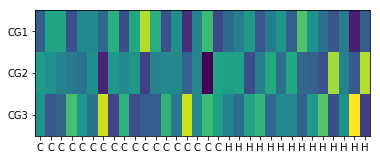

epoch 2 reconstruction  6.196 instantaneous forces 837.703  tau  4.175


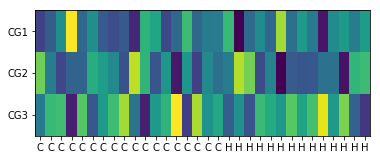

epoch 3 reconstruction  5.999 instantaneous forces 871.905  tau  4.163


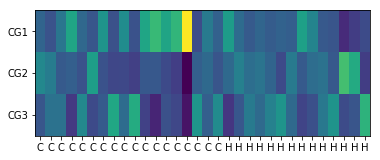

epoch 4 reconstruction  5.819 instantaneous forces 810.160  tau  4.150


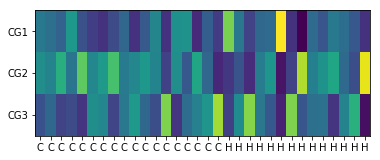

epoch 5 reconstruction  5.656 instantaneous forces 830.255  tau  4.138


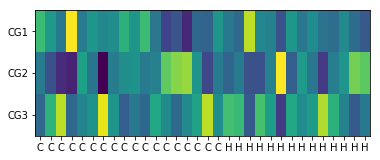

epoch 6 reconstruction  5.501 instantaneous forces 823.641  tau  4.126


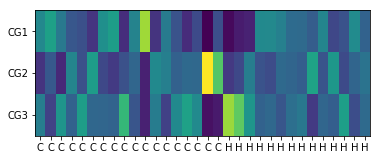

epoch 7 reconstruction  5.358 instantaneous forces 887.392  tau  4.113


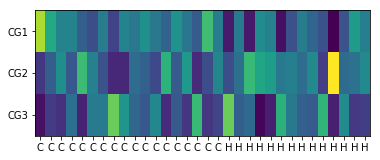

epoch 8 reconstruction  5.226 instantaneous forces 842.049  tau  4.101


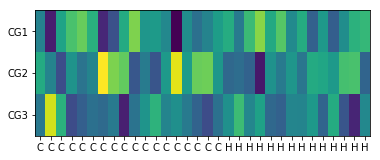

epoch 9 reconstruction  5.109 instantaneous forces 916.133  tau  4.089


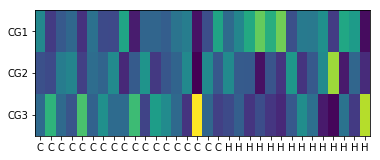

epoch 10 reconstruction  4.995 instantaneous forces 877.264  tau  4.077


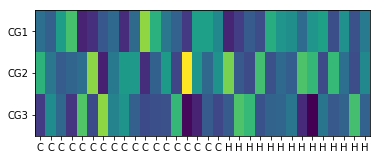

epoch 11 reconstruction  4.891 instantaneous forces 859.448  tau  4.065


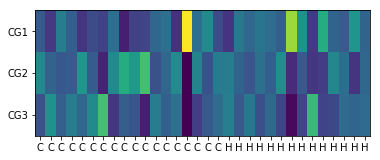

epoch 12 reconstruction  4.797 instantaneous forces 852.956  tau  4.053


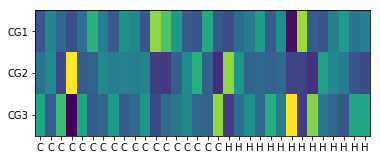

epoch 13 reconstruction  4.708 instantaneous forces 880.869  tau  4.041


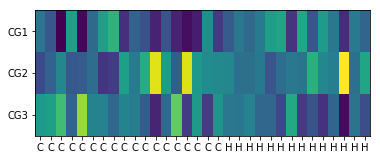

epoch 14 reconstruction  4.628 instantaneous forces 870.518  tau  4.029


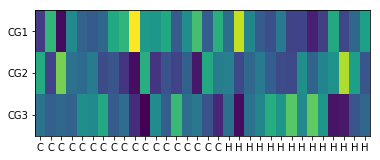

epoch 15 reconstruction  4.553 instantaneous forces 911.510  tau  4.017


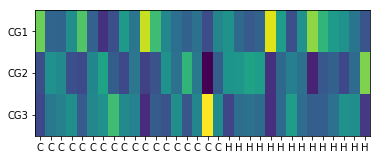

epoch 16 reconstruction  4.484 instantaneous forces 876.960  tau  4.005


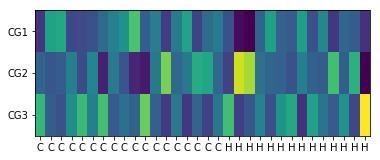

epoch 17 reconstruction  4.420 instantaneous forces 860.335  tau  3.993


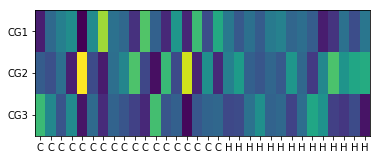

epoch 18 reconstruction  4.362 instantaneous forces 885.012  tau  3.981


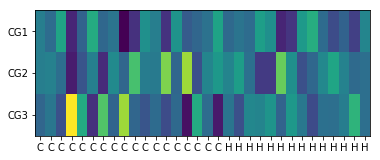

epoch 19 reconstruction  4.307 instantaneous forces 899.519  tau  3.969


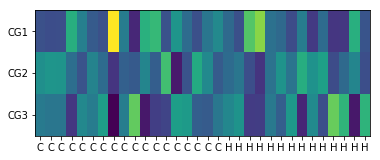

epoch 20 reconstruction  4.256 instantaneous forces 878.317  tau  3.957


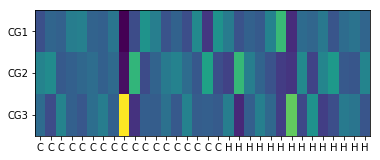

epoch 21 reconstruction  4.212 instantaneous forces 916.075  tau  3.946


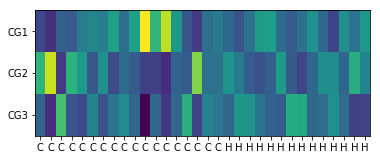

epoch 22 reconstruction  4.169 instantaneous forces 875.716  tau  3.934


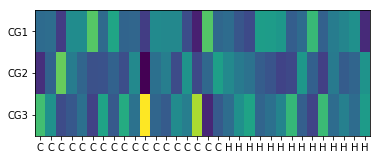

epoch 23 reconstruction  4.130 instantaneous forces 950.737  tau  3.922


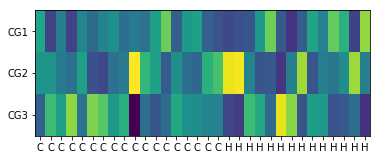

epoch 24 reconstruction  4.096 instantaneous forces 897.235  tau  3.911


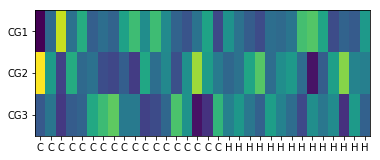

epoch 25 reconstruction  4.066 instantaneous forces 918.138  tau  3.899


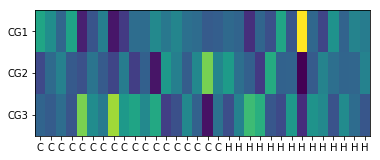

epoch 26 reconstruction  4.036 instantaneous forces 948.569  tau  3.887


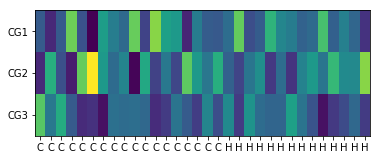

epoch 27 reconstruction  4.008 instantaneous forces 953.216  tau  3.876


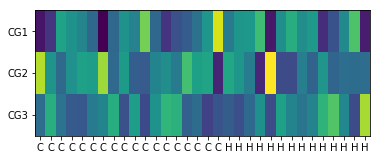

epoch 28 reconstruction  3.986 instantaneous forces 979.703  tau  3.864


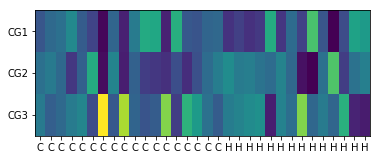

epoch 29 reconstruction  3.962 instantaneous forces 960.818  tau  3.853


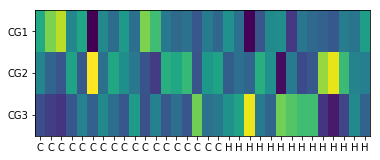

epoch 30 reconstruction  3.944 instantaneous forces 999.289  tau  3.842


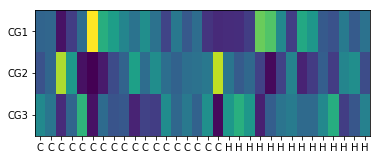

epoch 31 reconstruction  3.926 instantaneous forces 991.437  tau  3.830


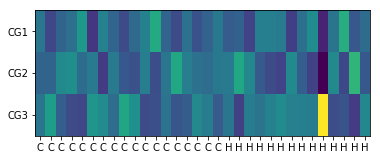

epoch 32 reconstruction  3.908 instantaneous forces 1027.624  tau  3.819


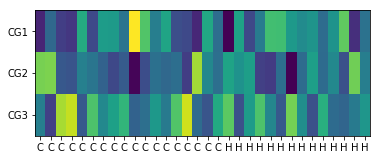

epoch 33 reconstruction  3.895 instantaneous forces 971.120  tau  3.808


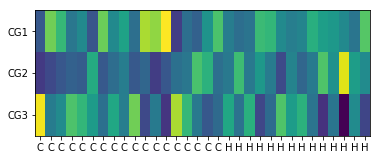

epoch 34 reconstruction  3.881 instantaneous forces 998.129  tau  3.796


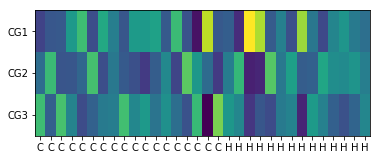

epoch 35 reconstruction  3.867 instantaneous forces 969.910  tau  3.785


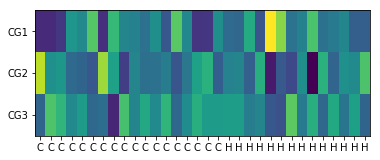

epoch 36 reconstruction  3.858 instantaneous forces 971.297  tau  3.774


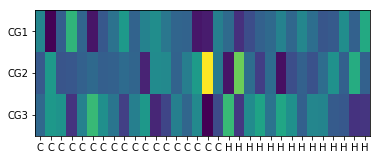

epoch 37 reconstruction  3.848 instantaneous forces 935.791  tau  3.763


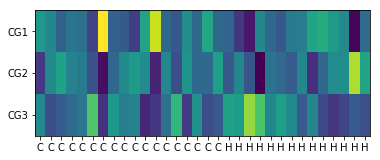

epoch 38 reconstruction  3.838 instantaneous forces 1000.299  tau  3.752


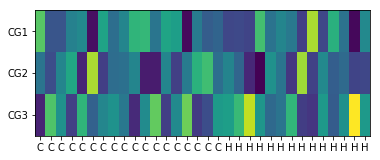

epoch 39 reconstruction  3.831 instantaneous forces 1063.651  tau  3.740


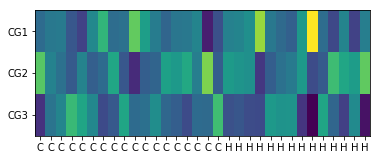

epoch 40 reconstruction  3.823 instantaneous forces 980.896  tau  3.729


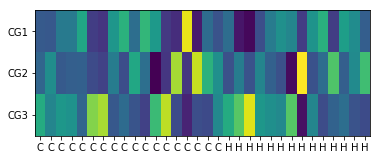

epoch 41 reconstruction  3.819 instantaneous forces 970.381  tau  3.718


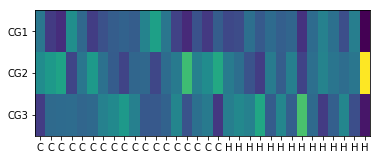

epoch 42 reconstruction  3.809 instantaneous forces 1012.189  tau  3.707


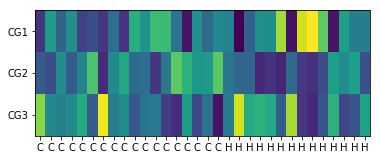

epoch 43 reconstruction  3.804 instantaneous forces 1023.679  tau  3.696


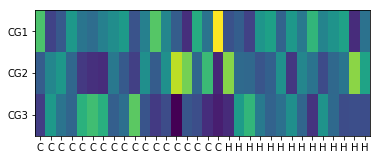

epoch 44 reconstruction  3.801 instantaneous forces 1026.721  tau  3.686


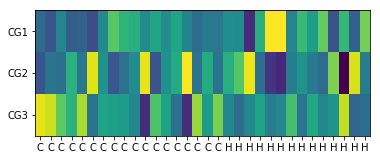

epoch 45 reconstruction  3.795 instantaneous forces 1005.632  tau  3.675


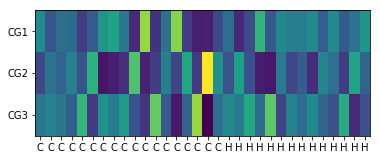

epoch 46 reconstruction  3.791 instantaneous forces 1092.813  tau  3.664


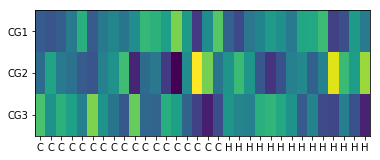

epoch 47 reconstruction  3.788 instantaneous forces 1058.058  tau  3.653


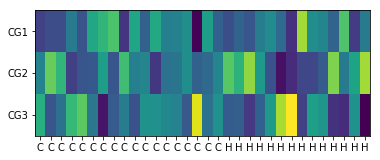

epoch 48 reconstruction  3.781 instantaneous forces 1020.199  tau  3.642


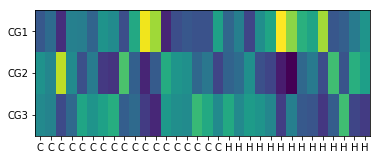

epoch 49 reconstruction  3.777 instantaneous forces 1040.833  tau  3.631


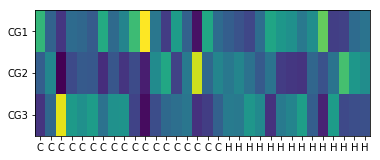

epoch 50 reconstruction  3.772 instantaneous forces 1055.608  tau  3.621


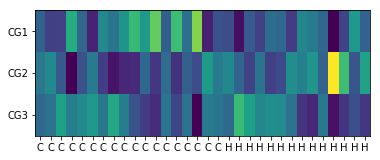

epoch 51 reconstruction  3.767 instantaneous forces 1040.412  tau  3.610


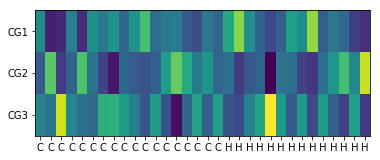

epoch 52 reconstruction  3.766 instantaneous forces 1047.911  tau  3.599


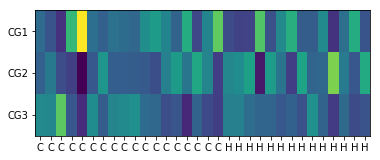

epoch 53 reconstruction  3.760 instantaneous forces 1094.231  tau  3.589


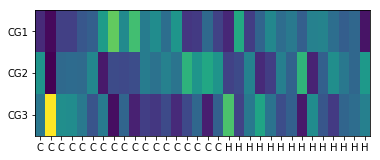

epoch 54 reconstruction  3.754 instantaneous forces 1053.415  tau  3.578


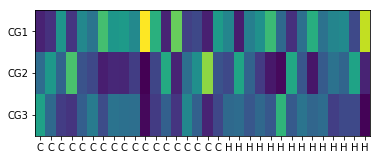

epoch 55 reconstruction  3.748 instantaneous forces 1103.145  tau  3.568


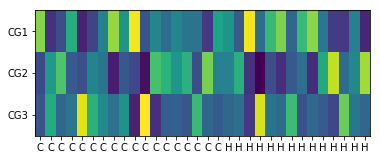

epoch 56 reconstruction  3.747 instantaneous forces 1085.518  tau  3.557


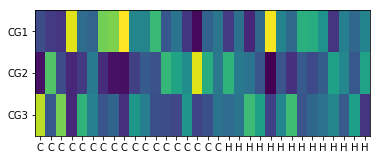

epoch 57 reconstruction  3.739 instantaneous forces 1128.088  tau  3.547


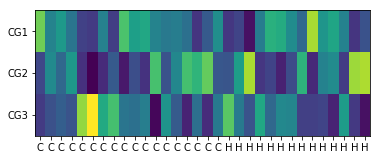

epoch 58 reconstruction  3.738 instantaneous forces 1039.841  tau  3.536


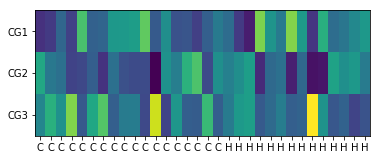

epoch 59 reconstruction  3.730 instantaneous forces 1139.332  tau  3.526


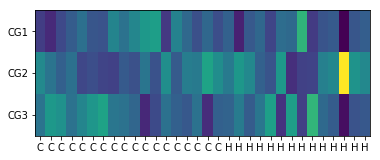

epoch 60 reconstruction  3.729 instantaneous forces 1109.785  tau  3.515


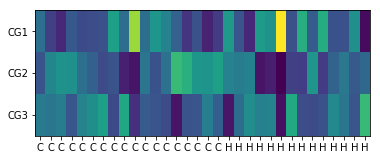

epoch 61 reconstruction  3.721 instantaneous forces 1095.903  tau  3.505


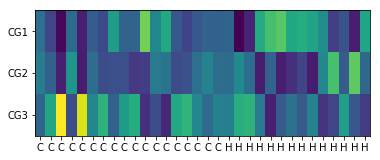

epoch 62 reconstruction  3.717 instantaneous forces 1130.086  tau  3.495


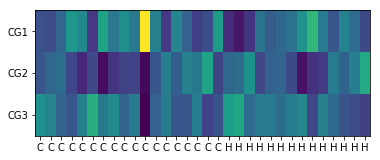

epoch 63 reconstruction  3.711 instantaneous forces 1099.720  tau  3.484


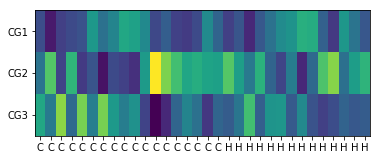

epoch 64 reconstruction  3.702 instantaneous forces 1119.326  tau  3.474


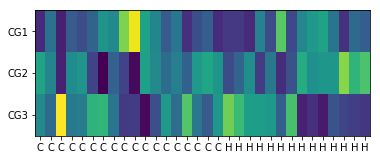

epoch 65 reconstruction  3.699 instantaneous forces 1167.112  tau  3.464


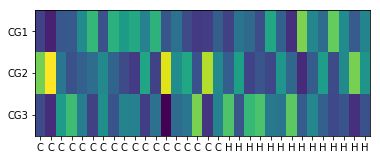

epoch 66 reconstruction  3.693 instantaneous forces 1127.538  tau  3.454


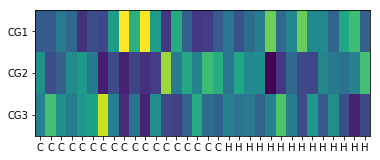

epoch 67 reconstruction  3.685 instantaneous forces 1139.531  tau  3.444


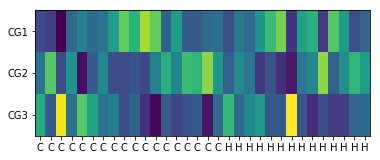

epoch 68 reconstruction  3.678 instantaneous forces 1124.601  tau  3.433


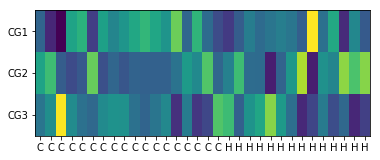

epoch 69 reconstruction  3.674 instantaneous forces 1189.551  tau  3.423


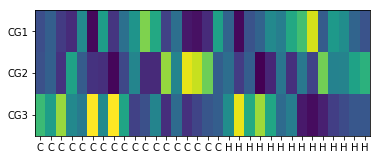

epoch 70 reconstruction  3.666 instantaneous forces 1137.527  tau  3.413


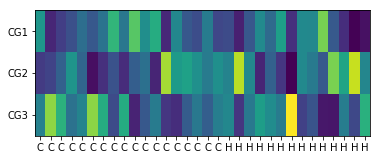

epoch 71 reconstruction  3.659 instantaneous forces 1155.574  tau  3.403


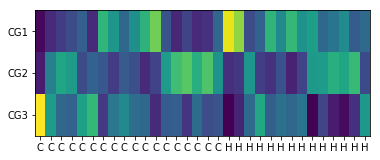

epoch 72 reconstruction  3.648 instantaneous forces 1167.580  tau  3.393


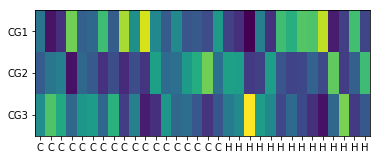

epoch 73 reconstruction  3.640 instantaneous forces 1146.145  tau  3.383


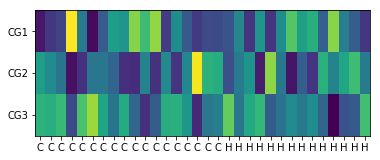

epoch 74 reconstruction  3.635 instantaneous forces 1205.619  tau  3.373


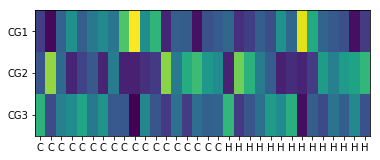

epoch 75 reconstruction  3.625 instantaneous forces 1133.002  tau  3.363


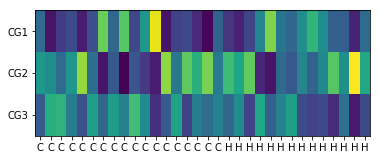

epoch 76 reconstruction  3.618 instantaneous forces 1187.238  tau  3.353


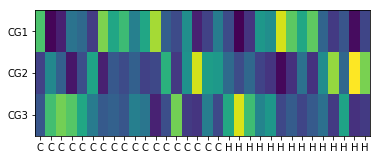

epoch 77 reconstruction  3.609 instantaneous forces 1149.398  tau  3.344


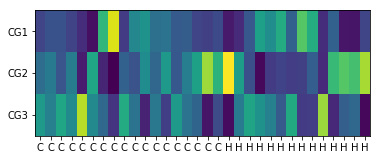

epoch 78 reconstruction  3.599 instantaneous forces 1159.493  tau  3.334


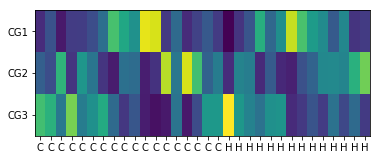

epoch 79 reconstruction  3.588 instantaneous forces 1197.748  tau  3.324


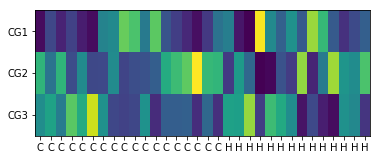

epoch 80 reconstruction  3.583 instantaneous forces 1169.436  tau  3.314


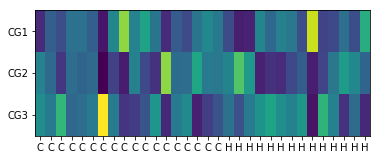

epoch 81 reconstruction  3.566 instantaneous forces 1220.257  tau  3.304


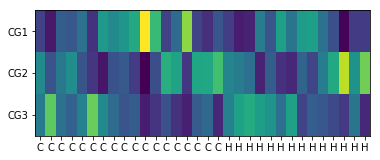

epoch 82 reconstruction  3.559 instantaneous forces 1242.919  tau  3.295


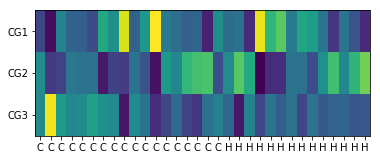

epoch 83 reconstruction  3.546 instantaneous forces 1188.734  tau  3.285


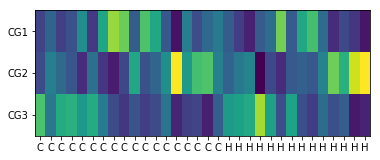

epoch 84 reconstruction  3.540 instantaneous forces 1192.989  tau  3.275


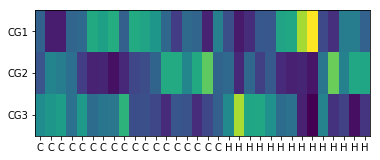

epoch 85 reconstruction  3.536 instantaneous forces 1185.214  tau  3.266


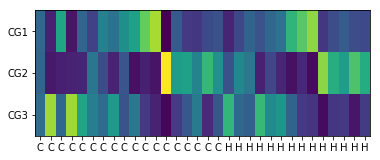

epoch 86 reconstruction  3.518 instantaneous forces 1248.600  tau  3.256


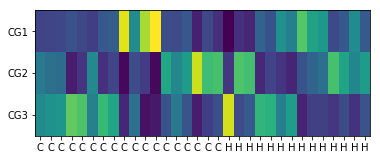

epoch 87 reconstruction  3.503 instantaneous forces 1216.623  tau  3.247


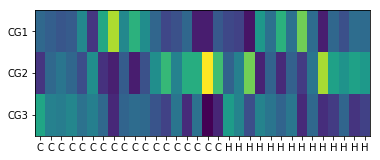

epoch 88 reconstruction  3.492 instantaneous forces 1307.493  tau  3.237


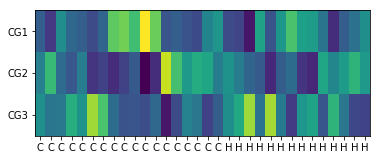

epoch 89 reconstruction  3.479 instantaneous forces 1233.907  tau  3.228


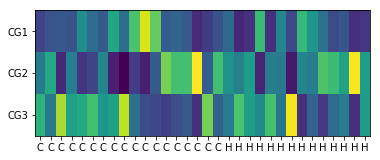

epoch 90 reconstruction  3.462 instantaneous forces 1203.112  tau  3.218


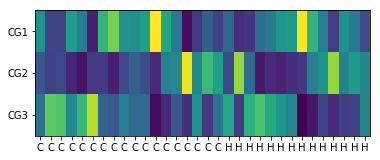

epoch 91 reconstruction  3.454 instantaneous forces 1255.658  tau  3.209


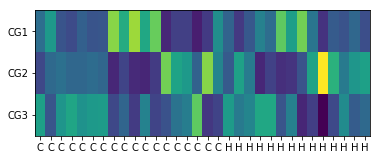

epoch 92 reconstruction  3.437 instantaneous forces 1285.179  tau  3.199


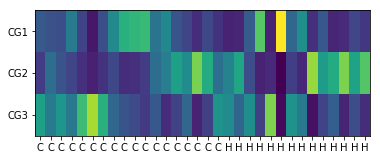

epoch 93 reconstruction  3.431 instantaneous forces 1252.061  tau  3.190


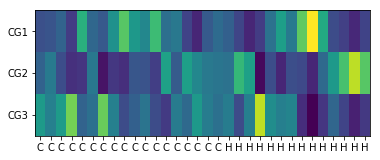

epoch 94 reconstruction  3.405 instantaneous forces 1220.075  tau  3.181


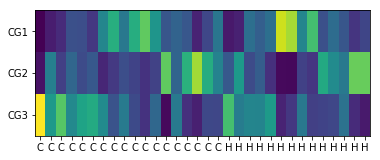

epoch 95 reconstruction  3.392 instantaneous forces 1255.682  tau  3.171


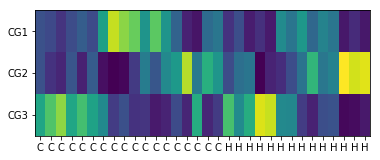

epoch 96 reconstruction  3.379 instantaneous forces 1255.866  tau  3.162


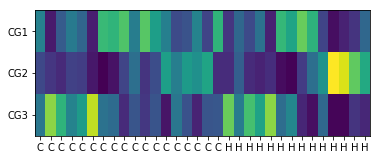

epoch 97 reconstruction  3.357 instantaneous forces 1209.927  tau  3.153


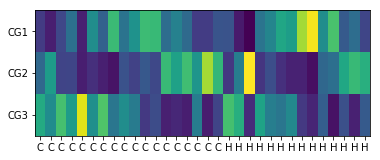

epoch 98 reconstruction  3.346 instantaneous forces 1246.011  tau  3.144


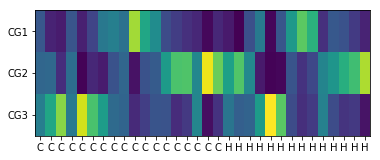

epoch 99 reconstruction  3.328 instantaneous forces 1247.583  tau  3.134


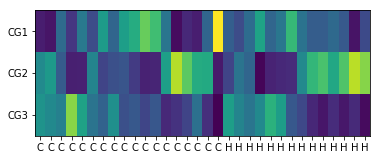

epoch 100 reconstruction  3.320 instantaneous forces 1271.005  tau  3.125


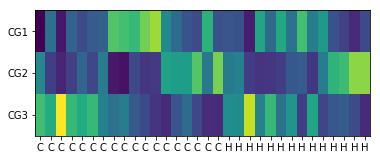

epoch 101 reconstruction  3.306 instantaneous forces 1274.024  tau  3.116


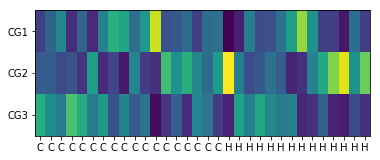

epoch 102 reconstruction  3.287 instantaneous forces 1338.233  tau  3.107


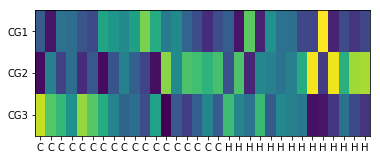

epoch 103 reconstruction  3.255 instantaneous forces 1280.306  tau  3.098


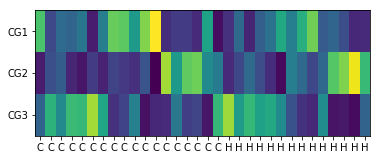

epoch 104 reconstruction  3.248 instantaneous forces 1289.548  tau  3.089


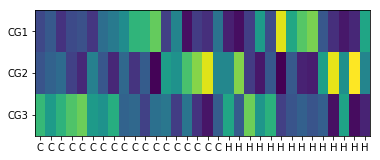

epoch 105 reconstruction  3.228 instantaneous forces 1221.264  tau  3.080


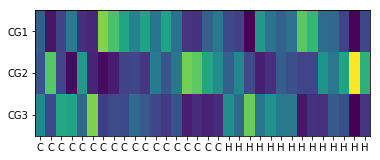

epoch 106 reconstruction  3.206 instantaneous forces 1315.686  tau  3.071


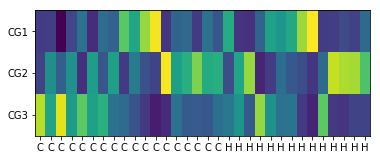

epoch 107 reconstruction  3.181 instantaneous forces 1304.300  tau  3.062


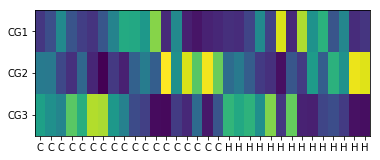

epoch 108 reconstruction  3.169 instantaneous forces 1225.310  tau  3.053


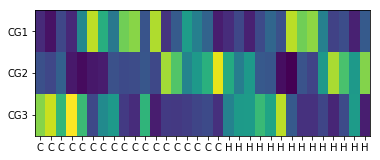

epoch 109 reconstruction  3.155 instantaneous forces 1307.584  tau  3.044


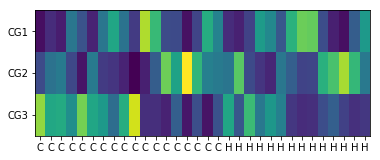

epoch 110 reconstruction  3.125 instantaneous forces 1346.400  tau  3.035


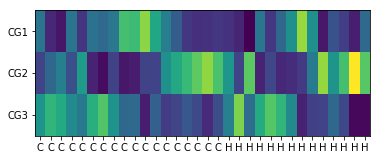

epoch 111 reconstruction  3.109 instantaneous forces 1347.485  tau  3.026


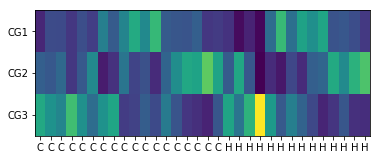

epoch 112 reconstruction  3.093 instantaneous forces 1258.964  tau  3.018


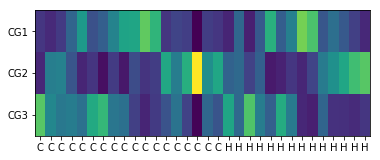

epoch 113 reconstruction  3.067 instantaneous forces 1328.633  tau  3.009


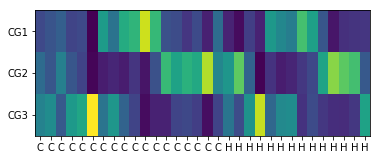

epoch 114 reconstruction  3.039 instantaneous forces 1224.373  tau  3.000


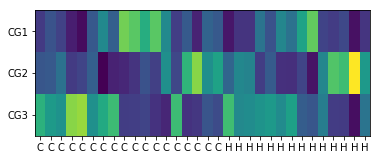

epoch 115 reconstruction  3.028 instantaneous forces 1282.088  tau  2.991


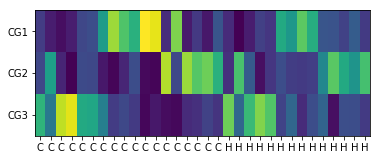

epoch 116 reconstruction  2.998 instantaneous forces 1275.087  tau  2.982


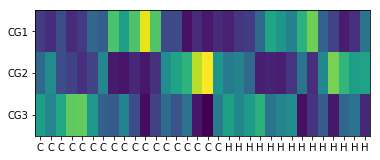

epoch 117 reconstruction  2.972 instantaneous forces 1365.553  tau  2.974


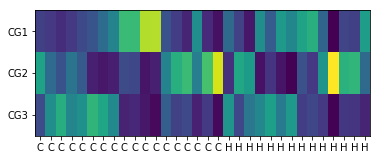

epoch 118 reconstruction  2.955 instantaneous forces 1259.540  tau  2.965


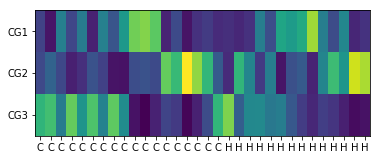

epoch 119 reconstruction  2.922 instantaneous forces 1251.962  tau  2.956


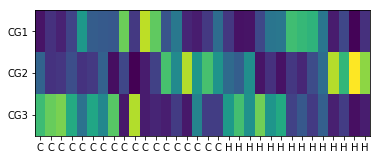

epoch 120 reconstruction  2.916 instantaneous forces 1254.608  tau  2.948


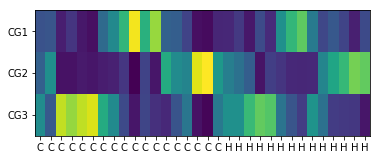

epoch 121 reconstruction  2.872 instantaneous forces 1266.047  tau  2.939


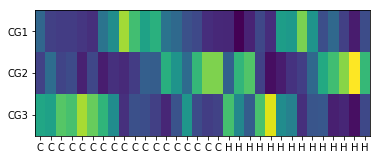

epoch 122 reconstruction  2.854 instantaneous forces 1313.330  tau  2.931


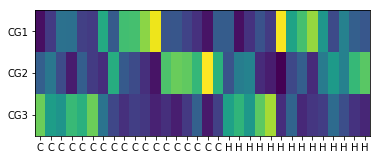

epoch 123 reconstruction  2.823 instantaneous forces 1299.834  tau  2.922


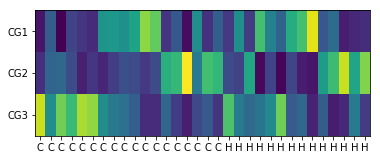

epoch 124 reconstruction  2.811 instantaneous forces 1364.220  tau  2.914


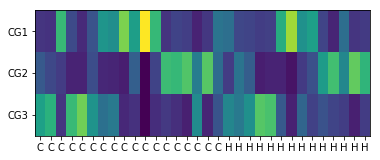

epoch 125 reconstruction  2.788 instantaneous forces 1336.823  tau  2.905


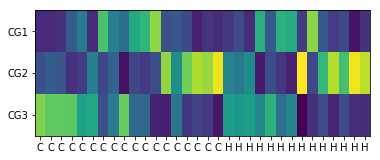

epoch 126 reconstruction  2.754 instantaneous forces 1301.619  tau  2.897


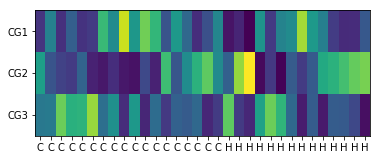

epoch 127 reconstruction  2.730 instantaneous forces 1242.156  tau  2.888


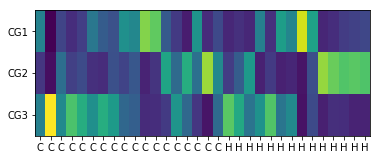

epoch 128 reconstruction  2.708 instantaneous forces 1225.902  tau  2.880


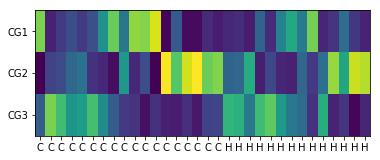

epoch 129 reconstruction  2.686 instantaneous forces 1235.968  tau  2.872


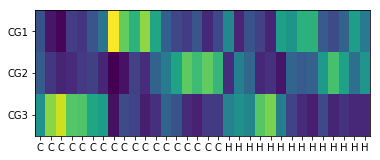

epoch 130 reconstruction  2.653 instantaneous forces 1269.009  tau  2.863


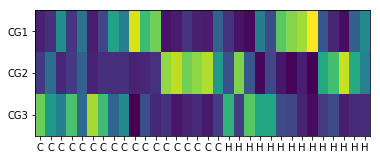

epoch 131 reconstruction  2.622 instantaneous forces 1302.702  tau  2.855


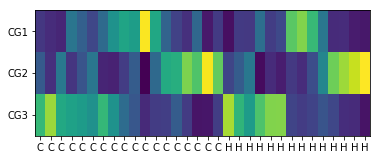

epoch 132 reconstruction  2.594 instantaneous forces 1263.677  tau  2.847


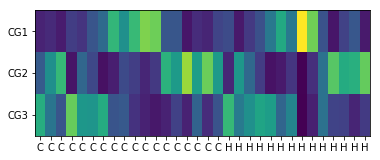

epoch 133 reconstruction  2.568 instantaneous forces 1290.241  tau  2.838


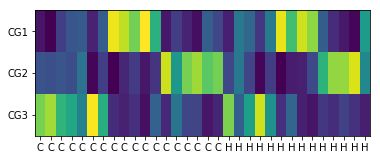

epoch 134 reconstruction  2.544 instantaneous forces 1329.813  tau  2.830


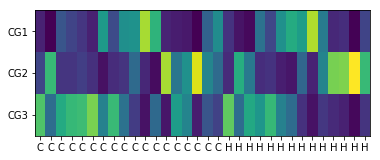

epoch 135 reconstruction  2.512 instantaneous forces 1299.270  tau  2.822


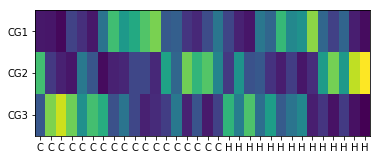

epoch 136 reconstruction  2.478 instantaneous forces 1279.884  tau  2.814


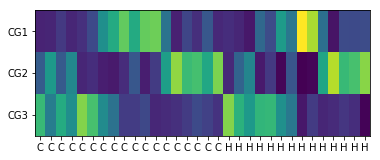

epoch 137 reconstruction  2.467 instantaneous forces 1271.960  tau  2.806


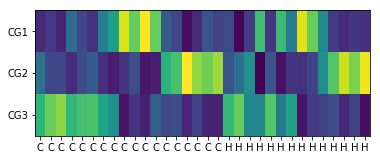

epoch 138 reconstruction  2.420 instantaneous forces 1240.044  tau  2.797


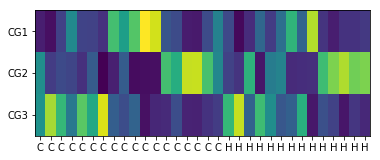

epoch 139 reconstruction  2.408 instantaneous forces 1238.536  tau  2.789


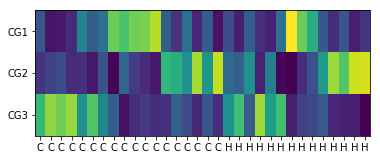

epoch 140 reconstruction  2.367 instantaneous forces 1310.264  tau  2.781


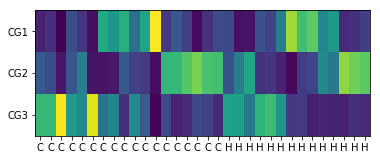

epoch 141 reconstruction  2.339 instantaneous forces 1246.636  tau  2.773


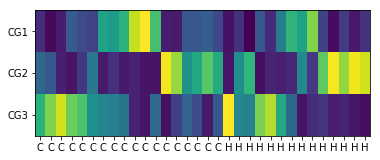

epoch 142 reconstruction  2.314 instantaneous forces 1257.486  tau  2.765


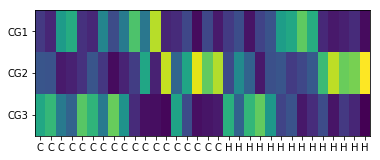

epoch 143 reconstruction  2.276 instantaneous forces 1334.044  tau  2.757


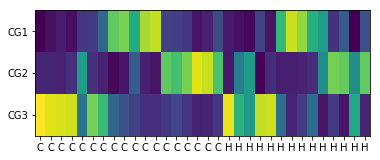

epoch 144 reconstruction  2.252 instantaneous forces 1255.666  tau  2.749


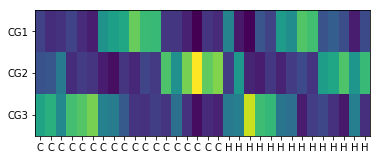

epoch 145 reconstruction  2.223 instantaneous forces 1244.099  tau  2.741


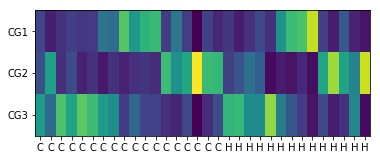

epoch 146 reconstruction  2.190 instantaneous forces 1308.993  tau  2.733


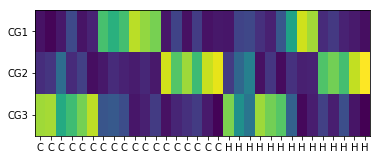

epoch 147 reconstruction  2.160 instantaneous forces 1296.399  tau  2.725


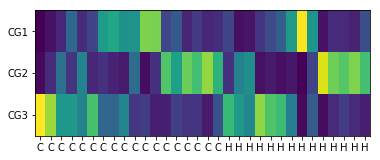

epoch 148 reconstruction  2.131 instantaneous forces 1278.613  tau  2.717


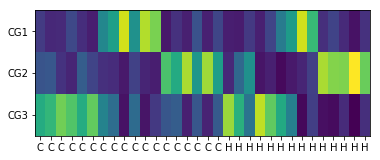

epoch 149 reconstruction  2.100 instantaneous forces 1353.250  tau  2.710


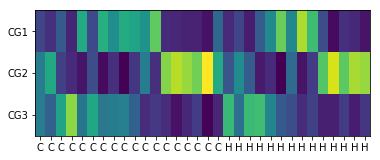

epoch 150 reconstruction  2.068 instantaneous forces 1251.961  tau  2.702


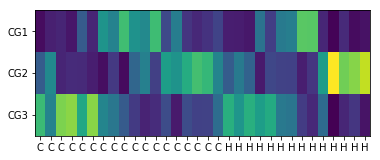

epoch 151 reconstruction  2.036 instantaneous forces 1262.456  tau  2.694


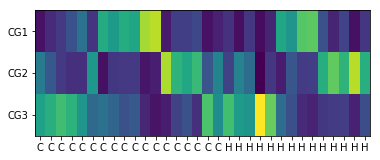

epoch 152 reconstruction  2.002 instantaneous forces 1287.270  tau  2.686


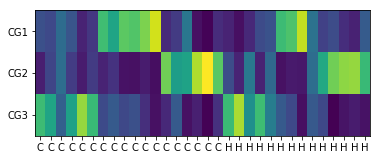

epoch 153 reconstruction  1.973 instantaneous forces 1286.858  tau  2.678


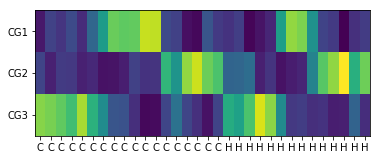

epoch 154 reconstruction  1.961 instantaneous forces 1260.278  tau  2.671


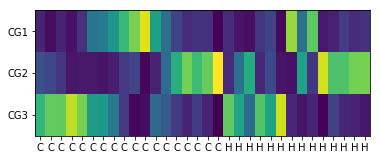

epoch 155 reconstruction  1.917 instantaneous forces 1247.520  tau  2.663


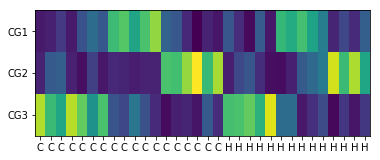

epoch 156 reconstruction  1.880 instantaneous forces 1262.564  tau  2.655


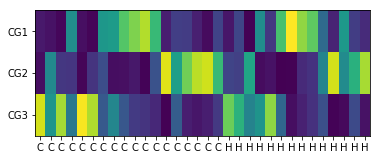

epoch 157 reconstruction  1.868 instantaneous forces 1242.597  tau  2.647


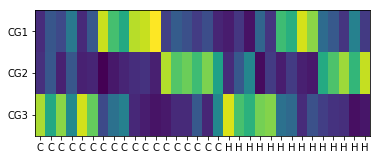

epoch 158 reconstruction  1.826 instantaneous forces 1251.594  tau  2.640


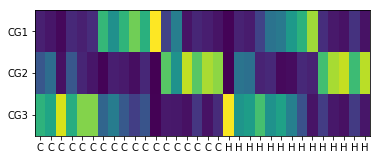

epoch 159 reconstruction  1.797 instantaneous forces 1227.522  tau  2.632


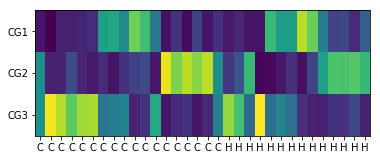

epoch 160 reconstruction  1.758 instantaneous forces 1184.309  tau  2.625


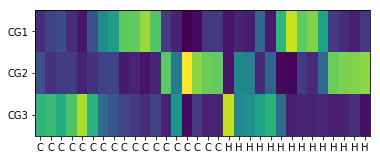

epoch 161 reconstruction  1.741 instantaneous forces 1266.486  tau  2.617


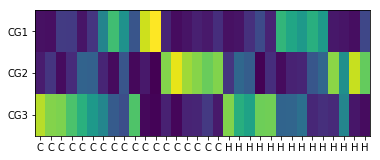

epoch 162 reconstruction  1.708 instantaneous forces 1245.181  tau  2.609


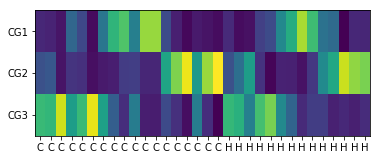

epoch 163 reconstruction  1.671 instantaneous forces 1235.451  tau  2.602


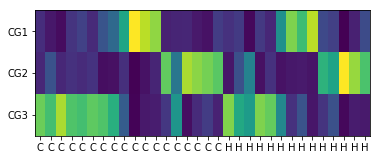

epoch 164 reconstruction  1.659 instantaneous forces 1214.325  tau  2.594


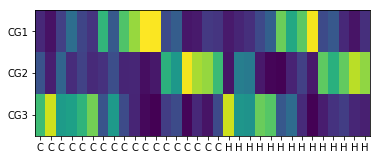

epoch 165 reconstruction  1.622 instantaneous forces 1193.843  tau  2.587


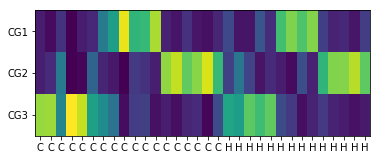

epoch 166 reconstruction  1.600 instantaneous forces 1189.656  tau  2.580


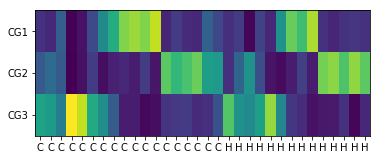

epoch 167 reconstruction  1.562 instantaneous forces 1241.747  tau  2.572


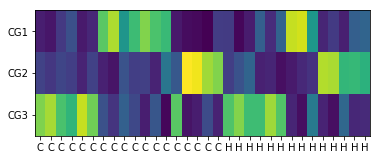

epoch 168 reconstruction  1.535 instantaneous forces 1207.669  tau  2.565


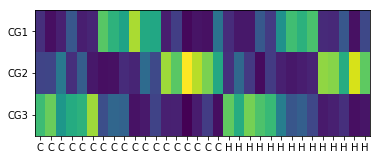

epoch 169 reconstruction  1.495 instantaneous forces 1217.349  tau  2.557


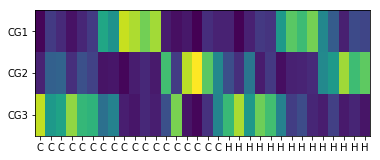

epoch 170 reconstruction  1.493 instantaneous forces 1181.741  tau  2.550


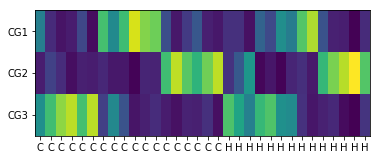

epoch 171 reconstruction  1.459 instantaneous forces 1197.014  tau  2.543


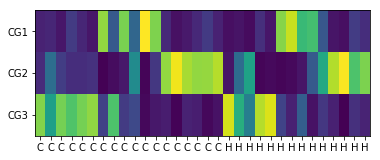

epoch 172 reconstruction  1.424 instantaneous forces 1239.609  tau  2.535


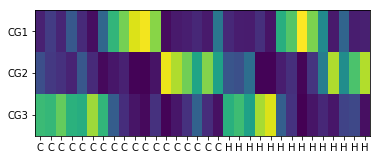

epoch 173 reconstruction  1.394 instantaneous forces 1213.604  tau  2.528


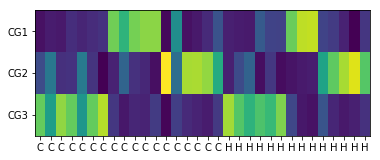

epoch 174 reconstruction  1.372 instantaneous forces 1235.240  tau  2.521


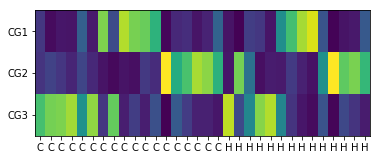

epoch 175 reconstruction  1.343 instantaneous forces 1204.504  tau  2.513


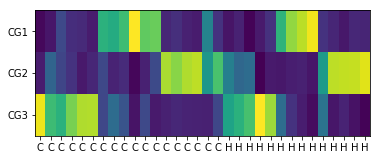

epoch 176 reconstruction  1.317 instantaneous forces 1162.756  tau  2.506


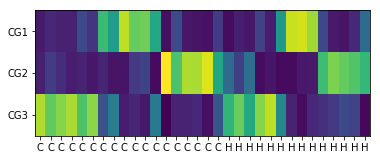

epoch 177 reconstruction  1.279 instantaneous forces 1147.865  tau  2.499


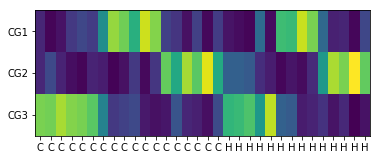

epoch 178 reconstruction  1.263 instantaneous forces 1232.373  tau  2.492


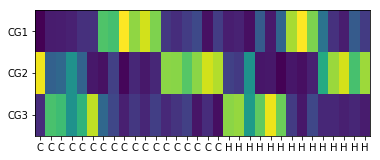

epoch 179 reconstruction  1.234 instantaneous forces 1209.090  tau  2.485


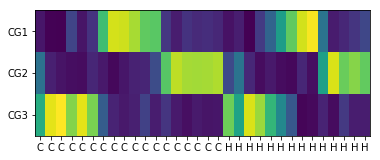

epoch 180 reconstruction  1.213 instantaneous forces 1139.422  tau  2.478


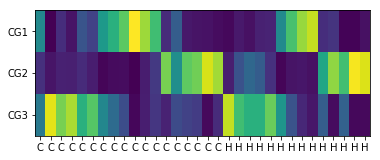

epoch 181 reconstruction  1.180 instantaneous forces 1172.297  tau  2.470


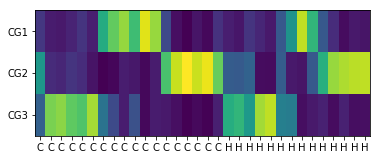

epoch 182 reconstruction  1.160 instantaneous forces 1196.488  tau  2.463


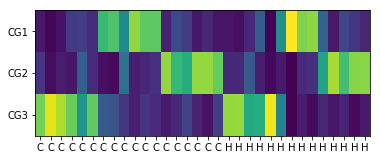

epoch 183 reconstruction  1.148 instantaneous forces 1247.217  tau  2.456


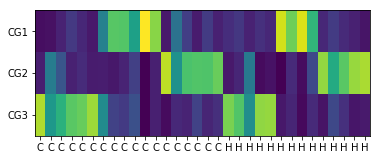

epoch 184 reconstruction  1.105 instantaneous forces 1188.301  tau  2.449


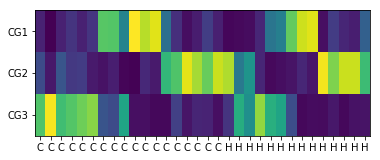

epoch 185 reconstruction  1.087 instantaneous forces 1174.831  tau  2.442


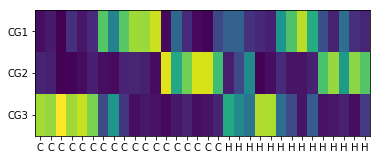

epoch 186 reconstruction  1.067 instantaneous forces 1152.541  tau  2.435


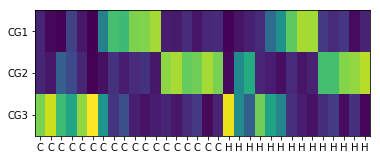

epoch 187 reconstruction  1.032 instantaneous forces 1207.932  tau  2.428


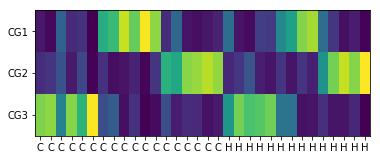

epoch 188 reconstruction  1.029 instantaneous forces 1203.136  tau  2.421


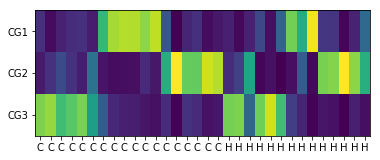

epoch 189 reconstruction  0.996 instantaneous forces 1194.511  tau  2.414


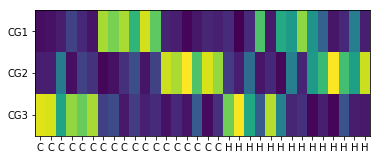

epoch 190 reconstruction  0.976 instantaneous forces 1166.787  tau  2.407


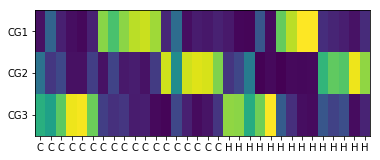

epoch 191 reconstruction  0.959 instantaneous forces 1222.973  tau  2.400


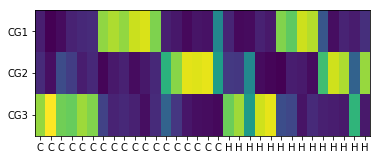

epoch 192 reconstruction  0.937 instantaneous forces 1192.229  tau  2.394


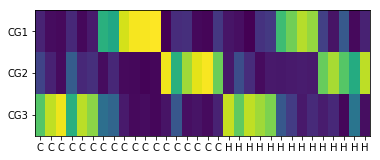

epoch 193 reconstruction  0.912 instantaneous forces 1222.325  tau  2.387


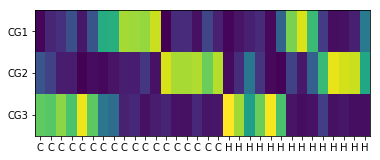

epoch 194 reconstruction  0.893 instantaneous forces 1190.086  tau  2.380


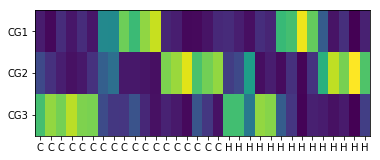

epoch 195 reconstruction  0.869 instantaneous forces 1226.950  tau  2.373


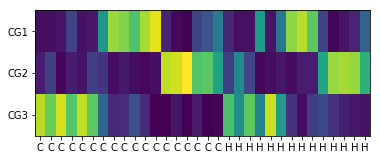

epoch 196 reconstruction  0.857 instantaneous forces 1236.140  tau  2.366


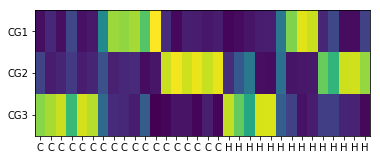

epoch 197 reconstruction  0.831 instantaneous forces 1126.723  tau  2.360


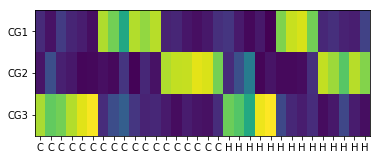

epoch 198 reconstruction  0.813 instantaneous forces 1196.619  tau  2.353


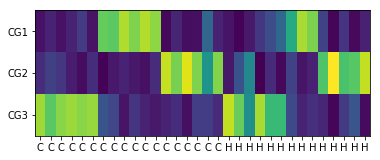

epoch 199 reconstruction  0.802 instantaneous forces 1180.005  tau  2.346


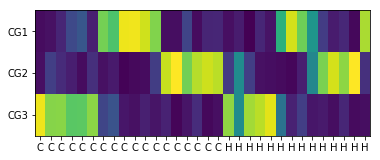

epoch 200 reconstruction  0.778 instantaneous forces 1187.962  tau  2.339


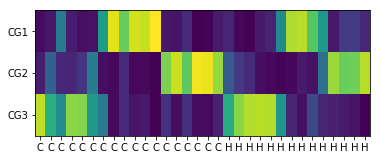

epoch 201 reconstruction  0.767 instantaneous forces 1143.426  tau  2.333


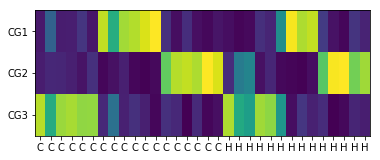

epoch 202 reconstruction  0.745 instantaneous forces 1208.194  tau  2.326


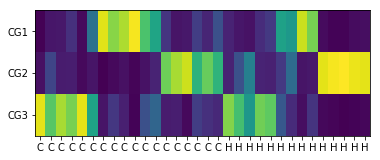

epoch 203 reconstruction  0.730 instantaneous forces 1173.974  tau  2.319


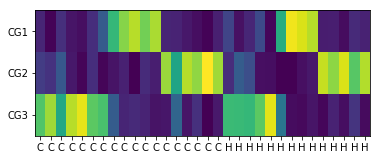

epoch 204 reconstruction  0.718 instantaneous forces 1150.799  tau  2.313


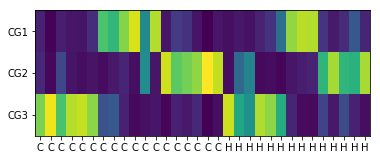

epoch 205 reconstruction  0.697 instantaneous forces 1161.087  tau  2.306


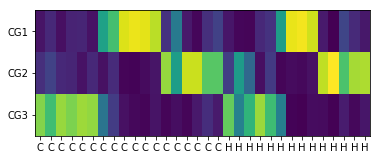

epoch 206 reconstruction  0.683 instantaneous forces 1123.390  tau  2.300


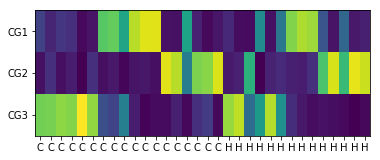

epoch 207 reconstruction  0.676 instantaneous forces 1211.943  tau  2.293


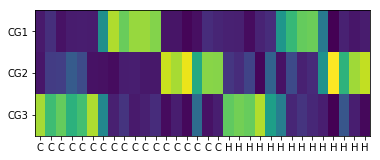

epoch 208 reconstruction  0.649 instantaneous forces 1187.577  tau  2.286


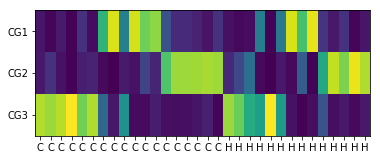

epoch 209 reconstruction  0.640 instantaneous forces 1226.109  tau  2.280


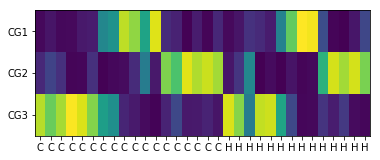

epoch 210 reconstruction  0.627 instantaneous forces 1159.229  tau  2.273


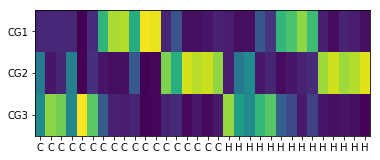

epoch 211 reconstruction  0.608 instantaneous forces 1172.849  tau  2.267


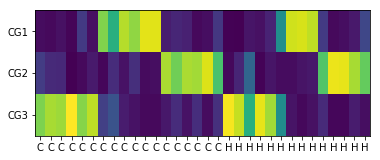

epoch 212 reconstruction  0.600 instantaneous forces 1172.851  tau  2.261


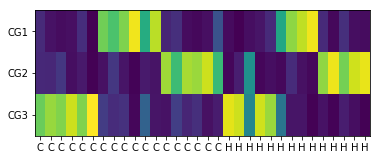

epoch 213 reconstruction  0.589 instantaneous forces 1163.316  tau  2.254


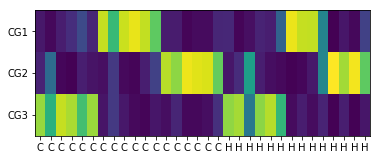

epoch 214 reconstruction  0.573 instantaneous forces 1144.425  tau  2.248


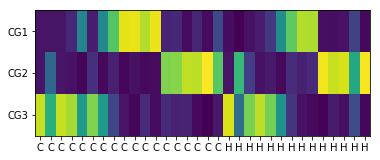

epoch 215 reconstruction  0.561 instantaneous forces 1209.146  tau  2.241


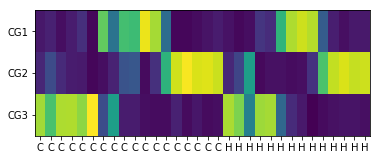

epoch 216 reconstruction  0.560 instantaneous forces 1184.193  tau  2.235


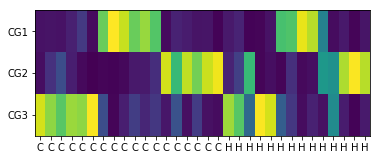

epoch 217 reconstruction  0.546 instantaneous forces 1172.546  tau  2.229


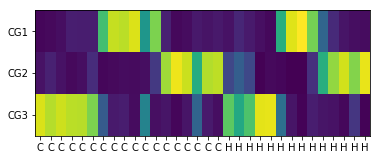

epoch 218 reconstruction  0.537 instantaneous forces 1140.734  tau  2.222


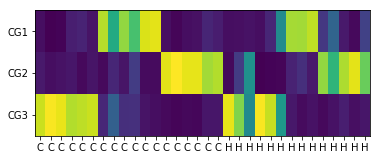

epoch 219 reconstruction  0.521 instantaneous forces 1188.876  tau  2.216


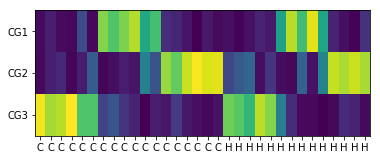

epoch 220 reconstruction  0.515 instantaneous forces 1172.535  tau  2.210


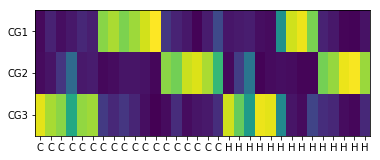

epoch 221 reconstruction  0.506 instantaneous forces 1195.840  tau  2.203


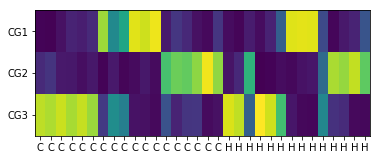

epoch 222 reconstruction  0.493 instantaneous forces 1209.365  tau  2.197


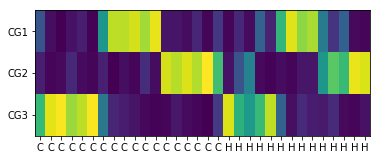

epoch 223 reconstruction  0.487 instantaneous forces 1213.293  tau  2.191


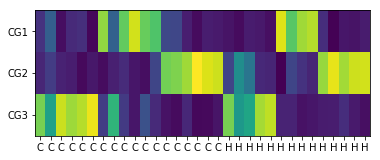

epoch 224 reconstruction  0.478 instantaneous forces 1178.304  tau  2.185


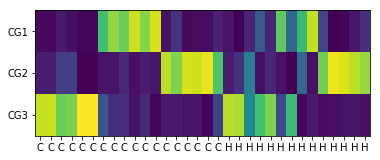

epoch 225 reconstruction  0.466 instantaneous forces 1200.496  tau  2.178


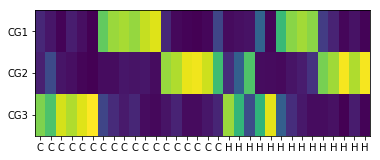

epoch 226 reconstruction  0.465 instantaneous forces 1185.876  tau  2.172


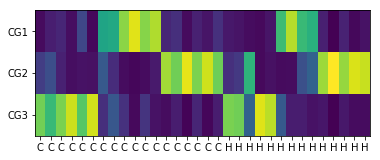

epoch 227 reconstruction  0.454 instantaneous forces 1184.356  tau  2.166


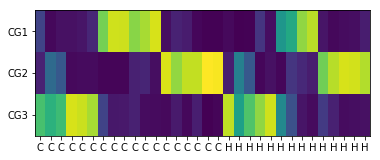

epoch 228 reconstruction  0.450 instantaneous forces 1212.136  tau  2.160


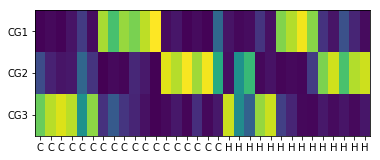

epoch 229 reconstruction  0.442 instantaneous forces 1208.407  tau  2.154


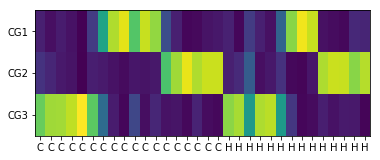

epoch 230 reconstruction  0.439 instantaneous forces 1152.653  tau  2.148


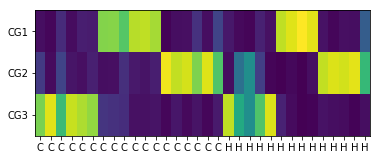

epoch 231 reconstruction  0.430 instantaneous forces 1218.485  tau  2.142


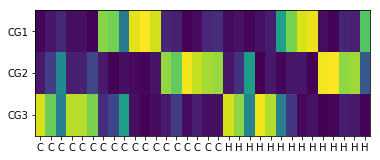

epoch 232 reconstruction  0.426 instantaneous forces 1144.836  tau  2.136


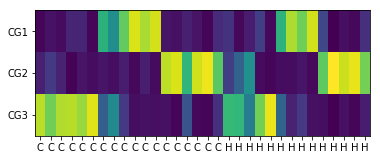

epoch 233 reconstruction  0.418 instantaneous forces 1217.820  tau  2.129


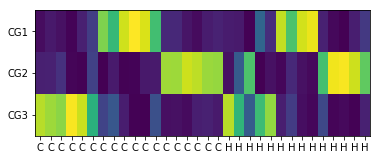

epoch 234 reconstruction  0.411 instantaneous forces 1243.430  tau  2.123


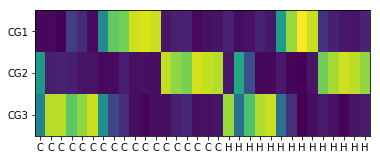

epoch 235 reconstruction  0.408 instantaneous forces 1204.589  tau  2.117


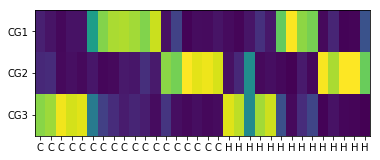

epoch 236 reconstruction  0.404 instantaneous forces 1203.146  tau  2.111


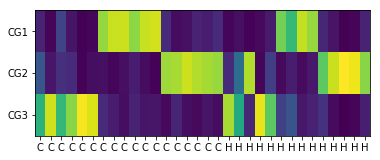

epoch 237 reconstruction  0.401 instantaneous forces 1179.093  tau  2.105


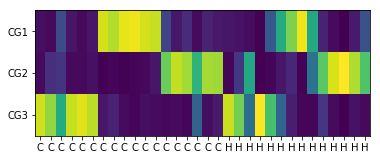

epoch 238 reconstruction  0.396 instantaneous forces 1186.638  tau  2.100


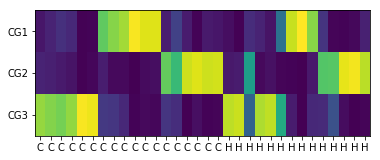

epoch 239 reconstruction  0.392 instantaneous forces 1193.048  tau  2.094


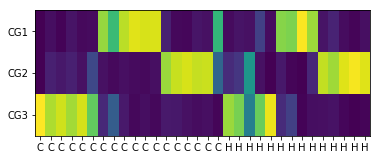

epoch 240 reconstruction  0.390 instantaneous forces 1215.132  tau  2.088


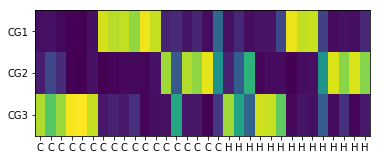

epoch 241 reconstruction  0.388 instantaneous forces 1170.890  tau  2.082


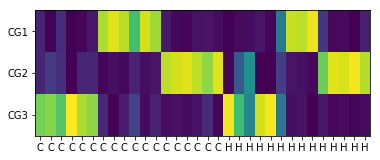

epoch 242 reconstruction  0.383 instantaneous forces 1186.851  tau  2.076


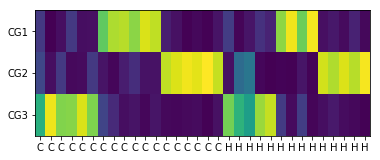

epoch 243 reconstruction  0.379 instantaneous forces 1183.859  tau  2.070


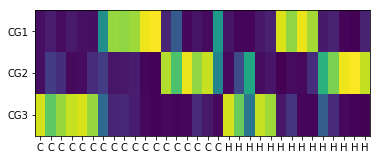

epoch 244 reconstruction  0.377 instantaneous forces 1263.041  tau  2.064


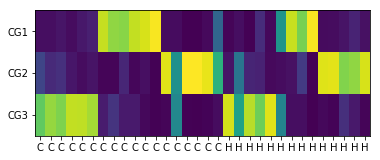

epoch 245 reconstruction  0.373 instantaneous forces 1232.219  tau  2.058


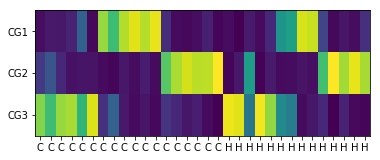

epoch 246 reconstruction  0.370 instantaneous forces 1223.498  tau  2.053


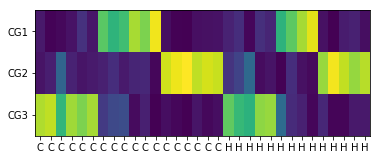

epoch 247 reconstruction  0.367 instantaneous forces 1255.232  tau  2.047


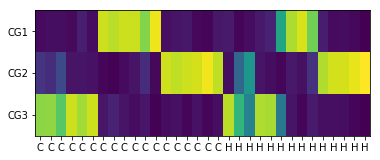

epoch 248 reconstruction  0.368 instantaneous forces 1248.554  tau  2.041


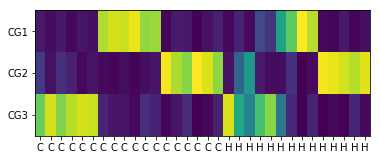

epoch 249 reconstruction  0.368 instantaneous forces 1204.585  tau  2.035


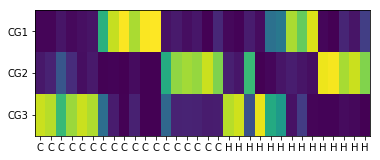

epoch 250 reconstruction  0.364 instantaneous forces 1204.141  tau  2.030


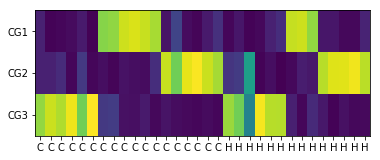

epoch 251 reconstruction  0.359 instantaneous forces 1228.542  tau  2.024


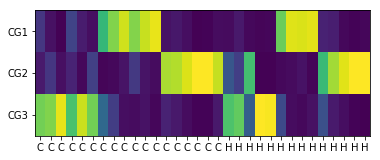

epoch 252 reconstruction  0.359 instantaneous forces 1227.562  tau  2.018


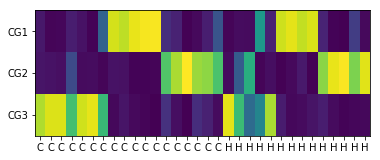

epoch 253 reconstruction  0.355 instantaneous forces 1191.862  tau  2.012


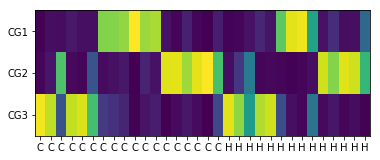

epoch 254 reconstruction  0.357 instantaneous forces 1285.401  tau  2.007


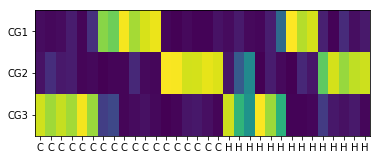

epoch 255 reconstruction  0.356 instantaneous forces 1266.826  tau  2.001


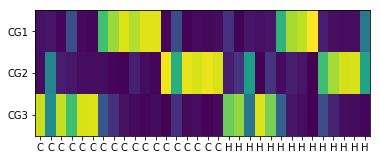

epoch 256 reconstruction  0.354 instantaneous forces 1223.193  tau  1.996


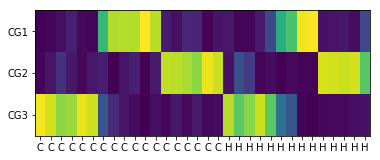

epoch 257 reconstruction  0.352 instantaneous forces 1209.961  tau  1.990


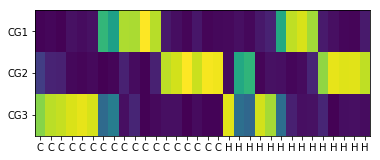

epoch 258 reconstruction  0.352 instantaneous forces 1264.659  tau  1.984


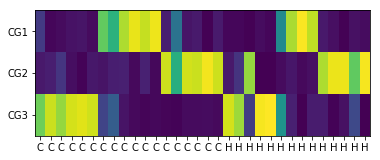

epoch 259 reconstruction  0.351 instantaneous forces 1247.448  tau  1.979


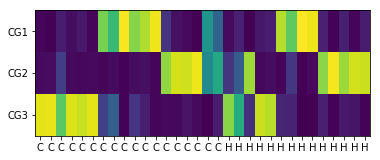

epoch 260 reconstruction  0.350 instantaneous forces 1226.678  tau  1.973


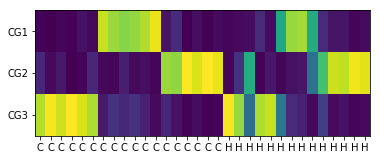

epoch 261 reconstruction  0.348 instantaneous forces 1266.309  tau  1.968


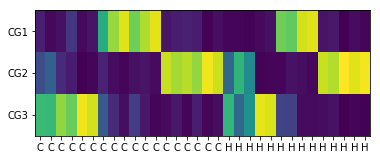

epoch 262 reconstruction  0.351 instantaneous forces 1287.882  tau  1.962


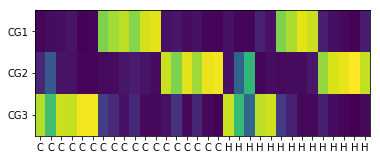

epoch 263 reconstruction  0.347 instantaneous forces 1205.498  tau  1.957


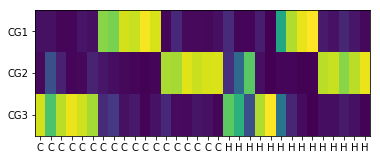

epoch 264 reconstruction  0.347 instantaneous forces 1261.674  tau  1.951


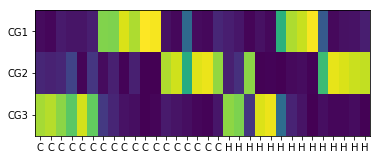

epoch 265 reconstruction  0.348 instantaneous forces 1241.523  tau  1.946


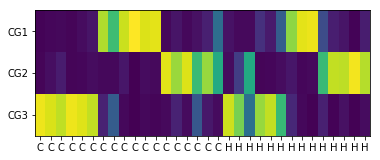

epoch 266 reconstruction  0.347 instantaneous forces 1245.312  tau  1.940


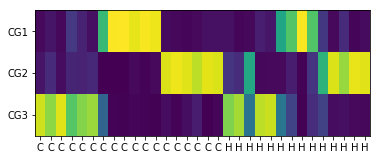

epoch 267 reconstruction  0.344 instantaneous forces 1268.770  tau  1.935


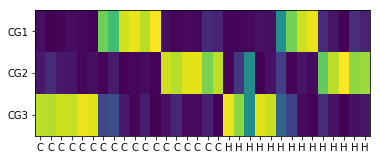

epoch 268 reconstruction  0.346 instantaneous forces 1179.110  tau  1.929


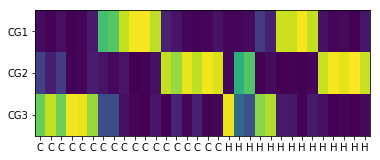

epoch 269 reconstruction  0.344 instantaneous forces 1215.909  tau  1.924


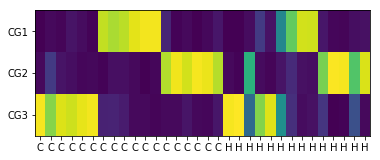

epoch 270 reconstruction  0.345 instantaneous forces 1232.312  tau  1.919


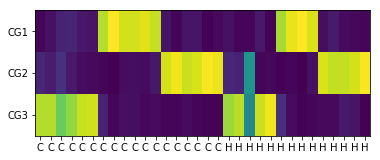

epoch 271 reconstruction  0.344 instantaneous forces 1292.403  tau  1.913


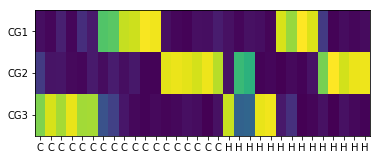

epoch 272 reconstruction  0.344 instantaneous forces 1265.176  tau  1.908


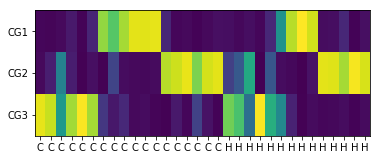

epoch 273 reconstruction  0.342 instantaneous forces 1336.584  tau  1.903


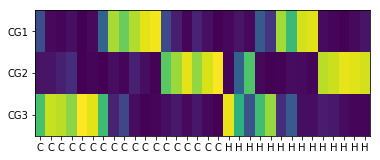

epoch 274 reconstruction  0.343 instantaneous forces 1309.034  tau  1.897


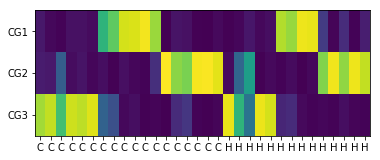

epoch 275 reconstruction  0.342 instantaneous forces 1291.526  tau  1.892


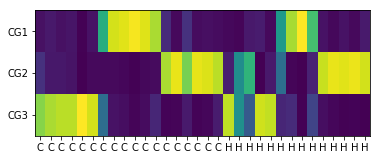

epoch 276 reconstruction  0.343 instantaneous forces 1348.586  tau  1.887


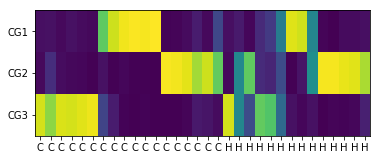

epoch 277 reconstruction  0.342 instantaneous forces 1252.693  tau  1.881


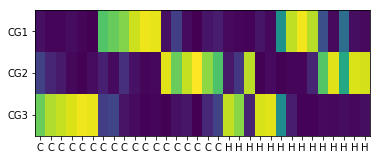

epoch 278 reconstruction  0.342 instantaneous forces 1294.388  tau  1.876


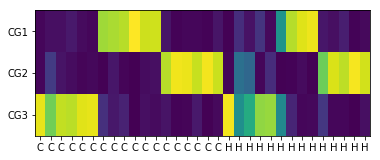

epoch 279 reconstruction  0.342 instantaneous forces 1328.943  tau  1.871


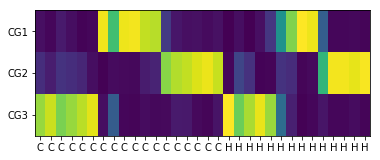

epoch 280 reconstruction  0.341 instantaneous forces 1314.264  tau  1.866


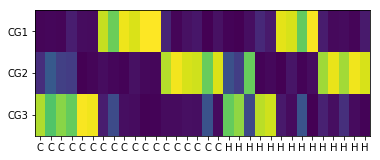

epoch 281 reconstruction  0.341 instantaneous forces 1331.580  tau  1.860


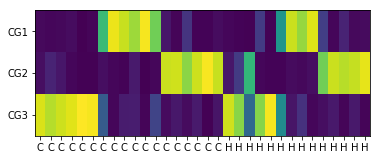

epoch 282 reconstruction  0.341 instantaneous forces 1286.639  tau  1.855


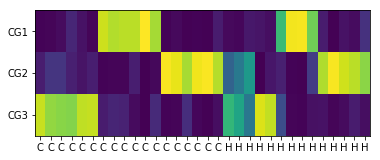

epoch 283 reconstruction  0.340 instantaneous forces 1387.038  tau  1.850


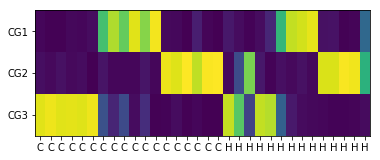

epoch 284 reconstruction  0.341 instantaneous forces 1345.755  tau  1.845


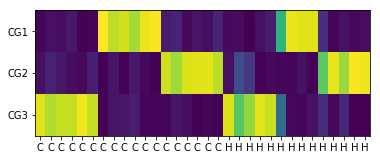

epoch 285 reconstruction  0.339 instantaneous forces 1335.408  tau  1.840


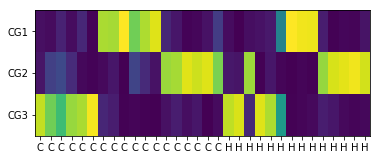

epoch 286 reconstruction  0.341 instantaneous forces 1296.500  tau  1.835


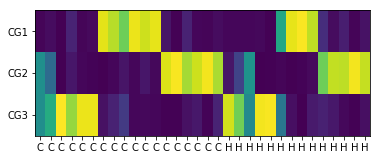

epoch 287 reconstruction  0.340 instantaneous forces 1329.307  tau  1.830


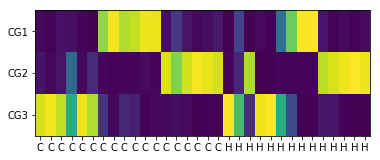

epoch 288 reconstruction  0.339 instantaneous forces 1326.173  tau  1.824


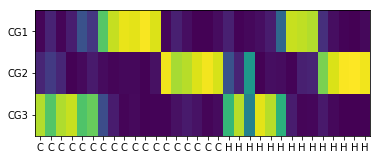

epoch 289 reconstruction  0.340 instantaneous forces 1289.377  tau  1.819


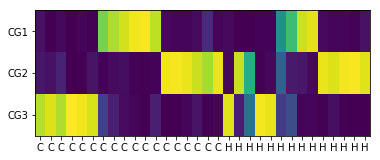

epoch 290 reconstruction  0.340 instantaneous forces 1307.299  tau  1.814


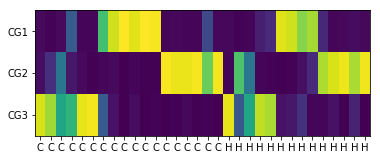

epoch 291 reconstruction  0.340 instantaneous forces 1325.126  tau  1.809


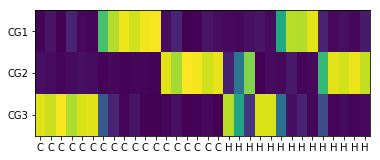

epoch 292 reconstruction  0.341 instantaneous forces 1368.406  tau  1.804


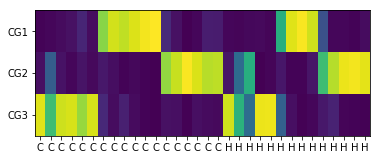

epoch 293 reconstruction  0.338 instantaneous forces 1303.044  tau  1.799


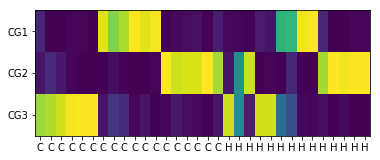

epoch 294 reconstruction  0.339 instantaneous forces 1366.913  tau  1.794


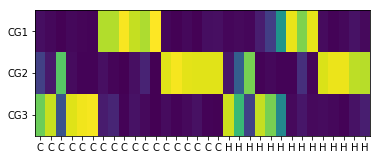

epoch 295 reconstruction  0.339 instantaneous forces 1329.027  tau  1.789


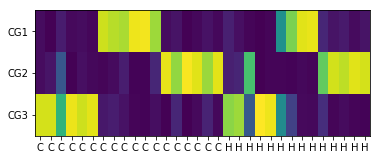

epoch 296 reconstruction  0.338 instantaneous forces 1335.166  tau  1.784


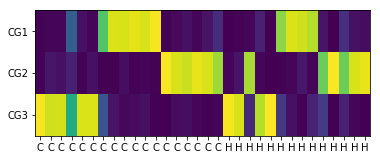

epoch 297 reconstruction  0.338 instantaneous forces 1356.811  tau  1.779


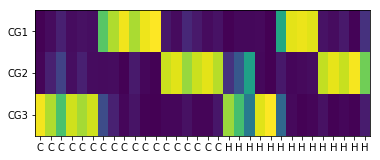

epoch 298 reconstruction  0.337 instantaneous forces 1434.153  tau  1.774


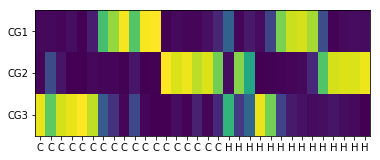

epoch 299 reconstruction  0.338 instantaneous forces 1361.255  tau  1.769


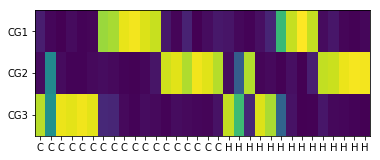

epoch 300 reconstruction  0.338 instantaneous forces 1378.485  tau  1.765


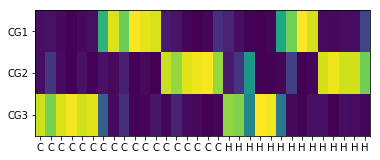

epoch 301 reconstruction  0.338 instantaneous forces 1318.409  tau  1.760


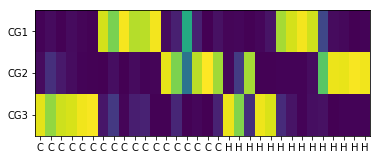

epoch 302 reconstruction  0.340 instantaneous forces 1380.541  tau  1.755


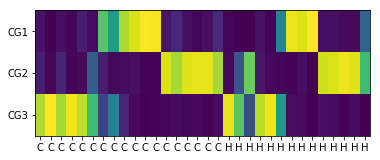

epoch 303 reconstruction  0.339 instantaneous forces 1397.977  tau  1.750


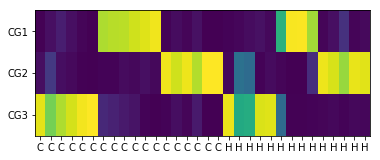

epoch 304 reconstruction  0.337 instantaneous forces 1378.464  tau  1.745


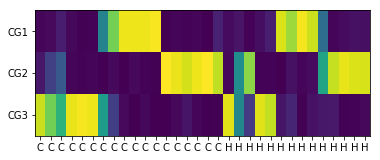

epoch 305 reconstruction  0.338 instantaneous forces 1339.992  tau  1.740


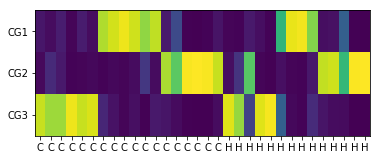

epoch 306 reconstruction  0.339 instantaneous forces 1331.169  tau  1.735


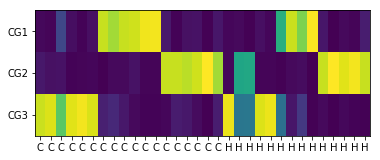

epoch 307 reconstruction  0.339 instantaneous forces 1375.464  tau  1.731


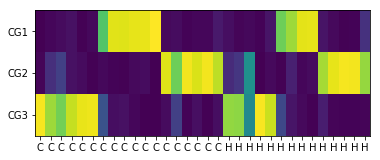

epoch 308 reconstruction  0.337 instantaneous forces 1361.611  tau  1.726


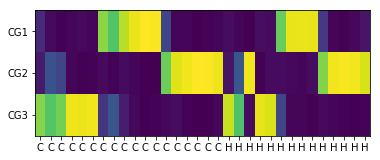

epoch 309 reconstruction  0.338 instantaneous forces 1322.061  tau  1.721


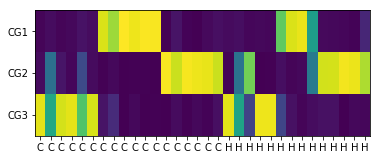

epoch 310 reconstruction  0.338 instantaneous forces 1361.174  tau  1.716


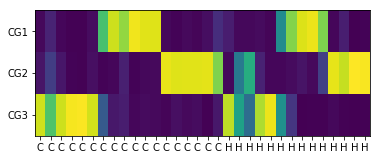

epoch 311 reconstruction  0.338 instantaneous forces 1430.243  tau  1.712


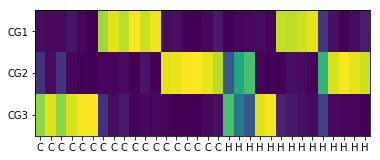

epoch 312 reconstruction  0.337 instantaneous forces 1415.955  tau  1.707


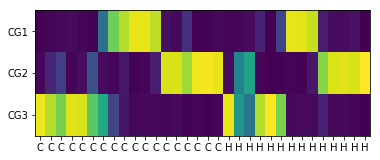

epoch 313 reconstruction  0.337 instantaneous forces 1375.843  tau  1.702


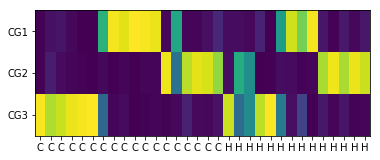

epoch 314 reconstruction  0.338 instantaneous forces 1385.377  tau  1.698


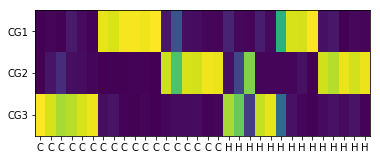

epoch 315 reconstruction  0.339 instantaneous forces 1401.275  tau  1.693


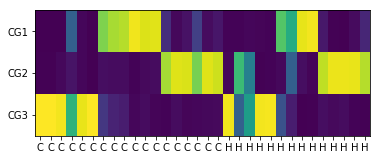

epoch 316 reconstruction  0.338 instantaneous forces 1374.331  tau  1.688


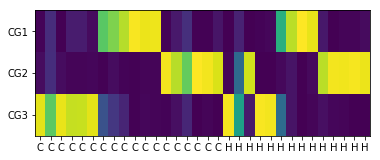

epoch 317 reconstruction  0.336 instantaneous forces 1381.581  tau  1.684


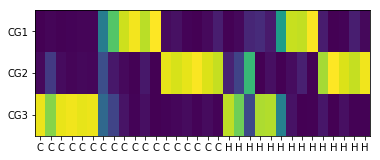

epoch 318 reconstruction  0.336 instantaneous forces 1396.808  tau  1.679


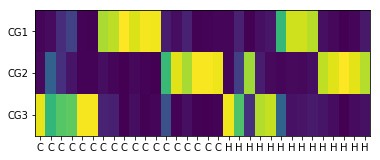

epoch 319 reconstruction  0.337 instantaneous forces 1386.863  tau  1.674


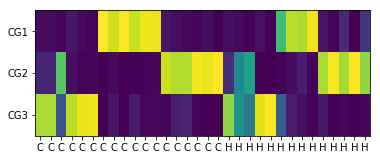

epoch 320 reconstruction  0.337 instantaneous forces 1465.645  tau  1.670


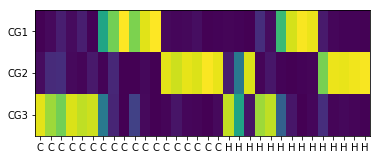

epoch 321 reconstruction  0.338 instantaneous forces 1385.277  tau  1.665


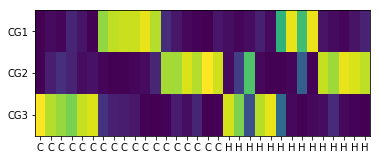

epoch 322 reconstruction  0.337 instantaneous forces 1446.210  tau  1.661


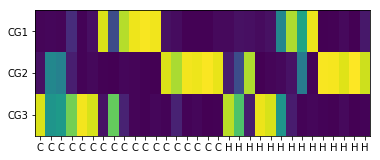

epoch 323 reconstruction  0.337 instantaneous forces 1372.817  tau  1.656


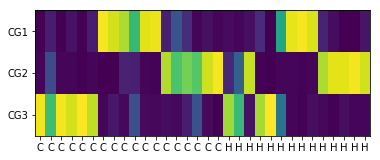

epoch 324 reconstruction  0.339 instantaneous forces 1450.771  tau  1.651


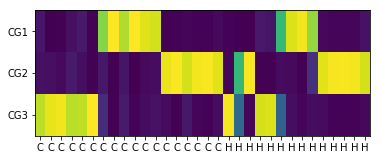

epoch 325 reconstruction  0.337 instantaneous forces 1383.662  tau  1.647


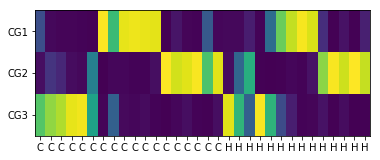

epoch 326 reconstruction  0.337 instantaneous forces 1402.095  tau  1.642


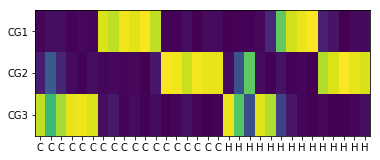

epoch 327 reconstruction  0.337 instantaneous forces 1419.598  tau  1.638


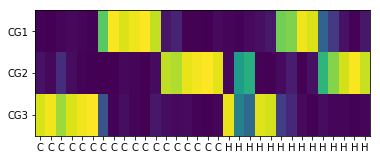

epoch 328 reconstruction  0.337 instantaneous forces 1396.722  tau  1.633


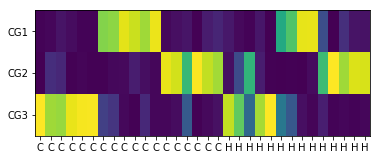

epoch 329 reconstruction  0.335 instantaneous forces 1437.708  tau  1.629


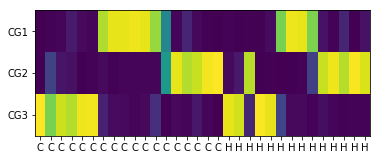

epoch 330 reconstruction  0.337 instantaneous forces 1442.478  tau  1.624


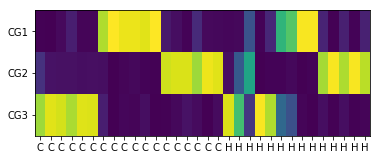

epoch 331 reconstruction  0.337 instantaneous forces 1431.397  tau  1.620


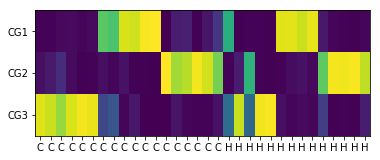

epoch 332 reconstruction  0.337 instantaneous forces 1404.444  tau  1.616


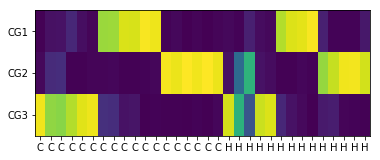

epoch 333 reconstruction  0.337 instantaneous forces 1472.390  tau  1.611


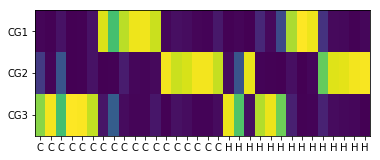

epoch 334 reconstruction  0.337 instantaneous forces 1459.181  tau  1.607


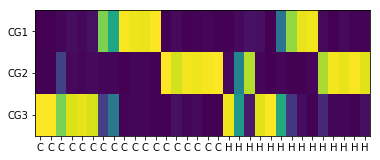

epoch 335 reconstruction  0.336 instantaneous forces 1455.853  tau  1.602


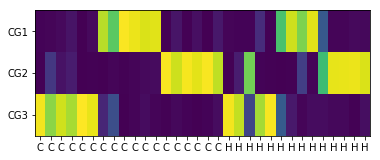

epoch 336 reconstruction  0.335 instantaneous forces 1442.175  tau  1.598


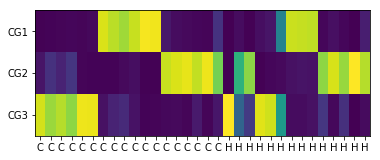

epoch 337 reconstruction  0.338 instantaneous forces 1438.851  tau  1.594


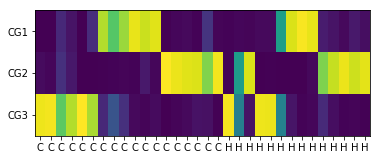

epoch 338 reconstruction  0.335 instantaneous forces 1452.367  tau  1.589


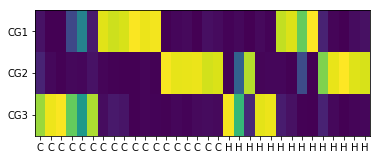

epoch 339 reconstruction  0.335 instantaneous forces 1431.092  tau  1.585


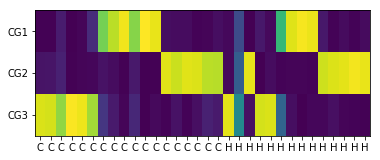

epoch 340 reconstruction  0.336 instantaneous forces 1507.473  tau  1.581


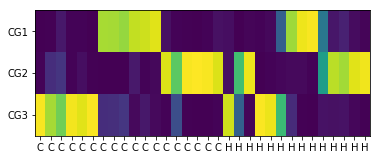

epoch 341 reconstruction  0.337 instantaneous forces 1400.330  tau  1.576


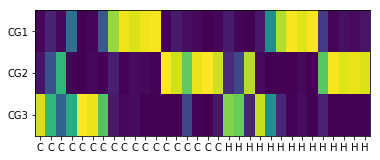

epoch 342 reconstruction  0.337 instantaneous forces 1485.411  tau  1.572


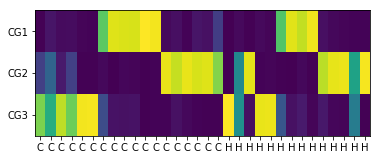

epoch 343 reconstruction  0.335 instantaneous forces 1468.908  tau  1.568


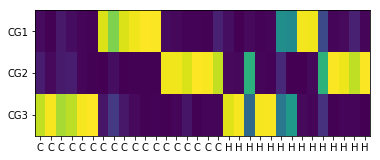

epoch 344 reconstruction  0.337 instantaneous forces 1530.150  tau  1.563


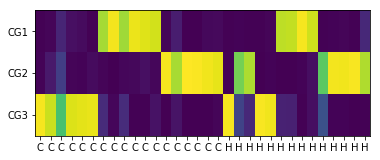

epoch 345 reconstruction  0.336 instantaneous forces 1506.214  tau  1.559


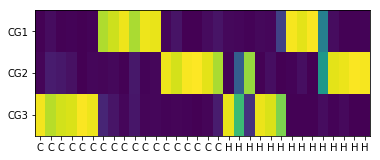

epoch 346 reconstruction  0.336 instantaneous forces 1480.128  tau  1.555


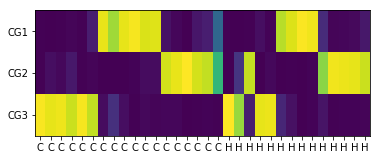

epoch 347 reconstruction  0.336 instantaneous forces 1454.561  tau  1.551


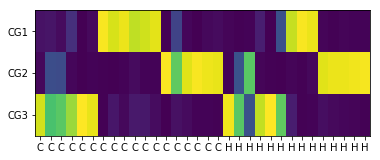

epoch 348 reconstruction  0.336 instantaneous forces 1464.982  tau  1.546


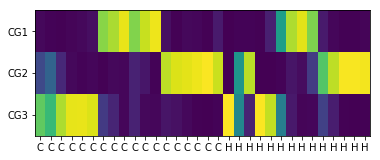

epoch 349 reconstruction  0.336 instantaneous forces 1433.192  tau  1.542


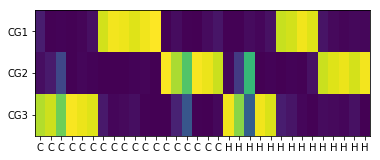

epoch 350 reconstruction  0.336 instantaneous forces 1445.959  tau  1.538


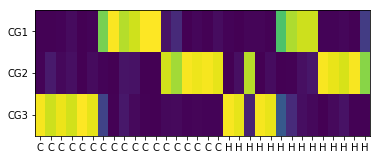

epoch 351 reconstruction  0.335 instantaneous forces 1485.299  tau  1.534


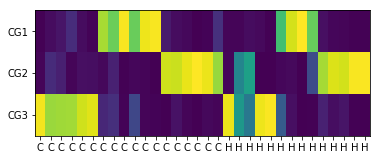

epoch 352 reconstruction  0.336 instantaneous forces 1509.477  tau  1.530


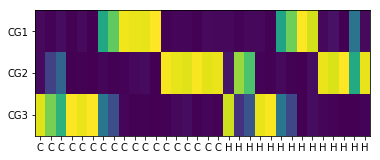

epoch 353 reconstruction  0.337 instantaneous forces 1496.998  tau  1.525


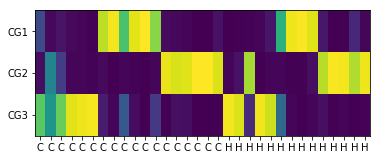

epoch 354 reconstruction  0.334 instantaneous forces 1479.562  tau  1.521


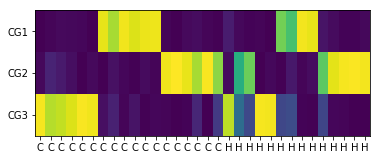

epoch 355 reconstruction  0.336 instantaneous forces 1489.864  tau  1.517


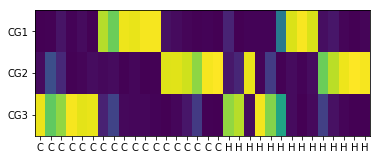

epoch 356 reconstruction  0.335 instantaneous forces 1494.697  tau  1.513


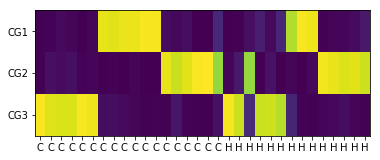

epoch 357 reconstruction  0.336 instantaneous forces 1448.730  tau  1.509


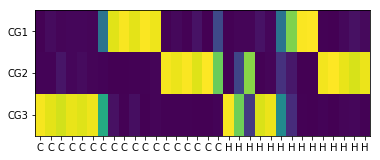

epoch 358 reconstruction  0.336 instantaneous forces 1492.181  tau  1.505


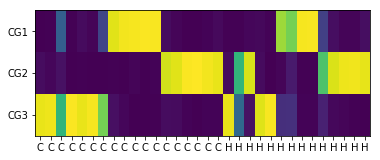

epoch 359 reconstruction  0.335 instantaneous forces 1494.599  tau  1.501


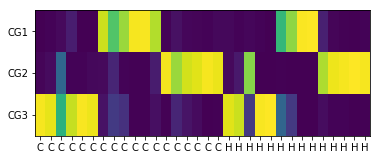

epoch 360 reconstruction  0.336 instantaneous forces 1558.500  tau  1.497


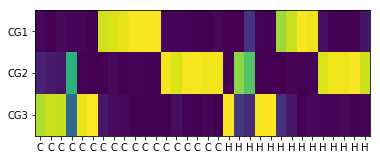

epoch 361 reconstruction  0.336 instantaneous forces 1552.406  tau  1.493


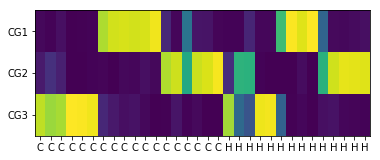

epoch 362 reconstruction  0.336 instantaneous forces 1494.983  tau  1.489


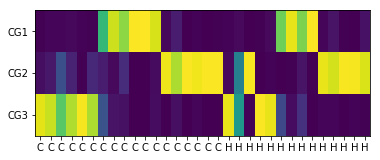

epoch 363 reconstruction  0.335 instantaneous forces 1477.251  tau  1.485


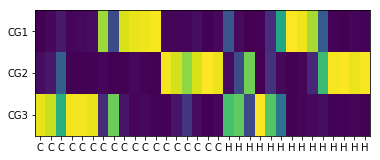

epoch 364 reconstruction  0.335 instantaneous forces 1475.901  tau  1.481


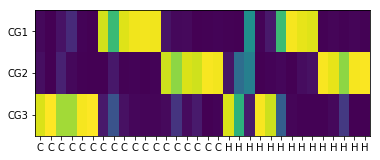

epoch 365 reconstruction  0.336 instantaneous forces 1508.471  tau  1.477


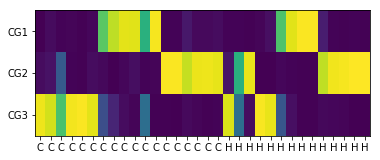

epoch 366 reconstruction  0.336 instantaneous forces 1464.863  tau  1.473


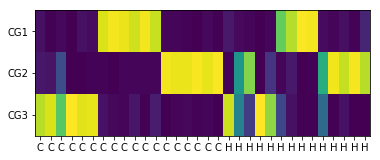

epoch 367 reconstruction  0.336 instantaneous forces 1527.473  tau  1.469


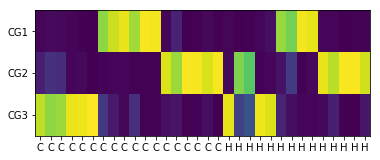

epoch 368 reconstruction  0.335 instantaneous forces 1484.788  tau  1.465


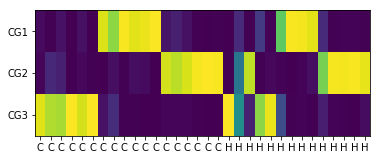

epoch 369 reconstruction  0.335 instantaneous forces 1521.555  tau  1.461


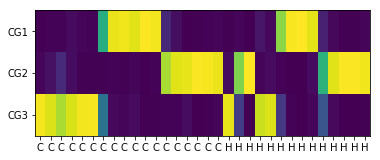

epoch 370 reconstruction  0.335 instantaneous forces 1503.131  tau  1.457


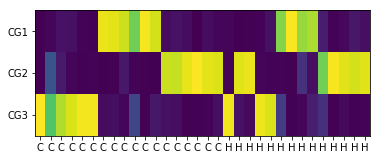

epoch 371 reconstruction  0.336 instantaneous forces 1558.781  tau  1.453


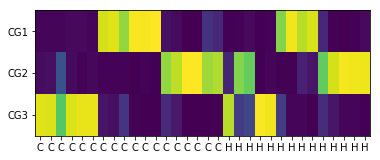

epoch 372 reconstruction  0.335 instantaneous forces 1529.768  tau  1.449


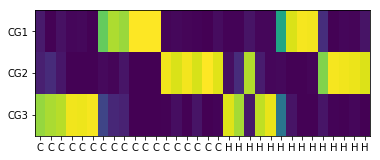

epoch 373 reconstruction  0.335 instantaneous forces 1489.335  tau  1.445


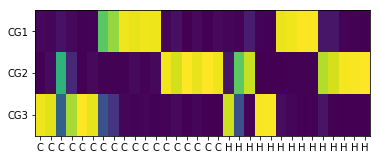

epoch 374 reconstruction  0.336 instantaneous forces 1525.768  tau  1.441


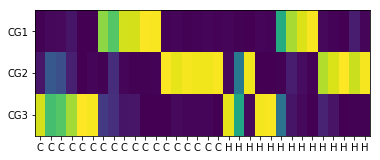

epoch 375 reconstruction  0.338 instantaneous forces 1557.580  tau  1.437


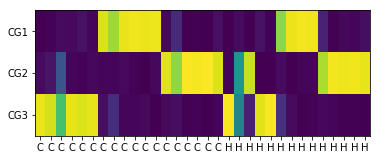

epoch 376 reconstruction  0.334 instantaneous forces 1545.371  tau  1.433


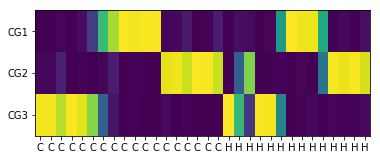

epoch 377 reconstruction  0.334 instantaneous forces 1492.464  tau  1.430


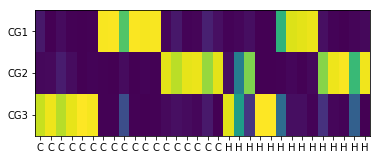

epoch 378 reconstruction  0.336 instantaneous forces 1549.827  tau  1.426


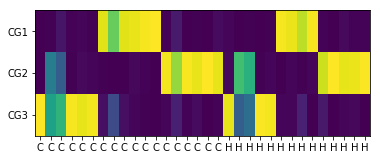

epoch 379 reconstruction  0.335 instantaneous forces 1494.138  tau  1.422


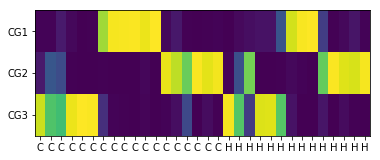

epoch 380 reconstruction  0.335 instantaneous forces 1516.178  tau  1.418


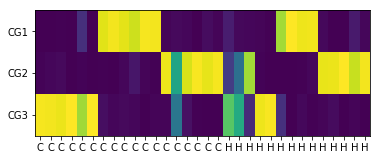

epoch 381 reconstruction  0.335 instantaneous forces 1528.187  tau  1.414


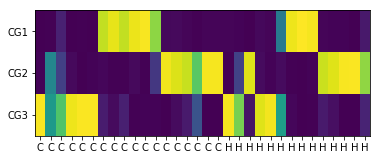

epoch 382 reconstruction  0.337 instantaneous forces 1536.244  tau  1.411


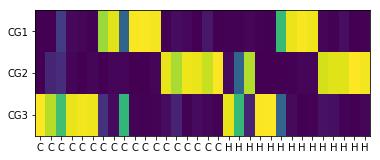

epoch 383 reconstruction  0.336 instantaneous forces 1550.004  tau  1.407


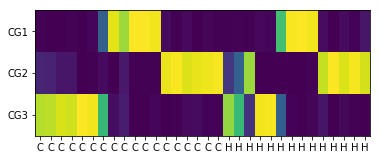

epoch 384 reconstruction  0.335 instantaneous forces 1502.926  tau  1.403


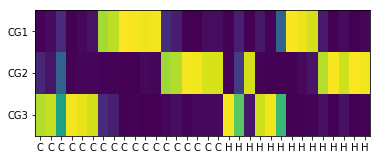

epoch 385 reconstruction  0.334 instantaneous forces 1533.452  tau  1.399


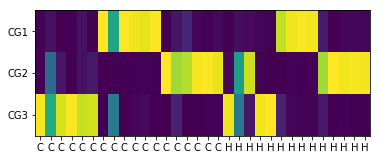

epoch 386 reconstruction  0.335 instantaneous forces 1579.501  tau  1.395


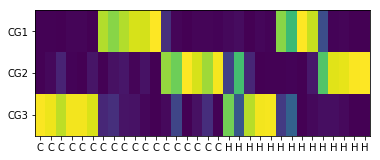

epoch 387 reconstruction  0.337 instantaneous forces 1540.789  tau  1.392


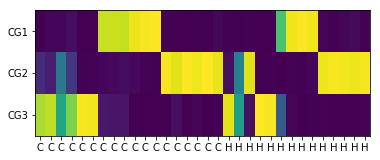

epoch 388 reconstruction  0.335 instantaneous forces 1575.792  tau  1.388


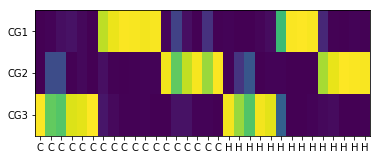

epoch 389 reconstruction  0.333 instantaneous forces 1529.787  tau  1.384


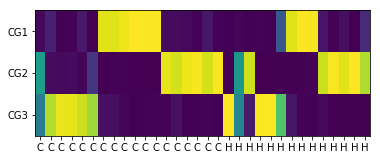

epoch 390 reconstruction  0.335 instantaneous forces 1546.748  tau  1.381


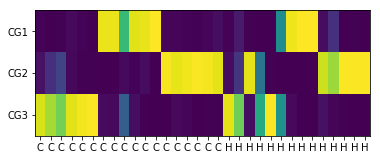

epoch 391 reconstruction  0.336 instantaneous forces 1582.312  tau  1.377


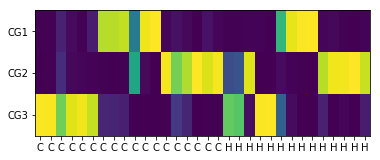

epoch 392 reconstruction  0.334 instantaneous forces 1521.246  tau  1.373


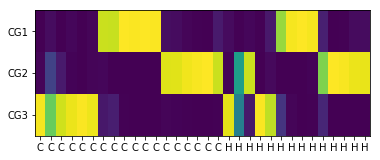

epoch 393 reconstruction  0.336 instantaneous forces 1530.451  tau  1.370


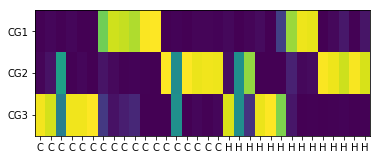

epoch 394 reconstruction  0.335 instantaneous forces 1581.175  tau  1.366


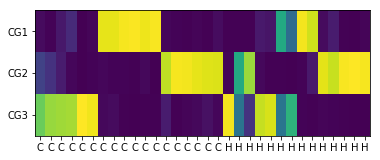

epoch 395 reconstruction  0.334 instantaneous forces 1651.934  tau  1.362


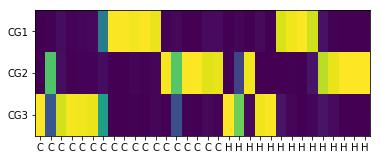

epoch 396 reconstruction  0.335 instantaneous forces 1539.712  tau  1.359


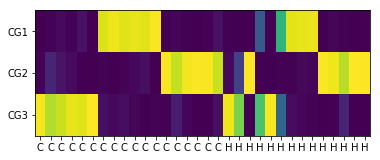

epoch 397 reconstruction  0.335 instantaneous forces 1553.087  tau  1.355


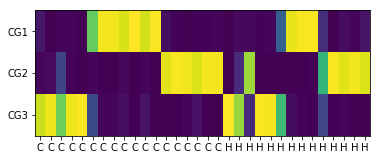

epoch 398 reconstruction  0.334 instantaneous forces 1617.990  tau  1.351


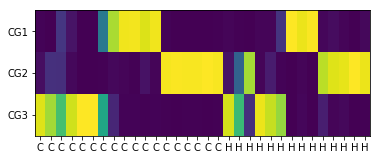

epoch 399 reconstruction  0.334 instantaneous forces 1564.655  tau  1.348


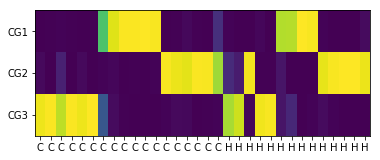

epoch 400 reconstruction  0.335 instantaneous forces 1507.865  tau  1.344


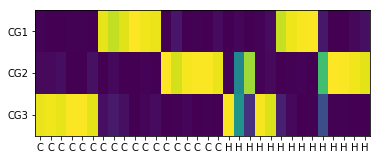

epoch 401 reconstruction  0.334 instantaneous forces 1469.613  tau  1.341


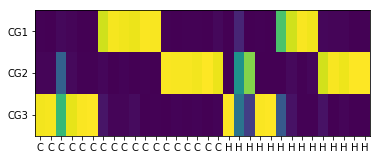

epoch 402 reconstruction  0.335 instantaneous forces 1504.032  tau  1.337


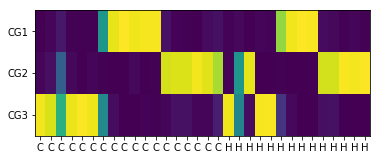

epoch 403 reconstruction  0.335 instantaneous forces 1521.445  tau  1.334


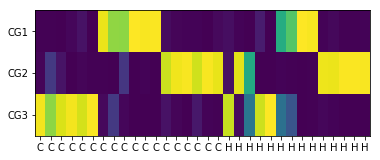

epoch 404 reconstruction  0.334 instantaneous forces 1512.800  tau  1.330


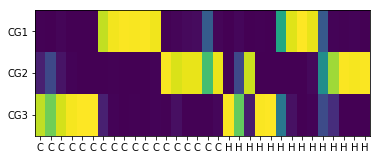

epoch 405 reconstruction  0.335 instantaneous forces 1531.043  tau  1.326


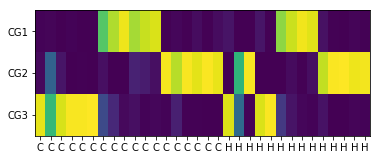

epoch 406 reconstruction  0.336 instantaneous forces 1487.417  tau  1.323


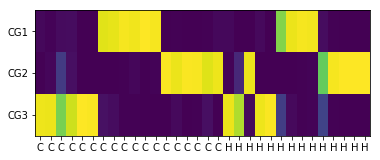

epoch 407 reconstruction  0.335 instantaneous forces 1544.973  tau  1.319


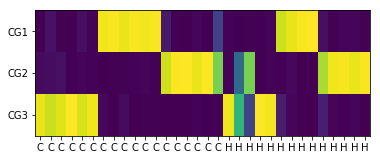

epoch 408 reconstruction  0.336 instantaneous forces 1467.999  tau  1.316


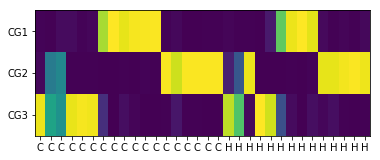

epoch 409 reconstruction  0.335 instantaneous forces 1526.903  tau  1.312


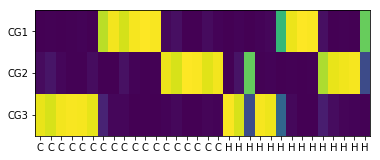

epoch 410 reconstruction  0.335 instantaneous forces 1545.003  tau  1.309


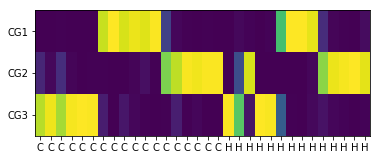

epoch 411 reconstruction  0.335 instantaneous forces 1557.036  tau  1.306


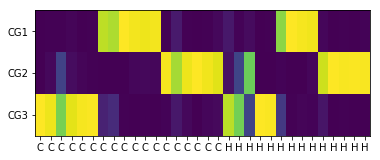

epoch 412 reconstruction  0.335 instantaneous forces 1513.446  tau  1.302


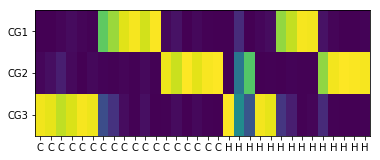

epoch 413 reconstruction  0.334 instantaneous forces 1439.305  tau  1.299


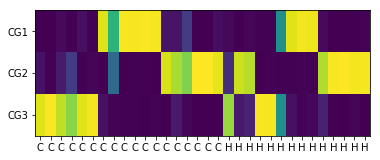

epoch 414 reconstruction  0.334 instantaneous forces 1479.907  tau  1.295


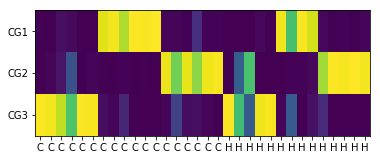

epoch 415 reconstruction  0.335 instantaneous forces 1535.930  tau  1.292


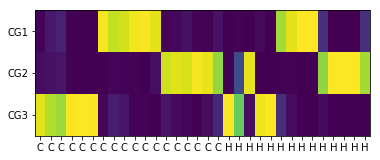

epoch 416 reconstruction  0.334 instantaneous forces 1554.997  tau  1.288


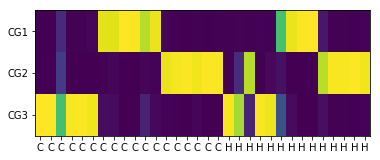

epoch 417 reconstruction  0.334 instantaneous forces 1555.940  tau  1.285


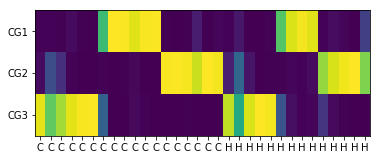

epoch 418 reconstruction  0.336 instantaneous forces 1496.135  tau  1.282


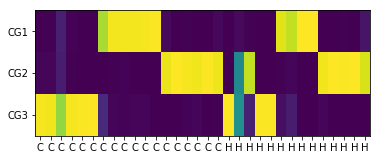

epoch 419 reconstruction  0.336 instantaneous forces 1522.981  tau  1.278


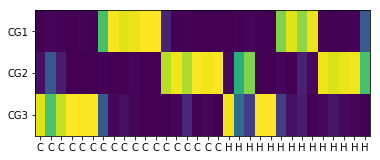

epoch 420 reconstruction  0.335 instantaneous forces 1491.272  tau  1.275


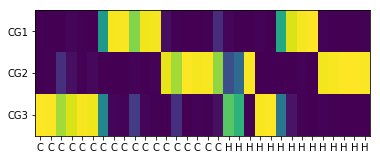

epoch 421 reconstruction  0.334 instantaneous forces 1515.917  tau  1.271


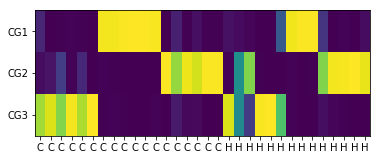

epoch 422 reconstruction  0.335 instantaneous forces 1553.909  tau  1.268


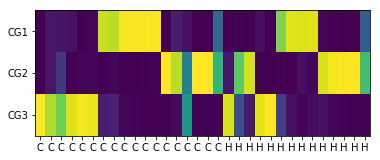

epoch 423 reconstruction  0.334 instantaneous forces 1461.162  tau  1.265


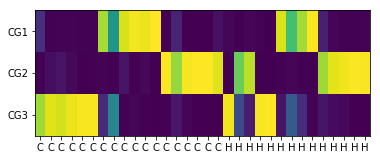

epoch 424 reconstruction  0.335 instantaneous forces 1471.314  tau  1.261


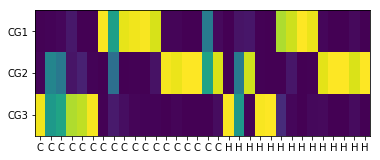

epoch 425 reconstruction  0.335 instantaneous forces 1538.155  tau  1.258


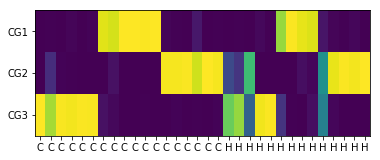

epoch 426 reconstruction  0.336 instantaneous forces 1456.657  tau  1.255


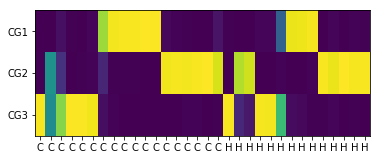

epoch 427 reconstruction  0.334 instantaneous forces 1511.640  tau  1.252


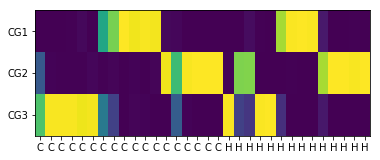

epoch 428 reconstruction  0.335 instantaneous forces 1511.713  tau  1.248


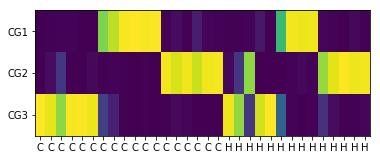

epoch 429 reconstruction  0.336 instantaneous forces 1413.728  tau  1.245


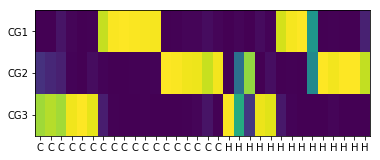

epoch 430 reconstruction  0.336 instantaneous forces 1451.392  tau  1.242


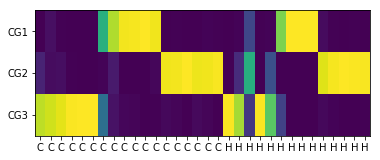

epoch 431 reconstruction  0.336 instantaneous forces 1484.734  tau  1.238


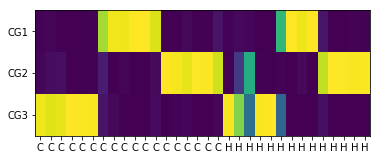

epoch 432 reconstruction  0.336 instantaneous forces 1500.538  tau  1.235


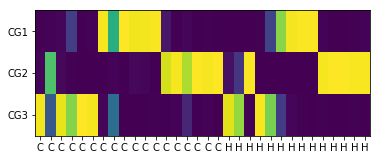

epoch 433 reconstruction  0.335 instantaneous forces 1548.458  tau  1.232


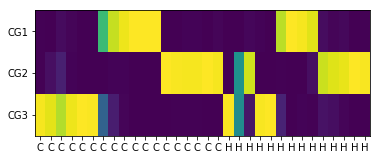

epoch 434 reconstruction  0.335 instantaneous forces 1515.386  tau  1.229


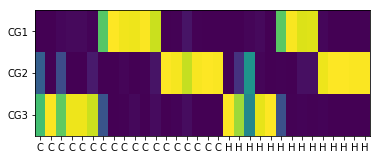

epoch 435 reconstruction  0.335 instantaneous forces 1482.925  tau  1.226


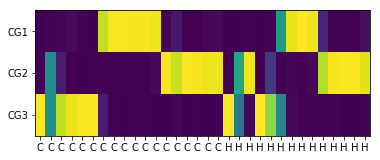

epoch 436 reconstruction  0.335 instantaneous forces 1400.044  tau  1.222


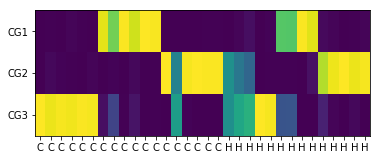

epoch 437 reconstruction  0.336 instantaneous forces 1476.825  tau  1.219


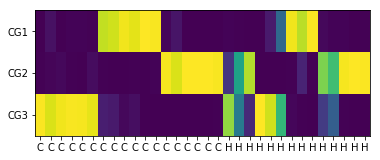

epoch 438 reconstruction  0.336 instantaneous forces 1414.551  tau  1.216


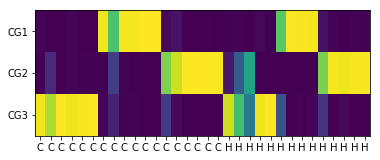

epoch 439 reconstruction  0.335 instantaneous forces 1521.923  tau  1.213


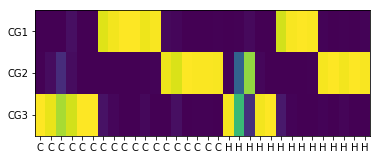

epoch 440 reconstruction  0.337 instantaneous forces 1458.540  tau  1.210


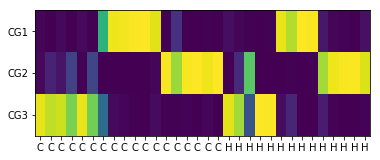

epoch 441 reconstruction  0.337 instantaneous forces 1502.484  tau  1.206


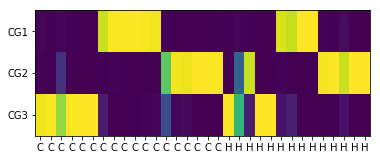

epoch 442 reconstruction  0.335 instantaneous forces 1539.460  tau  1.203


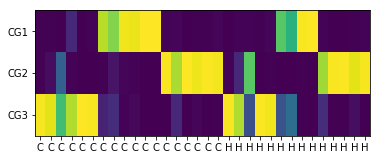

epoch 443 reconstruction  0.335 instantaneous forces 1479.233  tau  1.200


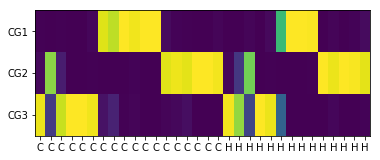

epoch 444 reconstruction  0.334 instantaneous forces 1468.351  tau  1.197


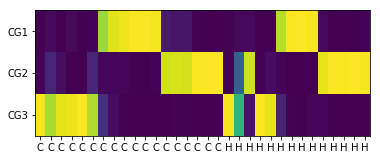

epoch 445 reconstruction  0.337 instantaneous forces 1498.845  tau  1.194


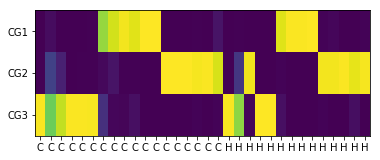

epoch 446 reconstruction  0.335 instantaneous forces 1409.466  tau  1.191


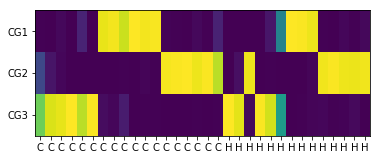

epoch 447 reconstruction  0.336 instantaneous forces 1487.679  tau  1.188


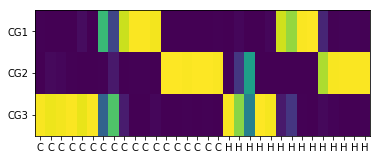

epoch 448 reconstruction  0.336 instantaneous forces 1443.890  tau  1.185


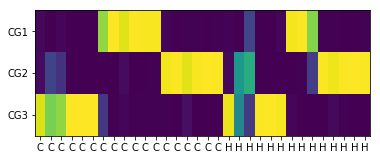

epoch 449 reconstruction  0.335 instantaneous forces 1433.300  tau  1.182


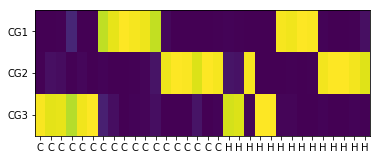

epoch 450 reconstruction  0.335 instantaneous forces 1441.804  tau  1.179


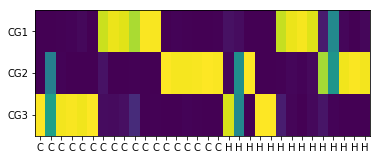

epoch 451 reconstruction  0.336 instantaneous forces 1496.519  tau  1.175


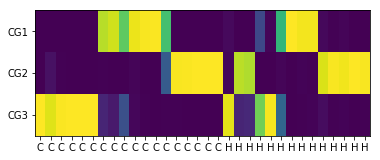

epoch 452 reconstruction  0.337 instantaneous forces 1431.880  tau  1.172


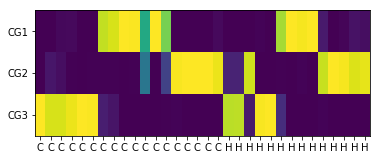

epoch 453 reconstruction  0.336 instantaneous forces 1447.816  tau  1.169


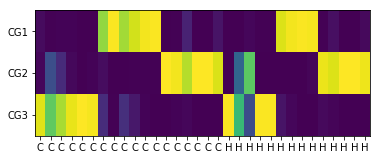

epoch 454 reconstruction  0.336 instantaneous forces 1439.286  tau  1.166


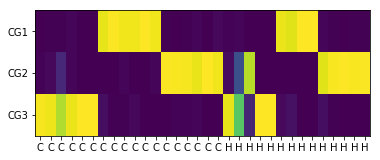

epoch 455 reconstruction  0.336 instantaneous forces 1427.868  tau  1.163


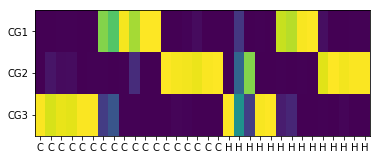

epoch 456 reconstruction  0.336 instantaneous forces 1457.649  tau  1.160


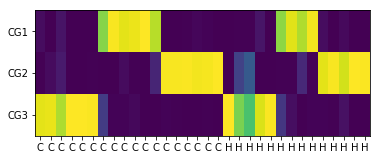

epoch 457 reconstruction  0.336 instantaneous forces 1430.794  tau  1.157


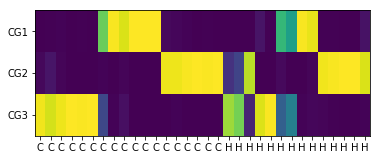

epoch 458 reconstruction  0.336 instantaneous forces 1400.062  tau  1.154


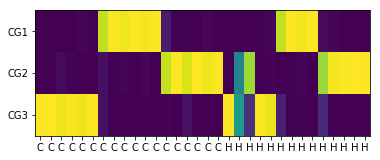

epoch 459 reconstruction  0.337 instantaneous forces 1409.757  tau  1.151


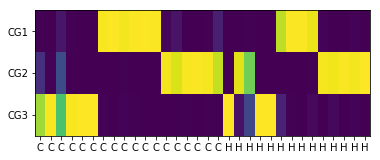

epoch 460 reconstruction  0.336 instantaneous forces 1413.295  tau  1.148


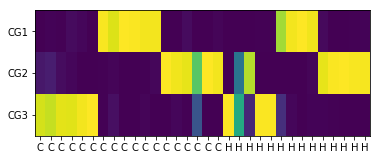

epoch 461 reconstruction  0.335 instantaneous forces 1396.945  tau  1.145


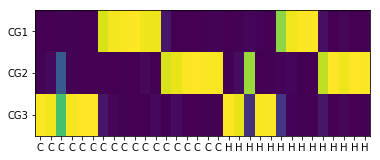

epoch 462 reconstruction  0.337 instantaneous forces 1445.458  tau  1.142


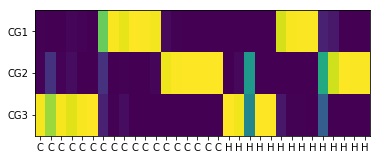

epoch 463 reconstruction  0.337 instantaneous forces 1435.472  tau  1.140


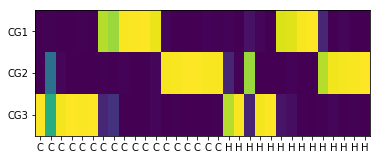

epoch 464 reconstruction  0.336 instantaneous forces 1390.175  tau  1.137


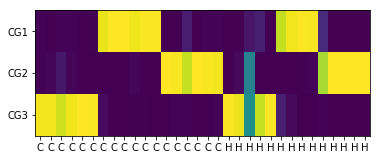

epoch 465 reconstruction  0.337 instantaneous forces 1394.200  tau  1.134


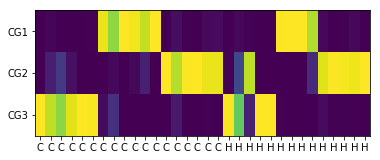

epoch 466 reconstruction  0.338 instantaneous forces 1448.496  tau  1.131


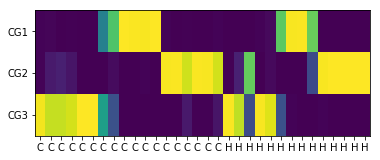

epoch 467 reconstruction  0.335 instantaneous forces 1456.423  tau  1.128


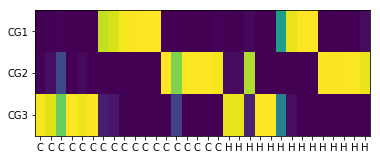

epoch 468 reconstruction  0.336 instantaneous forces 1425.637  tau  1.125


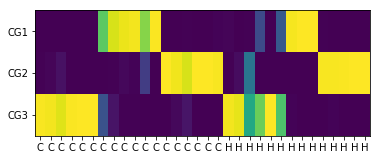

epoch 469 reconstruction  0.337 instantaneous forces 1400.446  tau  1.122


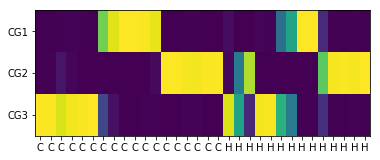

epoch 470 reconstruction  0.336 instantaneous forces 1425.537  tau  1.119


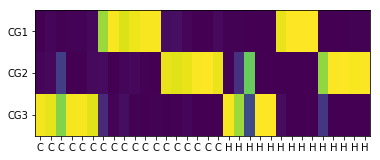

epoch 471 reconstruction  0.337 instantaneous forces 1419.165  tau  1.116


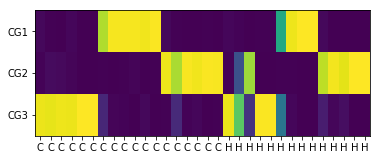

epoch 472 reconstruction  0.337 instantaneous forces 1412.005  tau  1.113


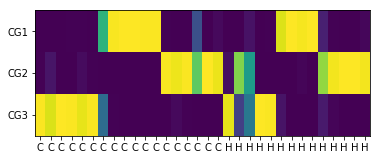

epoch 473 reconstruction  0.336 instantaneous forces 1410.044  tau  1.111


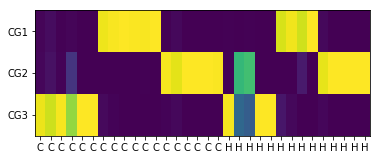

epoch 474 reconstruction  0.336 instantaneous forces 1430.018  tau  1.108


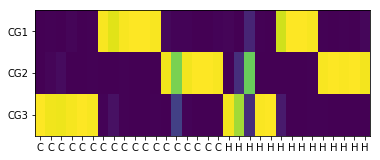

epoch 475 reconstruction  0.337 instantaneous forces 1355.327  tau  1.105


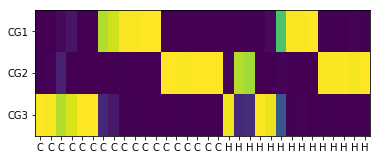

epoch 476 reconstruction  0.337 instantaneous forces 1373.318  tau  1.102


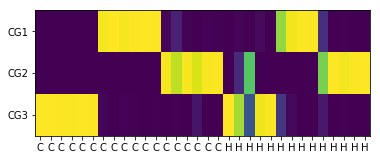

epoch 477 reconstruction  0.338 instantaneous forces 1399.651  tau  1.099


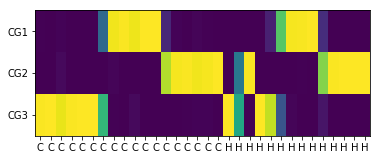

epoch 478 reconstruction  0.337 instantaneous forces 1451.370  tau  1.096


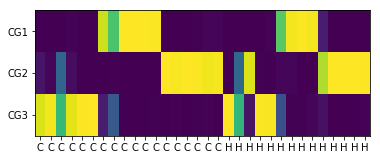

epoch 479 reconstruction  0.338 instantaneous forces 1381.832  tau  1.094


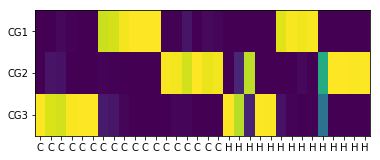

epoch 480 reconstruction  0.338 instantaneous forces 1396.138  tau  1.091


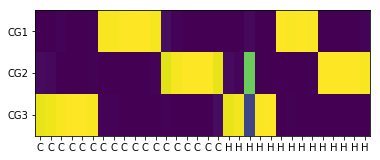

epoch 481 reconstruction  0.337 instantaneous forces 1356.225  tau  1.088


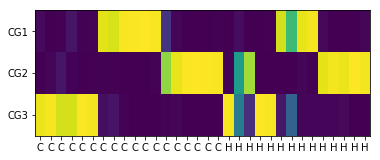

epoch 482 reconstruction  0.336 instantaneous forces 1459.153  tau  1.085


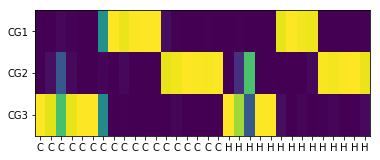

epoch 483 reconstruction  0.338 instantaneous forces 1514.429  tau  1.083


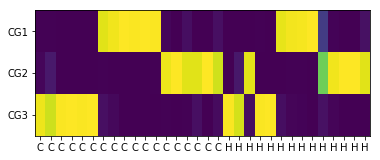

epoch 484 reconstruction  0.337 instantaneous forces 1419.507  tau  1.080


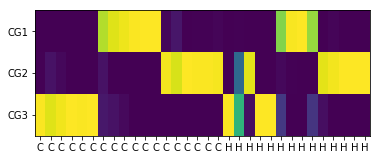

epoch 485 reconstruction  0.335 instantaneous forces 1417.561  tau  1.077


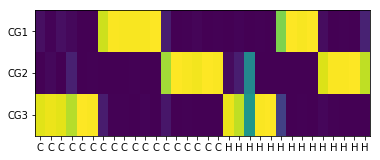

epoch 486 reconstruction  0.338 instantaneous forces 1462.301  tau  1.074


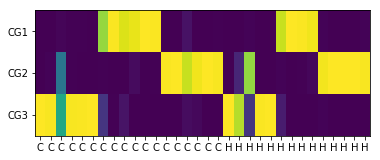

epoch 487 reconstruction  0.337 instantaneous forces 1369.359  tau  1.072


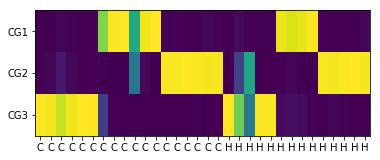

epoch 488 reconstruction  0.336 instantaneous forces 1393.525  tau  1.069


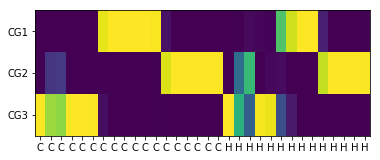

epoch 489 reconstruction  0.338 instantaneous forces 1355.677  tau  1.066


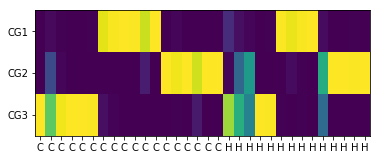

epoch 490 reconstruction  0.337 instantaneous forces 1431.408  tau  1.063


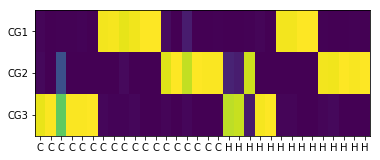

epoch 491 reconstruction  0.337 instantaneous forces 1454.221  tau  1.061


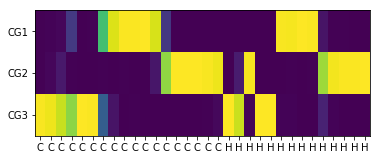

epoch 492 reconstruction  0.338 instantaneous forces 1421.339  tau  1.058


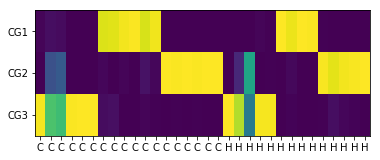

epoch 493 reconstruction  0.338 instantaneous forces 1327.134  tau  1.055


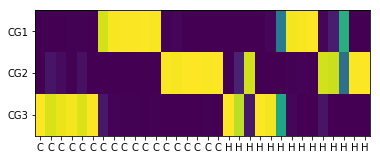

epoch 494 reconstruction  0.337 instantaneous forces 1388.725  tau  1.053


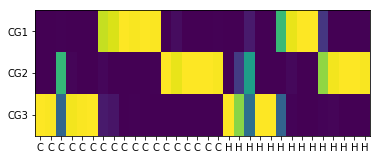

epoch 495 reconstruction  0.337 instantaneous forces 1335.895  tau  1.050


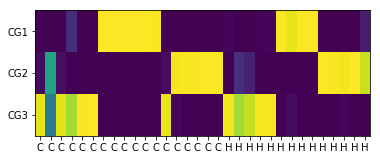

epoch 496 reconstruction  0.336 instantaneous forces 1368.428  tau  1.047


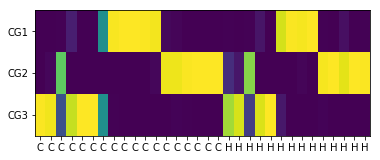

epoch 497 reconstruction  0.336 instantaneous forces 1409.033  tau  1.045


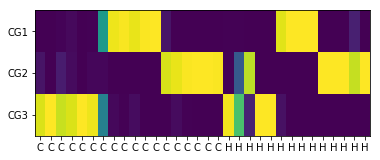

epoch 498 reconstruction  0.339 instantaneous forces 1379.405  tau  1.042


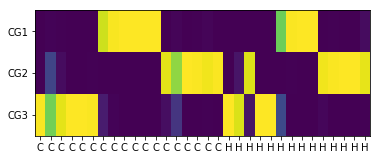

epoch 499 reconstruction  0.338 instantaneous forces 1344.190  tau  1.039


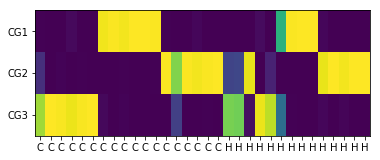

epoch 500 reconstruction  0.338 instantaneous forces 1327.761  tau  1.037


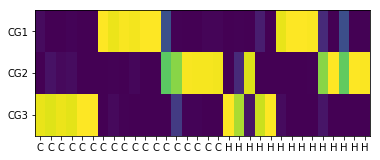

epoch 501 reconstruction  0.338 instantaneous forces 1373.527  tau  1.034


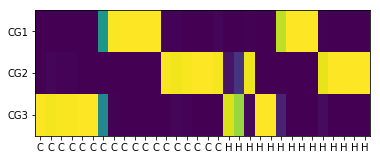

epoch 502 reconstruction  0.337 instantaneous forces 1400.959  tau  1.032


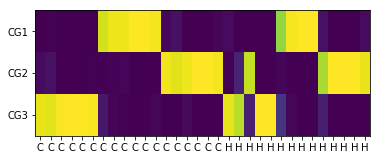

epoch 503 reconstruction  0.338 instantaneous forces 1409.511  tau  1.029


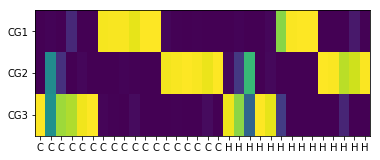

epoch 504 reconstruction  0.337 instantaneous forces 1382.764  tau  1.026


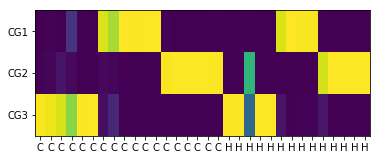

epoch 505 reconstruction  0.337 instantaneous forces 1324.018  tau  1.024


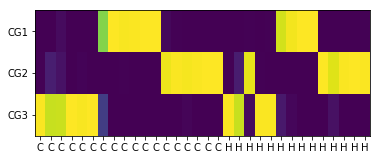

epoch 506 reconstruction  0.337 instantaneous forces 1331.311  tau  1.021


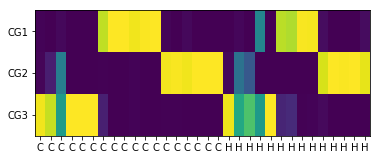

epoch 507 reconstruction  0.339 instantaneous forces 1281.915  tau  1.019


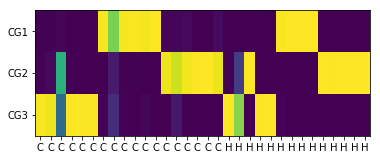

epoch 508 reconstruction  0.338 instantaneous forces 1377.066  tau  1.016


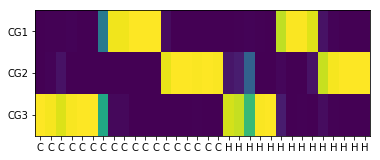

epoch 509 reconstruction  0.339 instantaneous forces 1344.375  tau  1.014


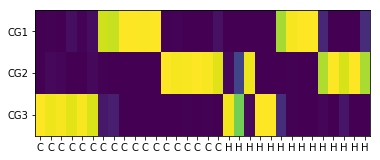

epoch 510 reconstruction  0.338 instantaneous forces 1351.900  tau  1.011


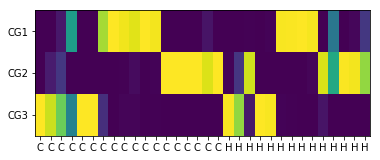

epoch 511 reconstruction  0.338 instantaneous forces 1340.274  tau  1.008


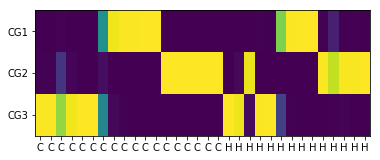

epoch 512 reconstruction  0.339 instantaneous forces 1306.501  tau  1.006


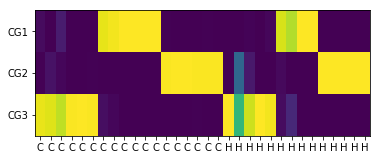

epoch 513 reconstruction  0.337 instantaneous forces 1254.480  tau  1.003


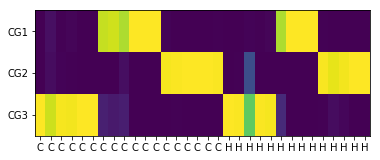

epoch 514 reconstruction  0.338 instantaneous forces 1375.780  tau  1.001


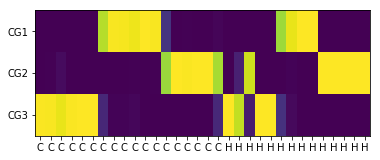

epoch 515 reconstruction  0.337 instantaneous forces 1304.949  tau  0.998


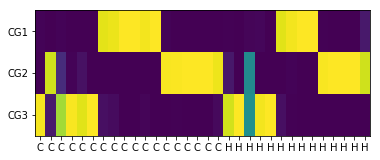

epoch 516 reconstruction  0.339 instantaneous forces 1448.231  tau  0.996


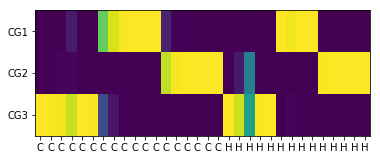

epoch 517 reconstruction  0.338 instantaneous forces 1310.610  tau  0.993


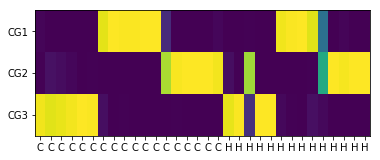

epoch 518 reconstruction  0.340 instantaneous forces 1351.762  tau  0.991


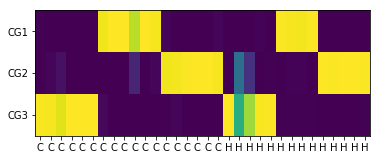

epoch 519 reconstruction  0.340 instantaneous forces 1383.093  tau  0.989


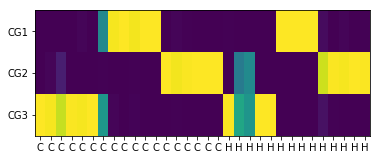

epoch 520 reconstruction  0.337 instantaneous forces 1327.441  tau  0.986


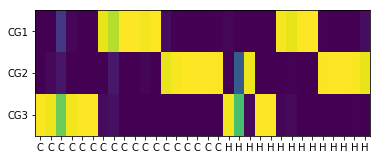

epoch 521 reconstruction  0.338 instantaneous forces 1333.471  tau  0.984


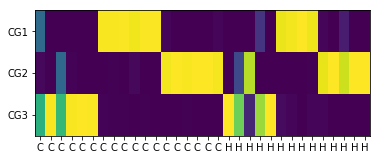

epoch 522 reconstruction  0.340 instantaneous forces 1359.786  tau  0.981


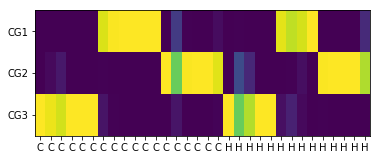

epoch 523 reconstruction  0.338 instantaneous forces 1304.880  tau  0.979


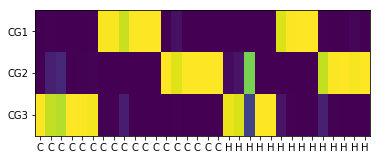

epoch 524 reconstruction  0.339 instantaneous forces 1312.833  tau  0.976


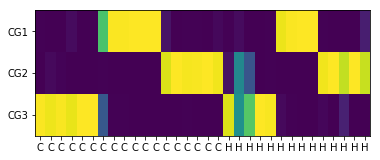

epoch 525 reconstruction  0.340 instantaneous forces 1327.571  tau  0.974


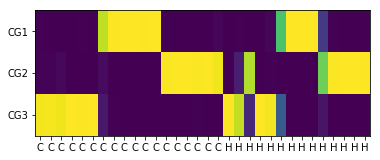

epoch 526 reconstruction  0.340 instantaneous forces 1354.222  tau  0.971


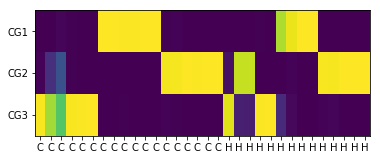

epoch 527 reconstruction  0.341 instantaneous forces 1312.909  tau  0.969


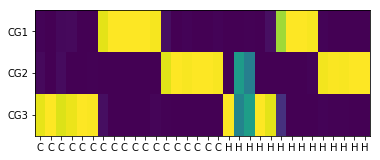

epoch 528 reconstruction  0.340 instantaneous forces 1323.139  tau  0.967


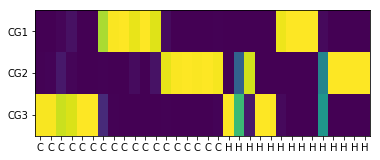

epoch 529 reconstruction  0.339 instantaneous forces 1363.782  tau  0.964


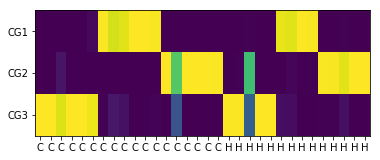

epoch 530 reconstruction  0.339 instantaneous forces 1320.668  tau  0.962


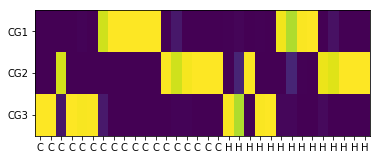

epoch 531 reconstruction  0.339 instantaneous forces 1268.717  tau  0.959


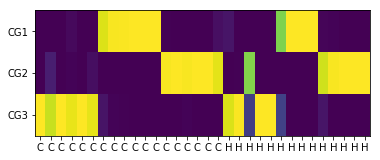

epoch 532 reconstruction  0.340 instantaneous forces 1282.307  tau  0.957


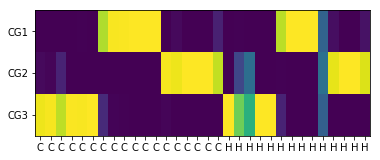

epoch 533 reconstruction  0.338 instantaneous forces 1327.473  tau  0.955


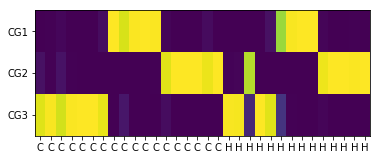

epoch 534 reconstruction  0.340 instantaneous forces 1315.848  tau  0.952


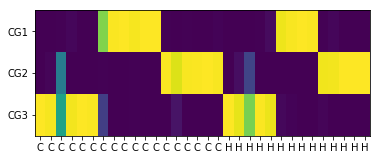

epoch 535 reconstruction  0.341 instantaneous forces 1292.199  tau  0.950


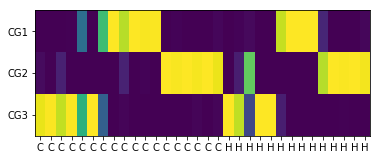

epoch 536 reconstruction  0.340 instantaneous forces 1334.420  tau  0.948


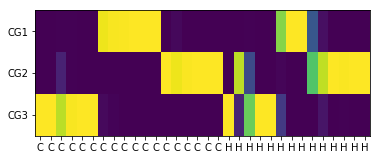

epoch 537 reconstruction  0.340 instantaneous forces 1338.412  tau  0.945


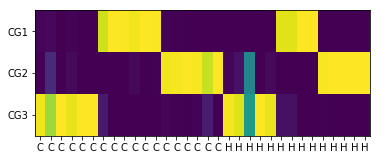

epoch 538 reconstruction  0.341 instantaneous forces 1294.941  tau  0.943


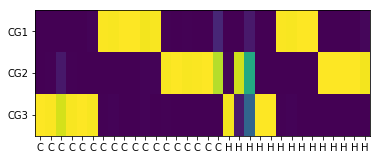

epoch 539 reconstruction  0.342 instantaneous forces 1367.280  tau  0.941


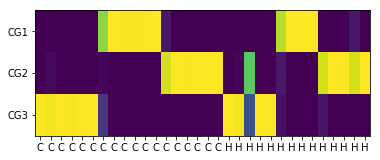

epoch 540 reconstruction  0.341 instantaneous forces 1305.004  tau  0.938


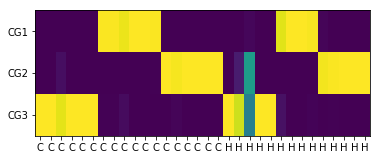

epoch 541 reconstruction  0.341 instantaneous forces 1301.712  tau  0.936


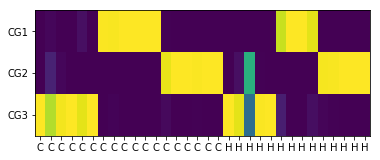

epoch 542 reconstruction  0.340 instantaneous forces 1302.785  tau  0.934


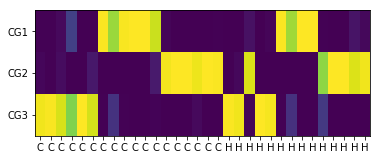

epoch 543 reconstruction  0.340 instantaneous forces 1311.521  tau  0.931


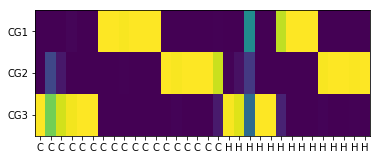

epoch 544 reconstruction  0.340 instantaneous forces 1312.651  tau  0.929


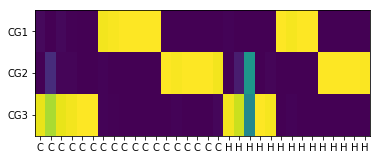

epoch 545 reconstruction  0.341 instantaneous forces 1334.235  tau  0.927


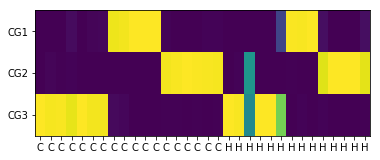

epoch 546 reconstruction  0.340 instantaneous forces 1328.761  tau  0.925


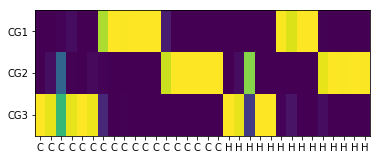

epoch 547 reconstruction  0.339 instantaneous forces 1245.942  tau  0.922


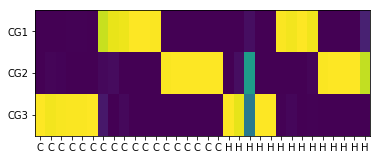

epoch 548 reconstruction  0.342 instantaneous forces 1250.156  tau  0.920


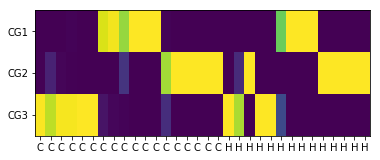

epoch 549 reconstruction  0.341 instantaneous forces 1264.499  tau  0.918


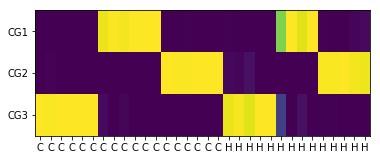

epoch 550 reconstruction  0.341 instantaneous forces 1281.744  tau  0.916


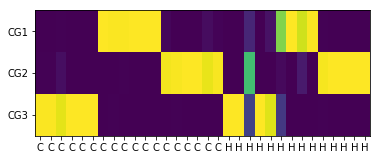

epoch 551 reconstruction  0.340 instantaneous forces 1324.236  tau  0.913


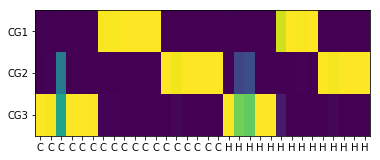

epoch 552 reconstruction  0.340 instantaneous forces 1252.589  tau  0.911


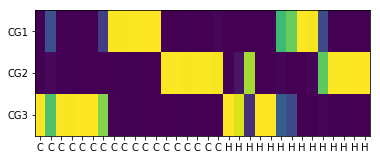

epoch 553 reconstruction  0.341 instantaneous forces 1293.092  tau  0.909


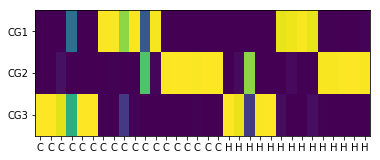

epoch 554 reconstruction  0.342 instantaneous forces 1335.721  tau  0.907


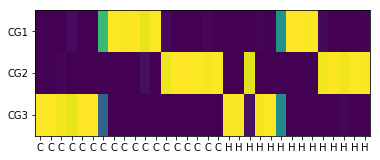

epoch 555 reconstruction  0.340 instantaneous forces 1296.085  tau  0.905


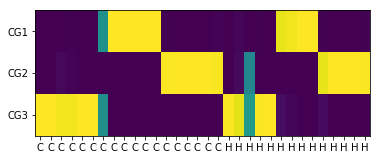

epoch 556 reconstruction  0.341 instantaneous forces 1308.314  tau  0.902


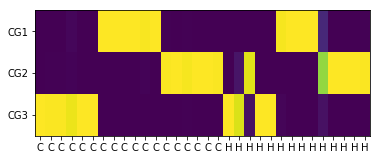

epoch 557 reconstruction  0.342 instantaneous forces 1231.098  tau  0.900


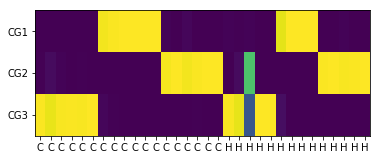

epoch 558 reconstruction  0.342 instantaneous forces 1268.708  tau  0.898


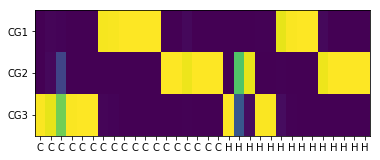

epoch 559 reconstruction  0.342 instantaneous forces 1305.344  tau  0.896


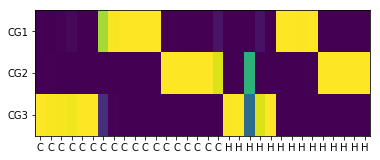

epoch 560 reconstruction  0.341 instantaneous forces 1285.981  tau  0.894


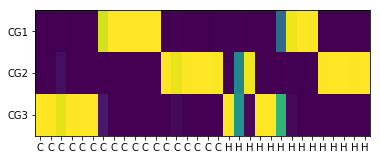

epoch 561 reconstruction  0.341 instantaneous forces 1224.176  tau  0.891


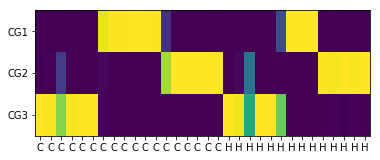

epoch 562 reconstruction  0.341 instantaneous forces 1296.549  tau  0.889


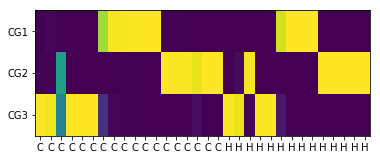

epoch 563 reconstruction  0.342 instantaneous forces 1257.004  tau  0.887


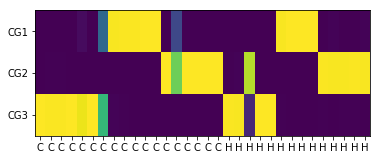

epoch 564 reconstruction  0.342 instantaneous forces 1325.825  tau  0.885


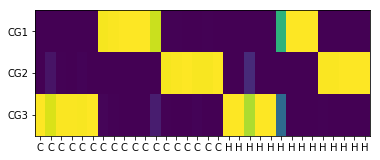

epoch 565 reconstruction  0.342 instantaneous forces 1272.955  tau  0.883


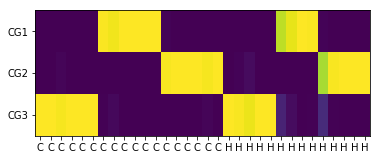

epoch 566 reconstruction  0.341 instantaneous forces 1247.078  tau  0.881


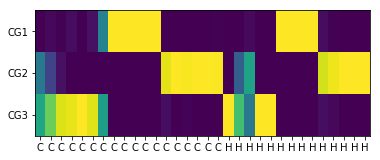

epoch 567 reconstruction  0.341 instantaneous forces 1338.995  tau  0.879


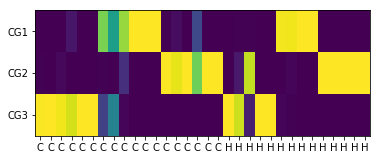

epoch 568 reconstruction  0.340 instantaneous forces 1329.493  tau  0.876


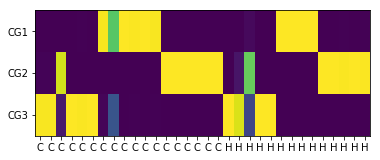

epoch 569 reconstruction  0.344 instantaneous forces 1241.313  tau  0.874


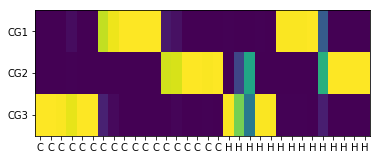

epoch 570 reconstruction  0.343 instantaneous forces 1247.140  tau  0.872


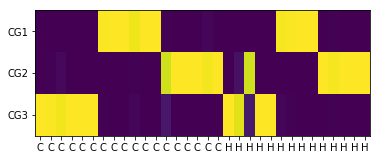

epoch 571 reconstruction  0.343 instantaneous forces 1253.560  tau  0.870


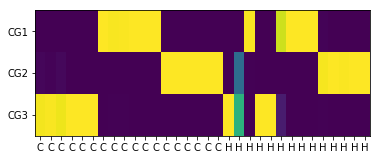

epoch 572 reconstruction  0.341 instantaneous forces 1269.942  tau  0.868


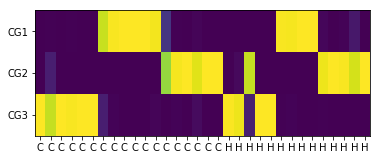

epoch 573 reconstruction  0.342 instantaneous forces 1234.889  tau  0.866


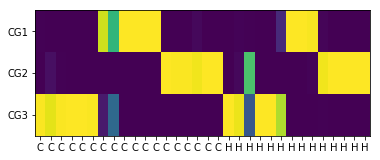

epoch 574 reconstruction  0.343 instantaneous forces 1256.192  tau  0.864


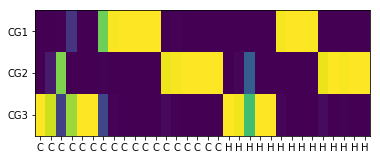

epoch 575 reconstruction  0.343 instantaneous forces 1204.423  tau  0.862


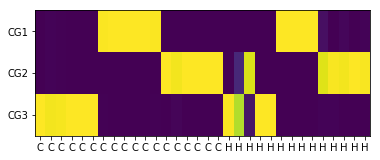

epoch 576 reconstruction  0.343 instantaneous forces 1260.981  tau  0.860


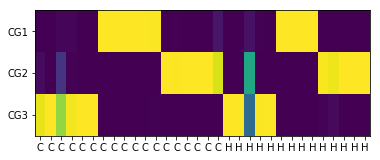

epoch 577 reconstruction  0.342 instantaneous forces 1225.267  tau  0.858


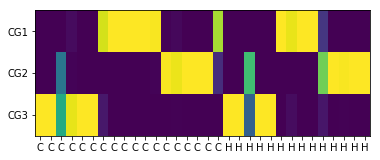

epoch 578 reconstruction  0.342 instantaneous forces 1194.401  tau  0.856


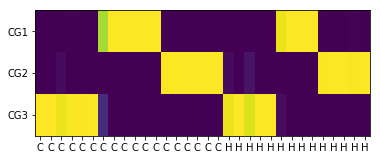

epoch 579 reconstruction  0.343 instantaneous forces 1293.216  tau  0.854


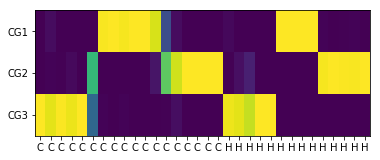

epoch 580 reconstruction  0.342 instantaneous forces 1296.417  tau  0.852


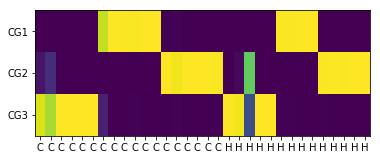

epoch 581 reconstruction  0.344 instantaneous forces 1278.110  tau  0.849


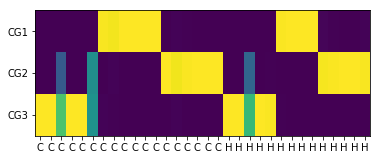

epoch 582 reconstruction  0.342 instantaneous forces 1249.324  tau  0.847


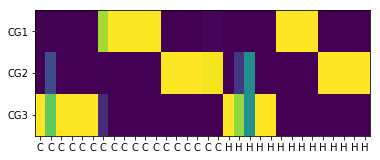

epoch 583 reconstruction  0.343 instantaneous forces 1215.241  tau  0.845


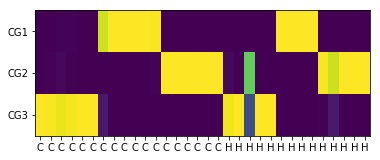

epoch 584 reconstruction  0.345 instantaneous forces 1274.487  tau  0.843


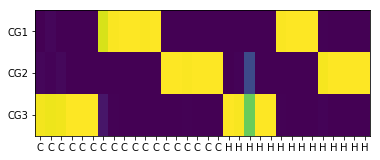

epoch 585 reconstruction  0.343 instantaneous forces 1246.816  tau  0.841


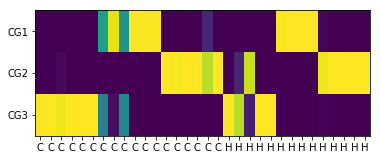

epoch 586 reconstruction  0.344 instantaneous forces 1186.928  tau  0.839


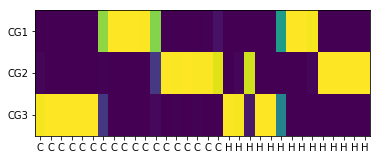

epoch 587 reconstruction  0.343 instantaneous forces 1242.101  tau  0.837


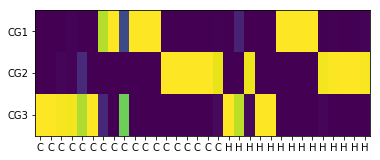

epoch 588 reconstruction  0.344 instantaneous forces 1205.238  tau  0.835


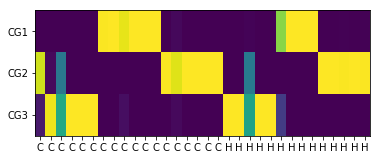

epoch 589 reconstruction  0.343 instantaneous forces 1226.875  tau  0.833


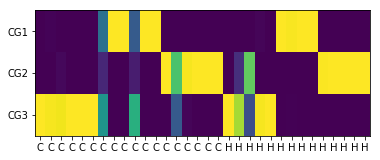

epoch 590 reconstruction  0.344 instantaneous forces 1192.726  tau  0.831


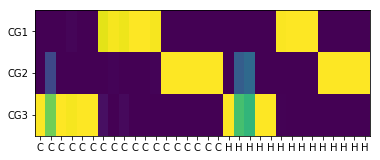

epoch 591 reconstruction  0.343 instantaneous forces 1202.793  tau  0.829


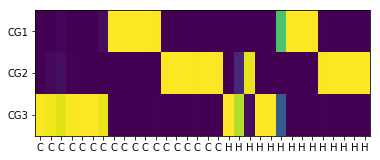

epoch 592 reconstruction  0.343 instantaneous forces 1216.399  tau  0.827


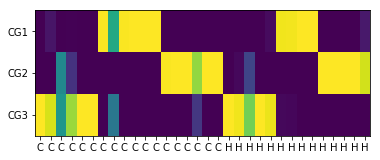

epoch 593 reconstruction  0.342 instantaneous forces 1220.058  tau  0.826


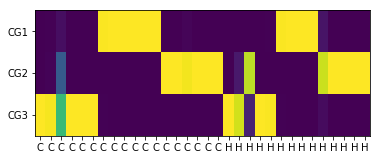

epoch 594 reconstruction  0.343 instantaneous forces 1270.646  tau  0.824


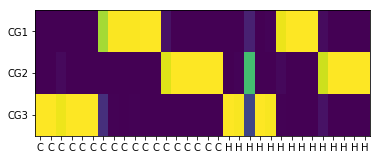

epoch 595 reconstruction  0.343 instantaneous forces 1277.721  tau  0.822


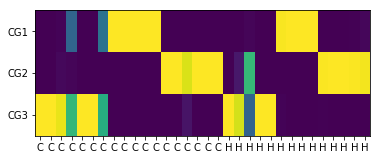

epoch 596 reconstruction  0.344 instantaneous forces 1322.718  tau  0.820


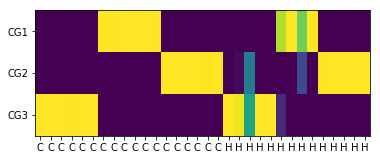

epoch 597 reconstruction  0.343 instantaneous forces 1180.169  tau  0.818


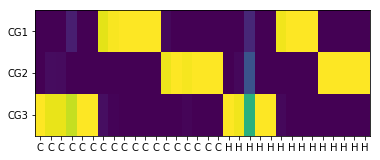

epoch 598 reconstruction  0.342 instantaneous forces 1254.097  tau  0.816


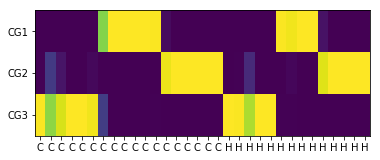

epoch 599 reconstruction  0.342 instantaneous forces 1206.179  tau  0.814


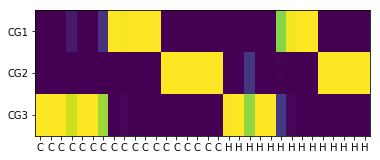

epoch 600 reconstruction  0.344 instantaneous forces 1218.437  tau  0.812


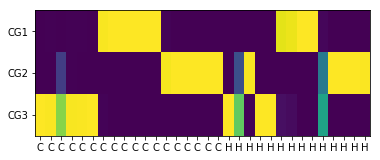

epoch 601 reconstruction  0.342 instantaneous forces 1263.668  tau  0.810


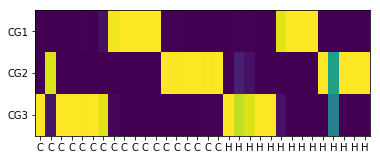

epoch 602 reconstruction  0.345 instantaneous forces 1324.044  tau  0.808


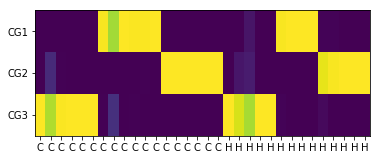

epoch 603 reconstruction  0.344 instantaneous forces 1193.069  tau  0.806


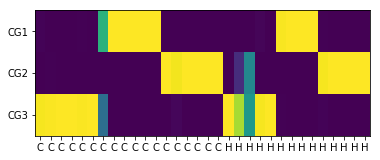

epoch 604 reconstruction  0.343 instantaneous forces 1164.476  tau  0.804


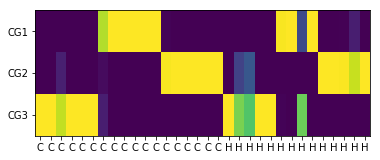

epoch 605 reconstruction  0.343 instantaneous forces 1206.182  tau  0.802


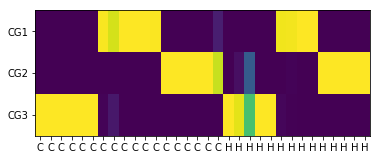

epoch 606 reconstruction  0.346 instantaneous forces 1171.494  tau  0.801


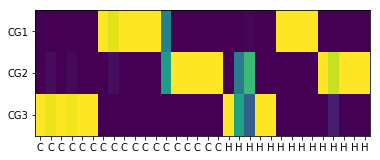

epoch 607 reconstruction  0.344 instantaneous forces 1176.011  tau  0.799


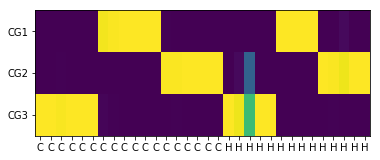

epoch 608 reconstruction  0.345 instantaneous forces 1187.620  tau  0.797


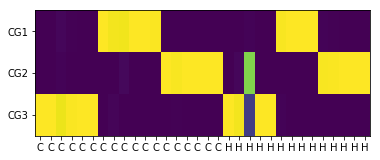

epoch 609 reconstruction  0.344 instantaneous forces 1279.126  tau  0.795


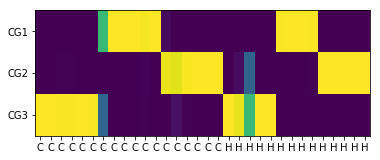

epoch 610 reconstruction  0.346 instantaneous forces 1187.495  tau  0.793


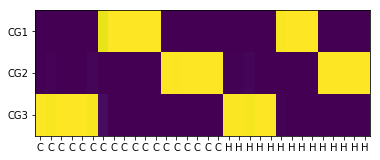

epoch 611 reconstruction  0.344 instantaneous forces 1161.144  tau  0.791


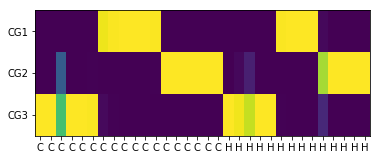

epoch 612 reconstruction  0.344 instantaneous forces 1224.082  tau  0.789


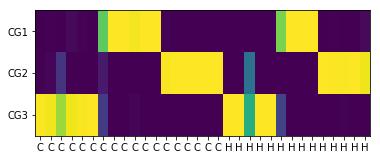

epoch 613 reconstruction  0.346 instantaneous forces 1233.606  tau  0.788


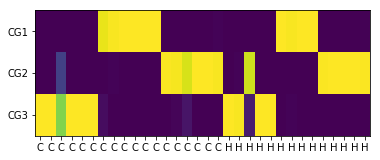

epoch 614 reconstruction  0.346 instantaneous forces 1166.436  tau  0.786


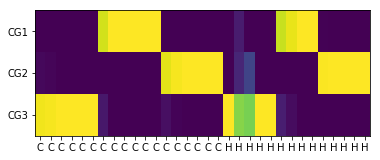

epoch 615 reconstruction  0.344 instantaneous forces 1167.870  tau  0.784


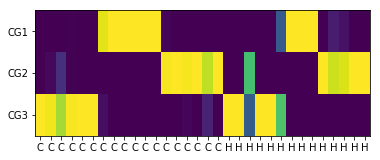

epoch 616 reconstruction  0.344 instantaneous forces 1191.680  tau  0.782


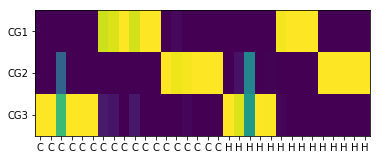

epoch 617 reconstruction  0.345 instantaneous forces 1129.534  tau  0.780


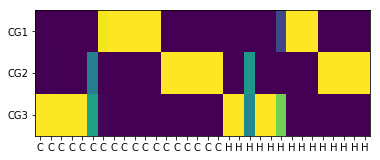

epoch 618 reconstruction  0.344 instantaneous forces 1213.957  tau  0.778


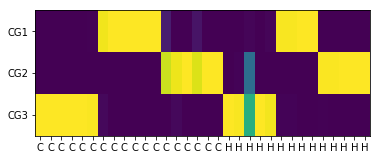

epoch 619 reconstruction  0.345 instantaneous forces 1171.489  tau  0.777


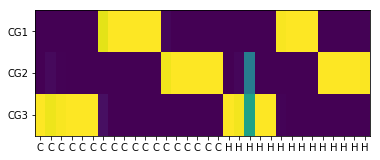

epoch 620 reconstruction  0.345 instantaneous forces 1134.021  tau  0.775


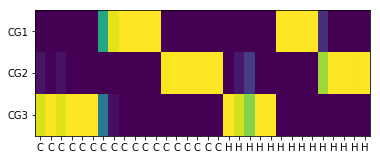

epoch 621 reconstruction  0.345 instantaneous forces 1228.993  tau  0.773


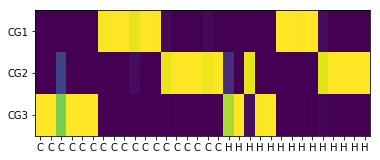

epoch 622 reconstruction  0.346 instantaneous forces 1144.643  tau  0.771


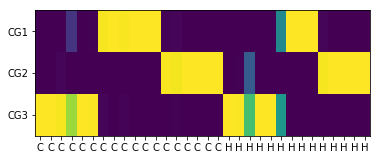

epoch 623 reconstruction  0.345 instantaneous forces 1207.205  tau  0.769


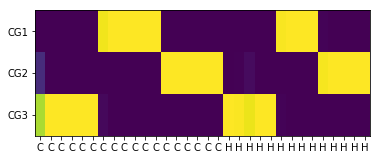

epoch 624 reconstruction  0.345 instantaneous forces 1209.511  tau  0.768


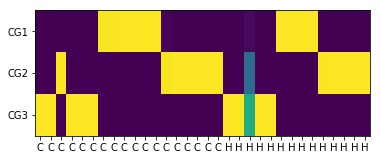

epoch 625 reconstruction  0.345 instantaneous forces 1212.529  tau  0.766


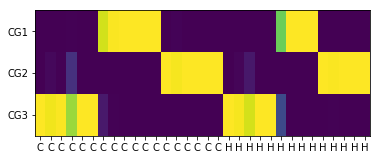

epoch 626 reconstruction  0.346 instantaneous forces 1234.160  tau  0.764


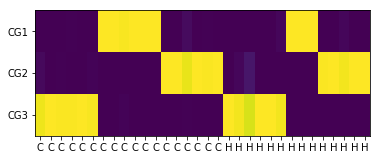

epoch 627 reconstruction  0.345 instantaneous forces 1145.101  tau  0.762


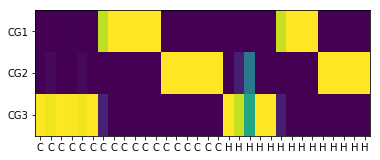

epoch 628 reconstruction  0.345 instantaneous forces 1231.647  tau  0.761


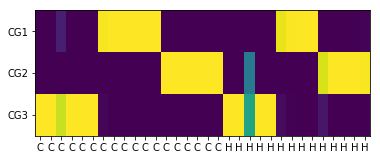

epoch 629 reconstruction  0.346 instantaneous forces 1208.543  tau  0.759


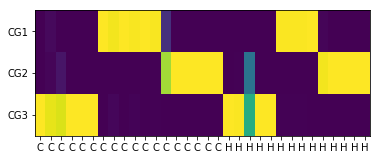

epoch 630 reconstruction  0.346 instantaneous forces 1175.788  tau  0.757


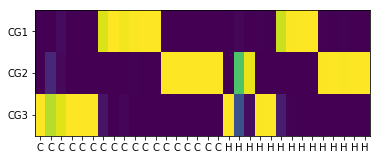

epoch 631 reconstruction  0.346 instantaneous forces 1201.586  tau  0.755


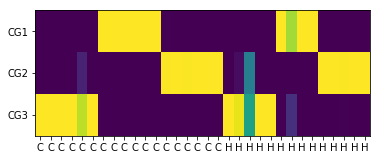

epoch 632 reconstruction  0.346 instantaneous forces 1235.485  tau  0.754


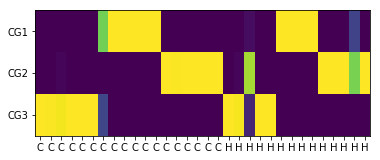

epoch 633 reconstruction  0.346 instantaneous forces 1147.817  tau  0.752


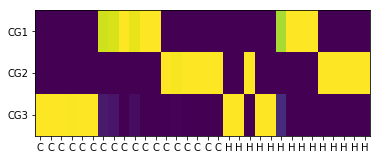

epoch 634 reconstruction  0.347 instantaneous forces 1190.774  tau  0.750


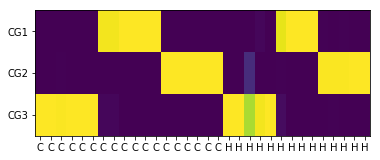

epoch 635 reconstruction  0.346 instantaneous forces 1121.869  tau  0.749


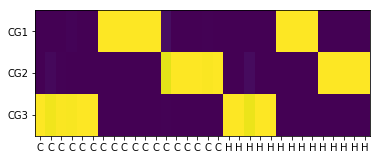

epoch 636 reconstruction  0.347 instantaneous forces 1218.801  tau  0.747


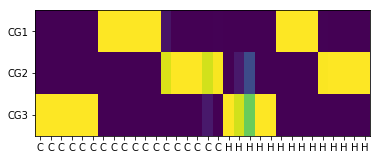

epoch 637 reconstruction  0.345 instantaneous forces 1263.014  tau  0.745


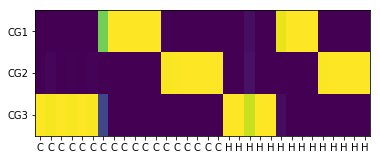

epoch 638 reconstruction  0.346 instantaneous forces 1113.284  tau  0.743


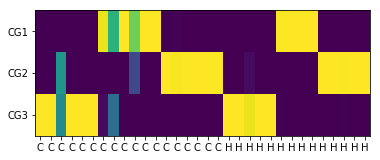

epoch 639 reconstruction  0.346 instantaneous forces 1187.555  tau  0.742


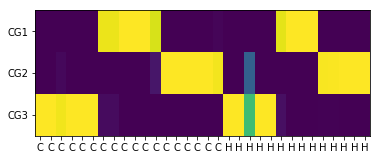

epoch 640 reconstruction  0.346 instantaneous forces 1142.814  tau  0.740


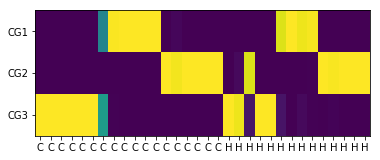

epoch 641 reconstruction  0.346 instantaneous forces 1153.410  tau  0.738


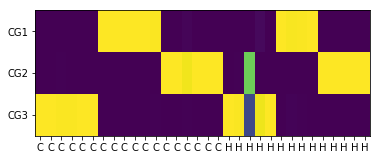

epoch 642 reconstruction  0.345 instantaneous forces 1159.156  tau  0.737


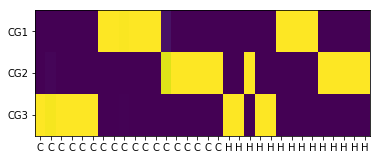

epoch 643 reconstruction  0.345 instantaneous forces 1202.068  tau  0.735


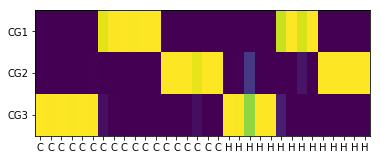

epoch 644 reconstruction  0.347 instantaneous forces 1169.651  tau  0.733


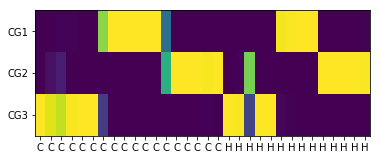

epoch 645 reconstruction  0.347 instantaneous forces 1170.827  tau  0.732


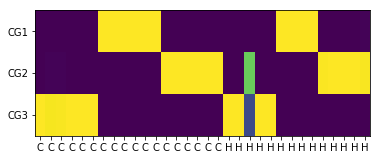

epoch 646 reconstruction  0.348 instantaneous forces 1211.960  tau  0.730


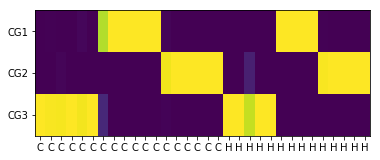

epoch 647 reconstruction  0.347 instantaneous forces 1194.528  tau  0.728


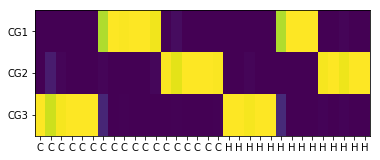

epoch 648 reconstruction  0.346 instantaneous forces 1142.862  tau  0.727


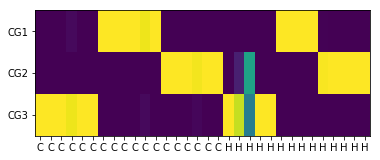

epoch 649 reconstruction  0.347 instantaneous forces 1166.800  tau  0.725


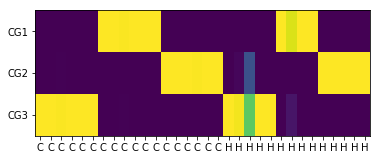

epoch 650 reconstruction  0.345 instantaneous forces 1239.082  tau  0.723


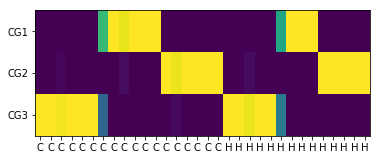

epoch 651 reconstruction  0.348 instantaneous forces 1089.053  tau  0.722


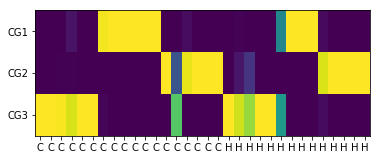

epoch 652 reconstruction  0.347 instantaneous forces 1176.720  tau  0.720


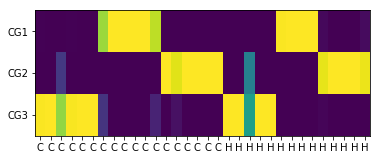

epoch 653 reconstruction  0.347 instantaneous forces 1111.701  tau  0.718


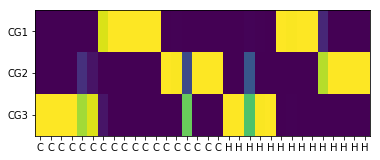

epoch 654 reconstruction  0.347 instantaneous forces 1176.873  tau  0.717


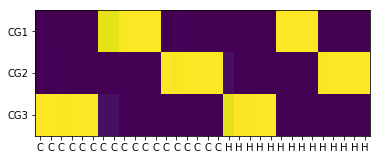

epoch 655 reconstruction  0.349 instantaneous forces 1175.190  tau  0.715


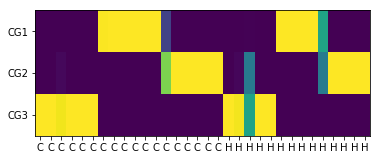

epoch 656 reconstruction  0.346 instantaneous forces 1065.974  tau  0.714


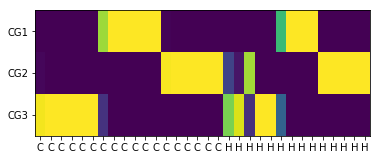

epoch 657 reconstruction  0.347 instantaneous forces 1151.409  tau  0.712


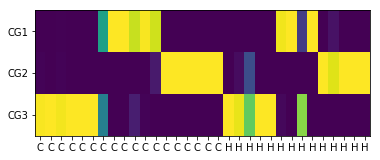

epoch 658 reconstruction  0.348 instantaneous forces 1183.520  tau  0.710


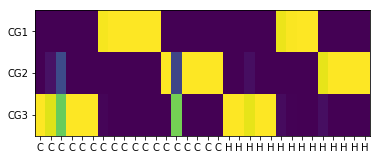

epoch 659 reconstruction  0.348 instantaneous forces 1174.902  tau  0.709


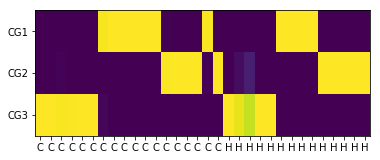

epoch 660 reconstruction  0.348 instantaneous forces 1126.787  tau  0.707


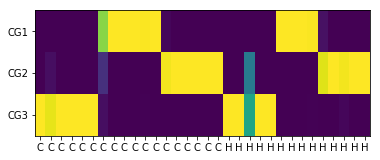

epoch 661 reconstruction  0.347 instantaneous forces 1145.691  tau  0.706


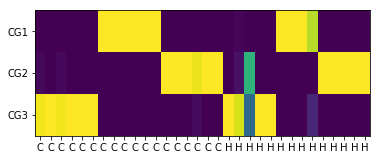

epoch 662 reconstruction  0.348 instantaneous forces 1170.612  tau  0.704


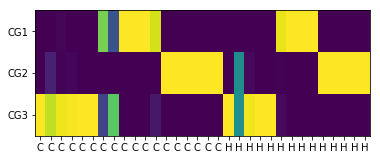

epoch 663 reconstruction  0.348 instantaneous forces 1129.188  tau  0.702


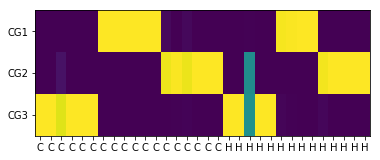

epoch 664 reconstruction  0.348 instantaneous forces 1158.291  tau  0.701


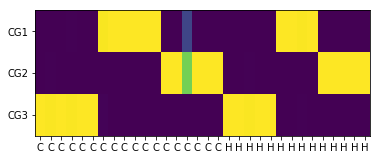

epoch 665 reconstruction  0.348 instantaneous forces 1198.291  tau  0.699


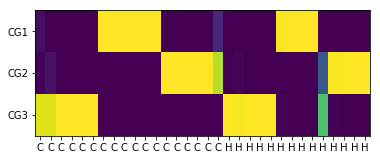

epoch 666 reconstruction  0.348 instantaneous forces 1104.816  tau  0.698


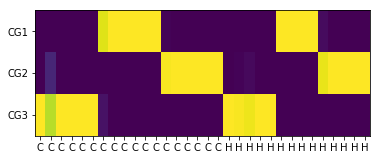

epoch 667 reconstruction  0.349 instantaneous forces 1175.917  tau  0.696


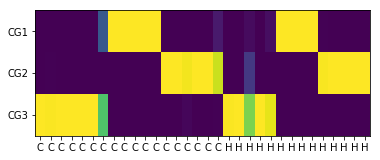

epoch 668 reconstruction  0.347 instantaneous forces 1109.595  tau  0.695


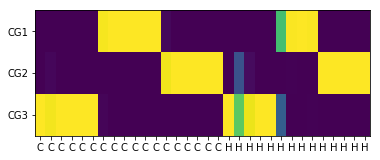

epoch 669 reconstruction  0.347 instantaneous forces 1185.387  tau  0.693


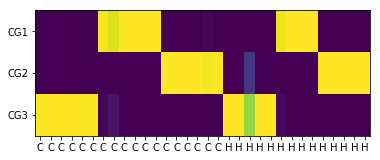

epoch 670 reconstruction  0.347 instantaneous forces 1109.579  tau  0.692


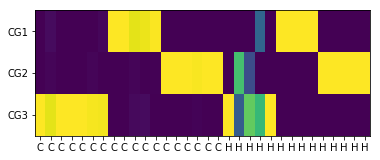

epoch 671 reconstruction  0.348 instantaneous forces 1203.879  tau  0.690


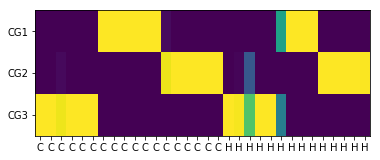

epoch 672 reconstruction  0.347 instantaneous forces 1146.289  tau  0.689


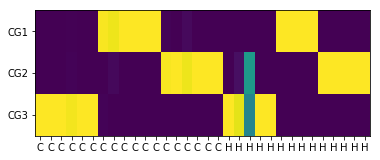

epoch 673 reconstruction  0.347 instantaneous forces 1165.404  tau  0.687


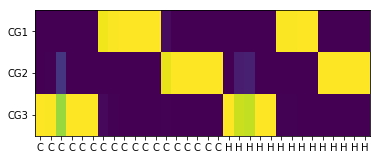

epoch 674 reconstruction  0.347 instantaneous forces 1104.705  tau  0.685


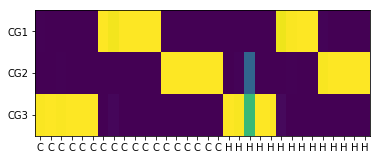

epoch 675 reconstruction  0.348 instantaneous forces 1102.513  tau  0.684


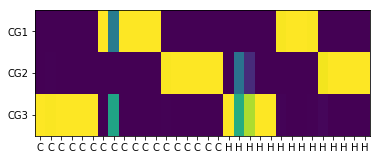

epoch 676 reconstruction  0.348 instantaneous forces 1131.863  tau  0.682


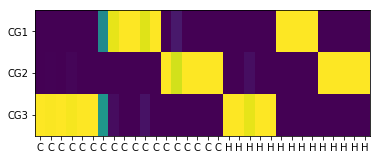

epoch 677 reconstruction  0.347 instantaneous forces 1120.285  tau  0.681


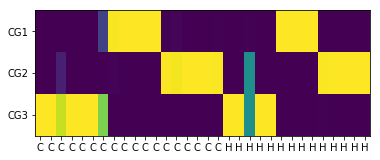

epoch 678 reconstruction  0.348 instantaneous forces 1149.046  tau  0.679


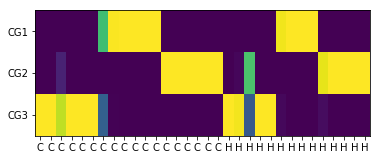

epoch 679 reconstruction  0.347 instantaneous forces 1118.361  tau  0.678


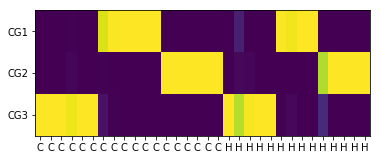

epoch 680 reconstruction  0.348 instantaneous forces 1145.467  tau  0.676


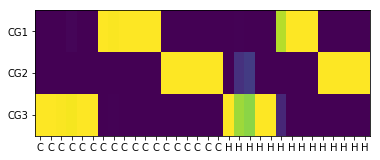

epoch 681 reconstruction  0.348 instantaneous forces 1134.215  tau  0.675


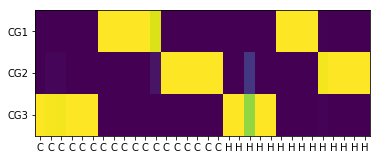

epoch 682 reconstruction  0.349 instantaneous forces 1161.348  tau  0.673


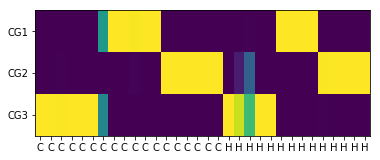

epoch 683 reconstruction  0.348 instantaneous forces 1137.066  tau  0.672


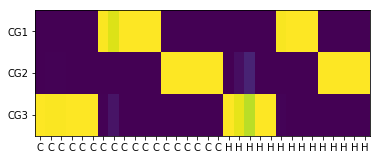

epoch 684 reconstruction  0.349 instantaneous forces 1092.528  tau  0.671


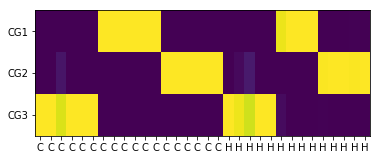

epoch 685 reconstruction  0.349 instantaneous forces 1102.878  tau  0.669


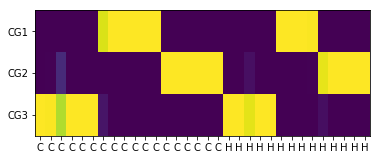

epoch 686 reconstruction  0.349 instantaneous forces 1117.718  tau  0.668


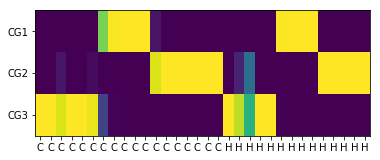

epoch 687 reconstruction  0.348 instantaneous forces 1080.481  tau  0.666


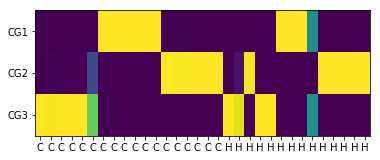

epoch 688 reconstruction  0.349 instantaneous forces 1081.750  tau  0.665


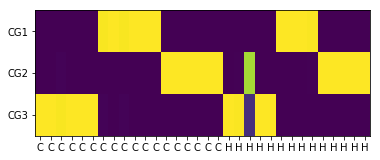

epoch 689 reconstruction  0.347 instantaneous forces 1123.816  tau  0.663


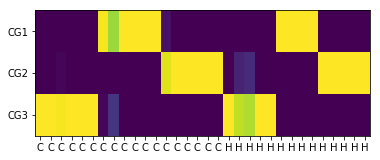

epoch 690 reconstruction  0.349 instantaneous forces 1108.368  tau  0.662


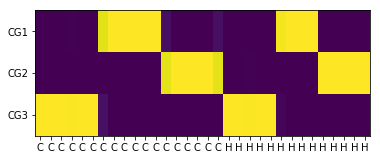

epoch 691 reconstruction  0.349 instantaneous forces 1100.917  tau  0.660


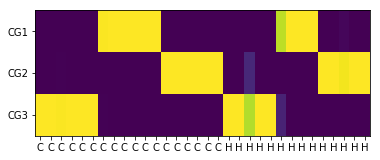

epoch 692 reconstruction  0.347 instantaneous forces 1157.044  tau  0.659


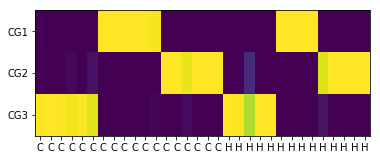

epoch 693 reconstruction  0.349 instantaneous forces 1190.456  tau  0.657


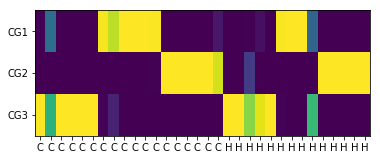

epoch 694 reconstruction  0.349 instantaneous forces 1204.946  tau  0.656


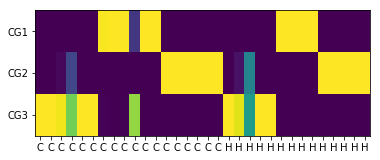

epoch 695 reconstruction  0.349 instantaneous forces 1190.327  tau  0.655


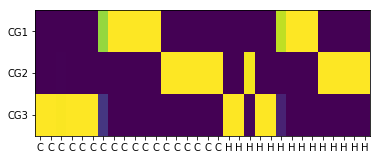

epoch 696 reconstruction  0.348 instantaneous forces 1067.462  tau  0.653


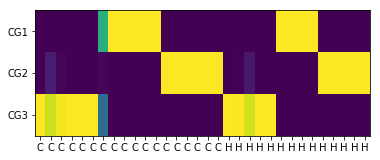

epoch 697 reconstruction  0.349 instantaneous forces 1089.129  tau  0.652


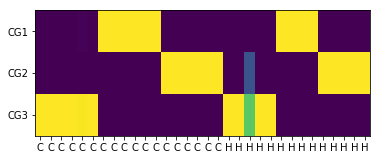

epoch 698 reconstruction  0.350 instantaneous forces 1092.855  tau  0.650


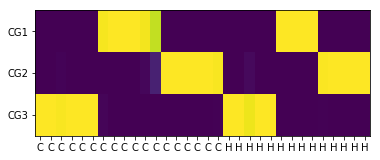

epoch 699 reconstruction  0.350 instantaneous forces 1171.222  tau  0.649


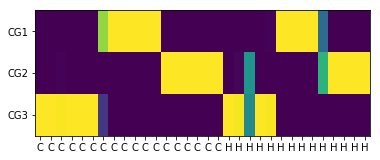

epoch 700 reconstruction  0.349 instantaneous forces 1096.251  tau  0.648


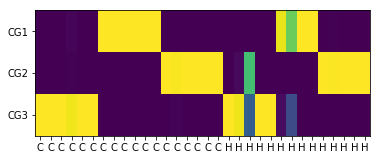

epoch 701 reconstruction  0.348 instantaneous forces 1137.353  tau  0.646


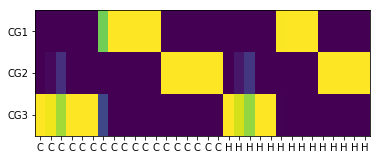

epoch 702 reconstruction  0.349 instantaneous forces 1118.698  tau  0.645


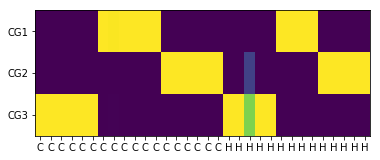

epoch 703 reconstruction  0.349 instantaneous forces 1140.552  tau  0.643


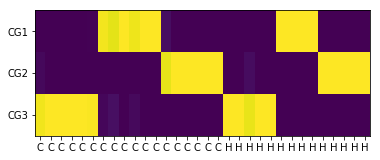

epoch 704 reconstruction  0.349 instantaneous forces 1119.067  tau  0.642


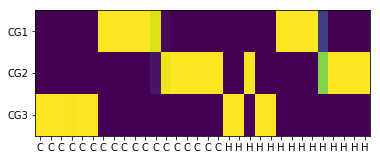

epoch 705 reconstruction  0.350 instantaneous forces 1171.814  tau  0.641


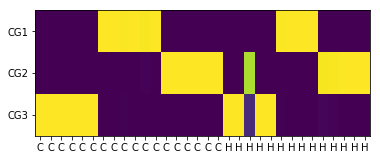

epoch 706 reconstruction  0.349 instantaneous forces 1089.531  tau  0.639


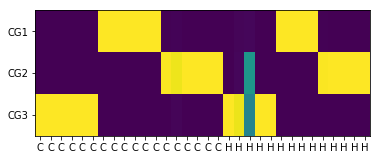

epoch 707 reconstruction  0.350 instantaneous forces 1105.144  tau  0.638


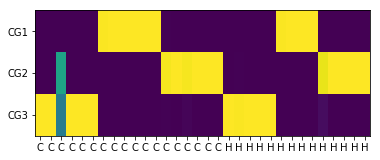

epoch 708 reconstruction  0.351 instantaneous forces 1132.409  tau  0.636


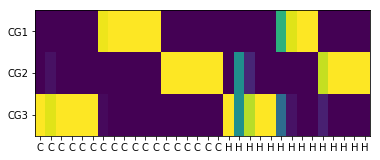

epoch 709 reconstruction  0.351 instantaneous forces 1076.575  tau  0.635


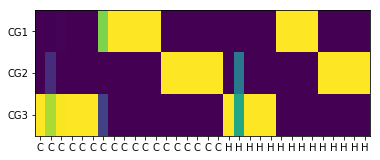

epoch 710 reconstruction  0.351 instantaneous forces 1153.041  tau  0.634


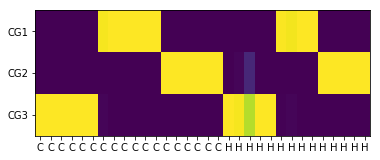

epoch 711 reconstruction  0.349 instantaneous forces 1079.615  tau  0.632


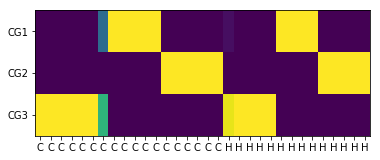

epoch 712 reconstruction  0.349 instantaneous forces 1107.255  tau  0.631


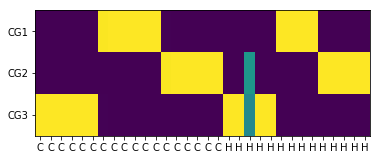

epoch 713 reconstruction  0.349 instantaneous forces 1116.702  tau  0.630


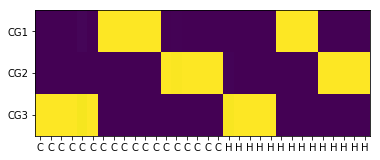

epoch 714 reconstruction  0.349 instantaneous forces 1140.030  tau  0.628


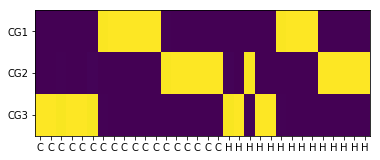

epoch 715 reconstruction  0.349 instantaneous forces 1118.933  tau  0.627


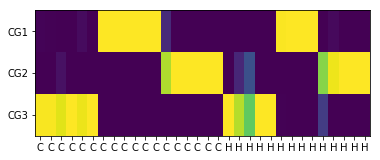

epoch 716 reconstruction  0.349 instantaneous forces 1135.824  tau  0.626


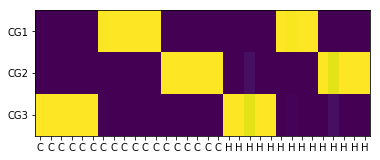

epoch 717 reconstruction  0.349 instantaneous forces 1142.055  tau  0.624


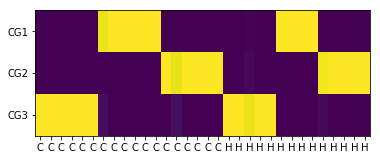

epoch 718 reconstruction  0.349 instantaneous forces 1171.325  tau  0.623


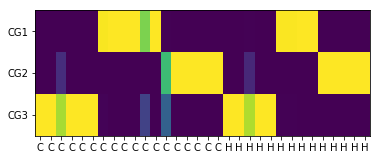

epoch 719 reconstruction  0.350 instantaneous forces 1151.933  tau  0.622


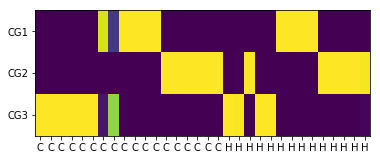

epoch 720 reconstruction  0.350 instantaneous forces 1070.380  tau  0.620


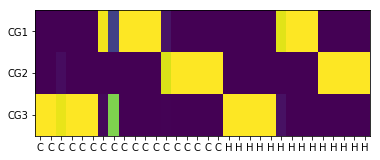

epoch 721 reconstruction  0.350 instantaneous forces 1190.418  tau  0.619


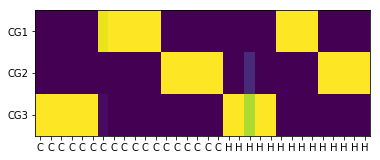

epoch 722 reconstruction  0.350 instantaneous forces 1105.755  tau  0.618


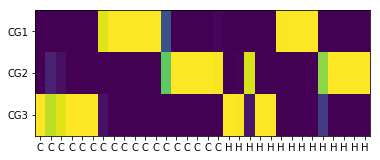

epoch 723 reconstruction  0.349 instantaneous forces 1131.542  tau  0.616


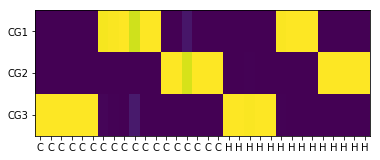

epoch 724 reconstruction  0.349 instantaneous forces 1118.415  tau  0.615


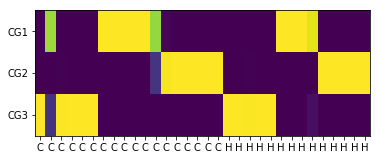

epoch 725 reconstruction  0.349 instantaneous forces 1098.737  tau  0.614


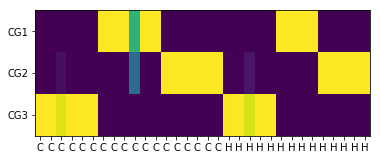

epoch 726 reconstruction  0.349 instantaneous forces 1124.266  tau  0.613


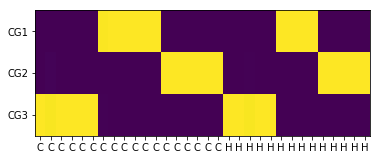

epoch 727 reconstruction  0.349 instantaneous forces 1155.130  tau  0.611


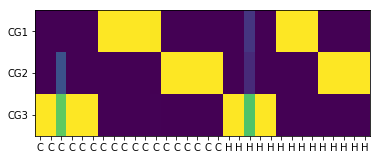

epoch 728 reconstruction  0.350 instantaneous forces 1107.409  tau  0.610


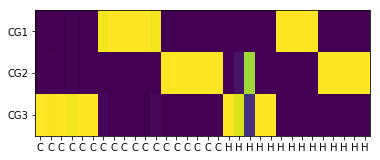

epoch 729 reconstruction  0.349 instantaneous forces 1105.565  tau  0.609


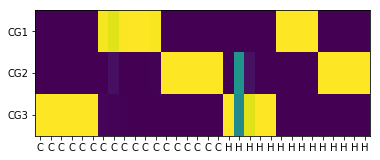

epoch 730 reconstruction  0.350 instantaneous forces 1149.086  tau  0.607


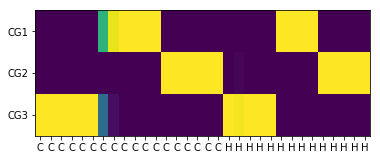

epoch 731 reconstruction  0.349 instantaneous forces 1153.785  tau  0.606


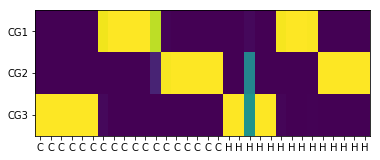

epoch 732 reconstruction  0.350 instantaneous forces 1081.789  tau  0.605


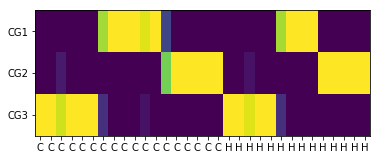

epoch 733 reconstruction  0.350 instantaneous forces 1143.250  tau  0.604


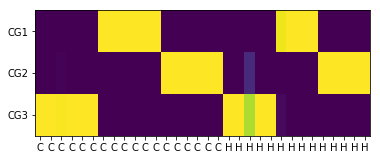

epoch 734 reconstruction  0.351 instantaneous forces 1082.019  tau  0.602


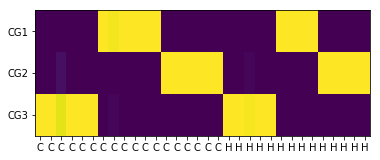

epoch 735 reconstruction  0.350 instantaneous forces 1081.256  tau  0.601


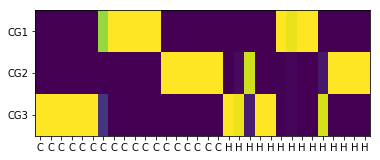

epoch 736 reconstruction  0.349 instantaneous forces 1108.549  tau  0.600


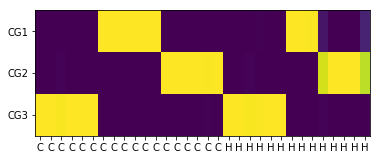

epoch 737 reconstruction  0.351 instantaneous forces 1146.719  tau  0.599


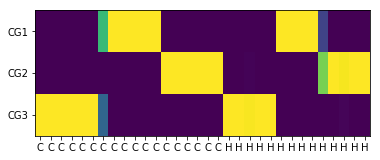

epoch 738 reconstruction  0.350 instantaneous forces 1159.507  tau  0.597


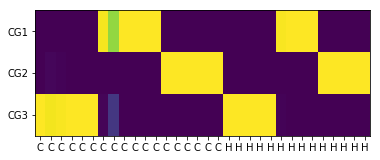

epoch 739 reconstruction  0.350 instantaneous forces 1120.228  tau  0.596


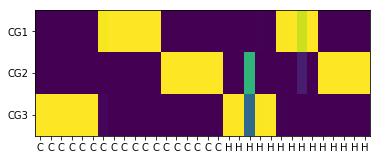

epoch 740 reconstruction  0.350 instantaneous forces 1107.797  tau  0.595


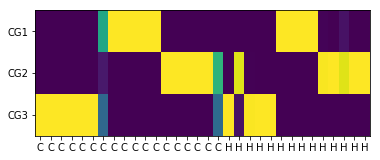

epoch 741 reconstruction  0.351 instantaneous forces 1116.474  tau  0.594


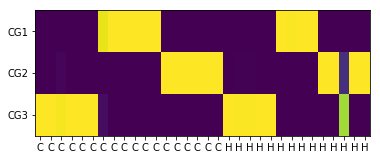

epoch 742 reconstruction  0.349 instantaneous forces 1096.463  tau  0.592


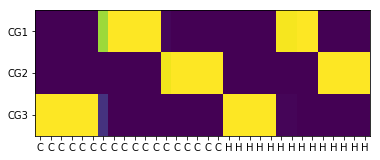

epoch 743 reconstruction  0.351 instantaneous forces 1114.498  tau  0.591


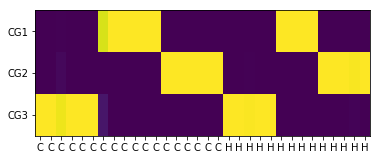

epoch 744 reconstruction  0.349 instantaneous forces 1138.010  tau  0.590


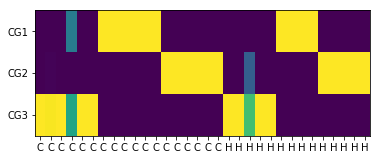

epoch 745 reconstruction  0.348 instantaneous forces 1107.454  tau  0.589


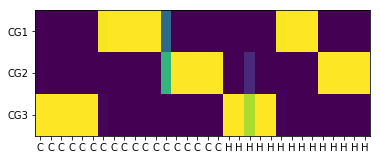

epoch 746 reconstruction  0.351 instantaneous forces 1111.623  tau  0.588


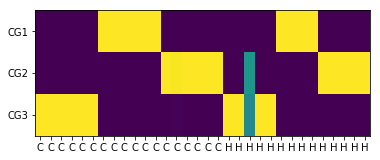

epoch 747 reconstruction  0.351 instantaneous forces 1071.687  tau  0.586


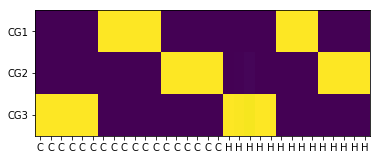

epoch 748 reconstruction  0.350 instantaneous forces 1091.612  tau  0.585


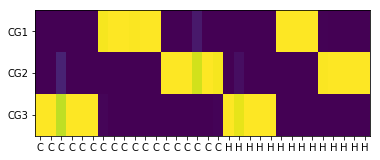

epoch 749 reconstruction  0.351 instantaneous forces 1100.206  tau  0.584


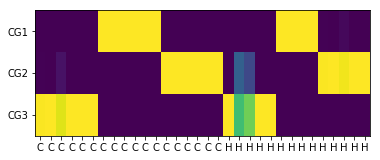

epoch 750 reconstruction  0.351 instantaneous forces 1104.774  tau  0.583


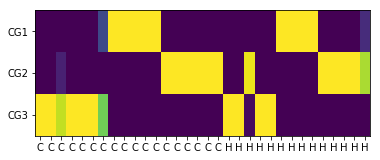

epoch 751 reconstruction  0.350 instantaneous forces 1085.548  tau  0.582


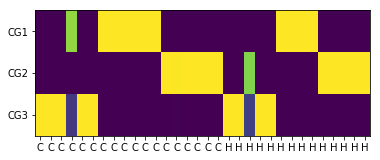

epoch 752 reconstruction  0.350 instantaneous forces 1136.646  tau  0.580


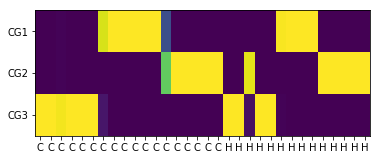

epoch 753 reconstruction  0.350 instantaneous forces 1095.479  tau  0.579


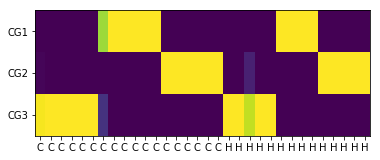

epoch 754 reconstruction  0.351 instantaneous forces 1155.786  tau  0.578


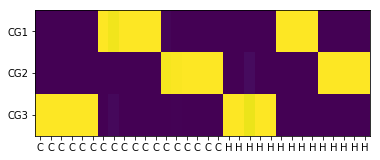

epoch 755 reconstruction  0.351 instantaneous forces 1129.059  tau  0.577


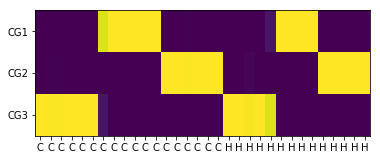

epoch 756 reconstruction  0.352 instantaneous forces 1145.500  tau  0.576


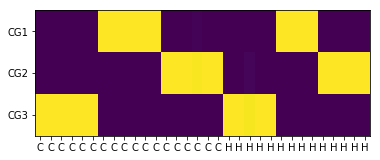

epoch 757 reconstruction  0.350 instantaneous forces 1073.809  tau  0.574


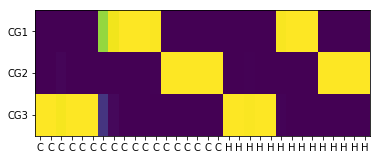

epoch 758 reconstruction  0.351 instantaneous forces 1101.539  tau  0.573


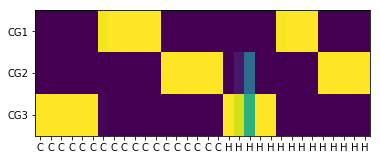

epoch 759 reconstruction  0.351 instantaneous forces 1092.036  tau  0.572


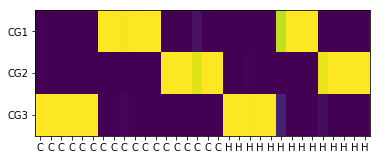

epoch 760 reconstruction  0.351 instantaneous forces 1068.194  tau  0.571


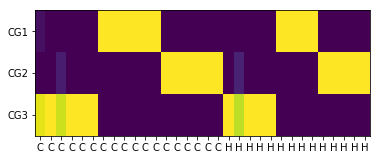

epoch 761 reconstruction  0.351 instantaneous forces 1054.306  tau  0.570


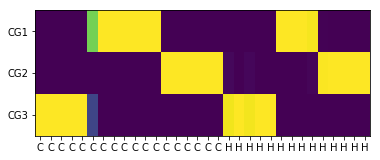

epoch 762 reconstruction  0.352 instantaneous forces 1060.840  tau  0.569


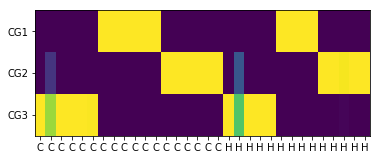

epoch 763 reconstruction  0.351 instantaneous forces 1077.425  tau  0.567


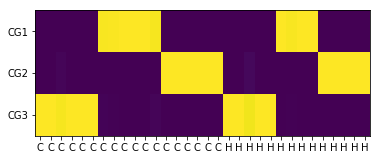

epoch 764 reconstruction  0.351 instantaneous forces 1080.874  tau  0.566


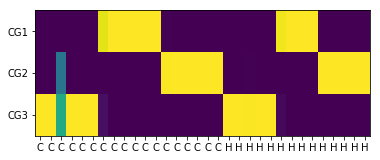

epoch 765 reconstruction  0.351 instantaneous forces 1064.958  tau  0.565


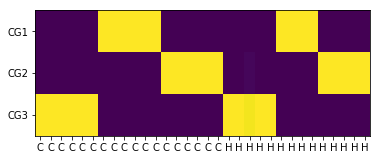

epoch 766 reconstruction  0.351 instantaneous forces 1118.427  tau  0.564


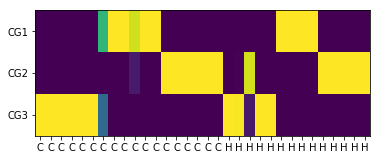

epoch 767 reconstruction  0.351 instantaneous forces 1089.699  tau  0.563


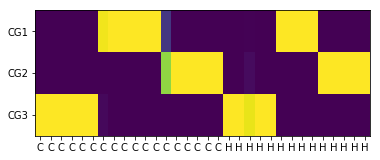

epoch 768 reconstruction  0.350 instantaneous forces 1118.390  tau  0.562


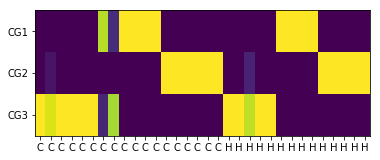

epoch 769 reconstruction  0.350 instantaneous forces 1127.152  tau  0.561


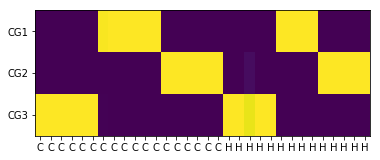

epoch 770 reconstruction  0.351 instantaneous forces 1112.660  tau  0.560


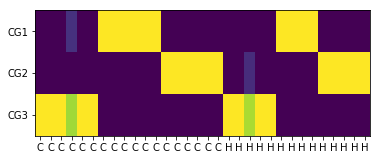

epoch 771 reconstruction  0.351 instantaneous forces 1101.395  tau  0.558


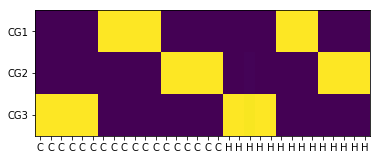

epoch 772 reconstruction  0.351 instantaneous forces 1046.139  tau  0.557


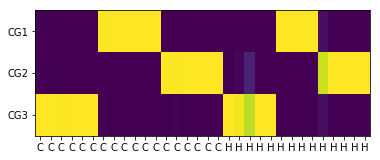

epoch 773 reconstruction  0.351 instantaneous forces 1097.742  tau  0.556


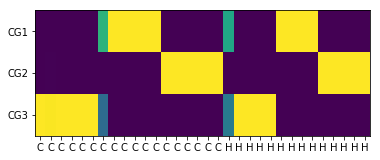

epoch 774 reconstruction  0.351 instantaneous forces 1076.224  tau  0.555


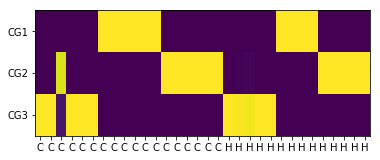

epoch 775 reconstruction  0.351 instantaneous forces 1084.264  tau  0.554


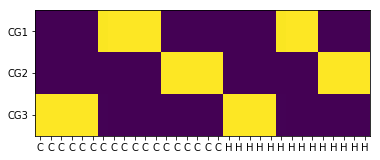

epoch 776 reconstruction  0.351 instantaneous forces 1066.690  tau  0.553


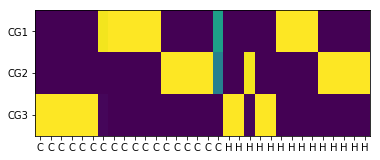

epoch 777 reconstruction  0.352 instantaneous forces 1092.797  tau  0.552


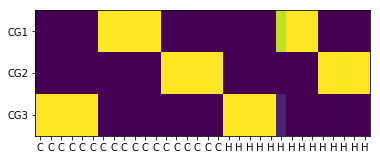

epoch 778 reconstruction  0.353 instantaneous forces 1084.515  tau  0.551


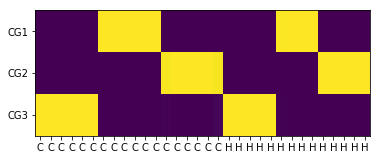

epoch 779 reconstruction  0.352 instantaneous forces 1108.081  tau  0.550


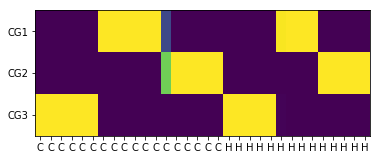

epoch 780 reconstruction  0.350 instantaneous forces 1062.684  tau  0.548


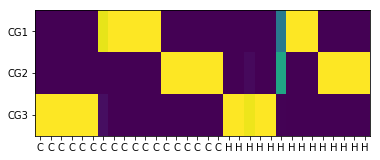

epoch 781 reconstruction  0.353 instantaneous forces 1094.437  tau  0.547


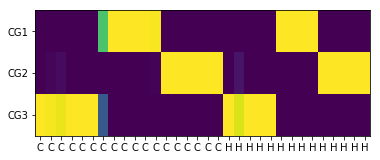

epoch 782 reconstruction  0.351 instantaneous forces 1060.232  tau  0.546


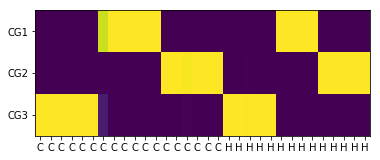

epoch 783 reconstruction  0.351 instantaneous forces 1096.256  tau  0.545


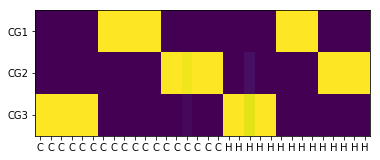

epoch 784 reconstruction  0.351 instantaneous forces 1053.989  tau  0.544


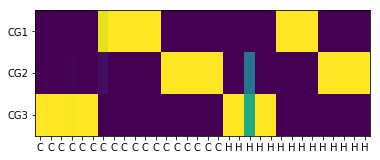

epoch 785 reconstruction  0.352 instantaneous forces 1076.647  tau  0.543


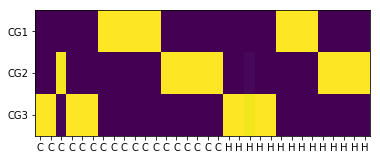

epoch 786 reconstruction  0.351 instantaneous forces 1115.779  tau  0.542


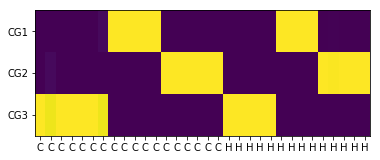

epoch 787 reconstruction  0.350 instantaneous forces 1040.586  tau  0.541


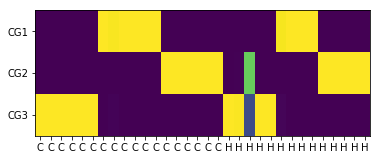

epoch 788 reconstruction  0.351 instantaneous forces 1135.649  tau  0.540


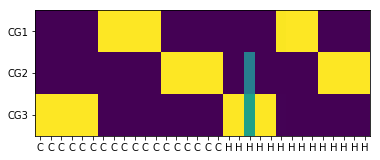

epoch 789 reconstruction  0.352 instantaneous forces 1105.204  tau  0.539


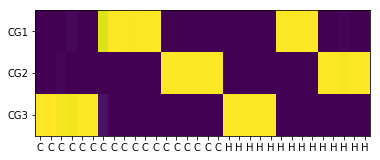

epoch 790 reconstruction  0.352 instantaneous forces 1064.163  tau  0.538


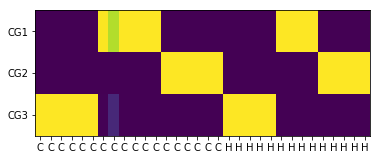

epoch 791 reconstruction  0.351 instantaneous forces 1113.473  tau  0.537


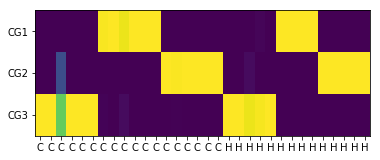

epoch 792 reconstruction  0.352 instantaneous forces 1084.013  tau  0.536


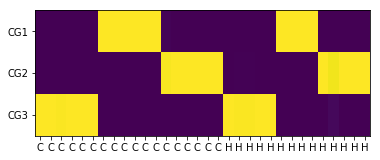

epoch 793 reconstruction  0.352 instantaneous forces 1051.067  tau  0.535


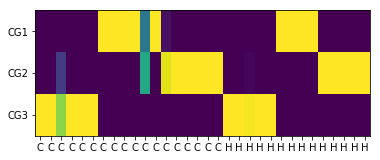

epoch 794 reconstruction  0.351 instantaneous forces 1038.122  tau  0.534


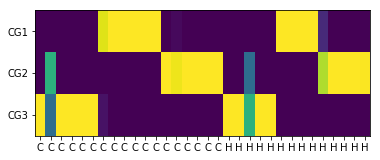

epoch 795 reconstruction  0.351 instantaneous forces 1056.341  tau  0.532


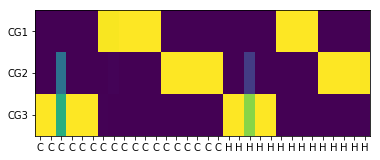

epoch 796 reconstruction  0.351 instantaneous forces 1035.886  tau  0.531


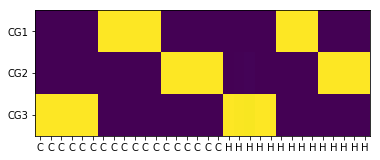

epoch 797 reconstruction  0.351 instantaneous forces 1092.931  tau  0.530


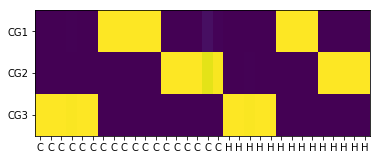

epoch 798 reconstruction  0.352 instantaneous forces 1076.710  tau  0.529


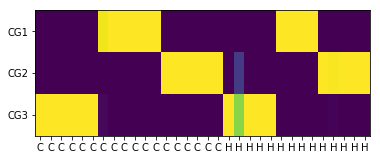

epoch 799 reconstruction  0.352 instantaneous forces 1065.773  tau  0.528


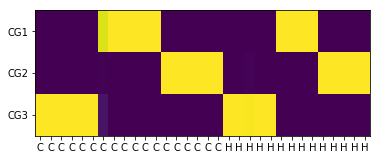

In [27]:
for epoch in range(par["max_epoch"]):  
        loss_epoch = 0.0  
        loss_ae_epoch = 0.0
        loss_fm_epoch = 0.0
            
        for i, batch in enumerate(xyz):
            batch = torch.Tensor(batch.reshape(-1, n_atom, 3)).to(device) 
            cg_xyz = Encoder(batch, t_sched[epoch])
            CG = gumbel_softmax(Encoder.weight1.t(), t_sched[epoch] * 0.7, device=device).t()

            decoded = Decoder(cg_xyz)
            loss_ae = criterion(decoded, batch)
            
            f0 = torch.Tensor(force[i].reshape(-1, n_atom, 3)).to(device)
            f = torch.matmul(CG, f0)
            mean_force = f.pow(2).sum(2).mean()

            loss_fm = mean_force
            
            if epoch >= par["epoch_regularize"]:
                loss = par["rho"] * loss_ae + par["rho"]  * mean_force
            else: 
                loss = par["rho"] * loss_ae

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_epoch += loss.item()
            loss_ae_epoch += loss_ae.item()
            loss_fm_epoch += loss_fm.item()
        
        loss_epoch = loss_epoch/xyz.shape[0]
        loss_ae_epoch = loss_ae_epoch/xyz.shape[0]
        loss_fm_epoch = loss_fm_epoch/xyz.shape[0]

        loss_log.append(loss_epoch)
        loss_ae_log.append(loss_ae_epoch)
        loss_fm_log.append(loss_fm_epoch)

        print("epoch %d reconstruction  %.3f instantaneous forces %.3f  tau  %.3f"  % (epoch, loss_ae_epoch, loss_fm_epoch, t_sched[epoch].item()))

        # Plot the mapping 
        CG = gumbel_softmax(Encoder.weight1.t(), t_sched[epoch], device=device).t()
        plt.imshow(CG.detach().cpu().numpy(), aspect=4)
        plt.xticks(np.arange(n_atom), otp_element)
        plt.yticks(np.arange(N_cg), ["CG" + str(i+1) for i in range(N_cg)])
        plt.show()

In [ ]:
# Save trajectory 
save_traj(Z=[1] * N_cg, traj=cg_xyz.detach().cpu().numpy(),name= 'CG.xyz')
save_traj(Z=otp_element, traj=decoded.detach().cpu().numpy(),name='decode.xyz')